# 0.0 Imports

In [280]:
import psycopg2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from IPython.display              import Image
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway, ttest_ind, mannwhitneyu
from scipy.stats import pearsonr
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.formula.api import ols
from statsmodels.stats.proportion import proportions_ztest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler, OneHotEncoder
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
import pickle
import json
from sklearn.feature_selection    import SelectKBest, f_classif, f_regression
import scikitplot as skplt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
import xgboost           as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

In [2]:
warnings.filterwarnings("ignore")
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)

## Helper functions

In [320]:
def cross_validation(X, y, list: models, kfold: int = 5, base_perc: float = 0.2):
    
    folds = StratifiedKFold(n_splits=kfold, shuffle=True, random_state=42)

    df_result = pd.DataFrame()
    
    i = 1
    j = len(models)

    for model in models:
        
        print(f"Starting cross validation for model {i}/{j}...")
        
        precision_list = []
        recall_list = []
        roc_auc_list = []

        for train_idx, test_idx in folds.split(X, y):
            X_train_cv = X.iloc[train_idx]
            y_train_cv = y.iloc[train_idx]
            X_test_cv  = X.iloc[test_idx]      
            y_test_cv  = y.iloc[test_idx]      
            
            k = int(base_perc *  X_test_cv.shape[0])

            model.fit(X_train_cv, y_train_cv)

            ypred_proba = model.predict_proba(X_test_cv)

            metrics = X_test_cv.copy()
            metrics['real'] = y_test_cv.copy()
            metrics['score'] = ypred_proba[:, 1].tolist()
            metrics = metrics.sort_values('score', ascending=False)
            metrics = metrics.reset_index(drop = True)
            metrics['ranking'] = metrics.index + 1
            metrics['recall_at_k'] = metrics.real.cumsum() / metrics.real.value_counts()[1]
            metrics['precision_at_k'] = metrics.real.cumsum() / metrics['ranking']

            precision_list.append(metrics['precision_at_k'].iloc[k])
            recall_list.append(metrics['recall_at_k'].iloc[k])
            roc_auc_list.append(roc_auc_score(y_test_cv, ypred_proba[:, 1]))

        result = pd.DataFrame({
            "model": type(model).__name__,
            "precision@k mean": [np.mean(precision_list).round(3)],
            "precision@k std": [np.std(precision_list).round(3)],
            "recall@k mean": [np.mean(recall_list).round(3)],
            "recall@k std": [np.std(recall_list).round(3)],
            "auc mean": [np.mean(roc_auc_list).round(3)],
            "auc std": [np.std(roc_auc_list).round(3)]
        })

        df_result = pd.concat([df_result, result])
        
        i += 1
        
        print("Finished.")
        
    return df_result

In [3]:
def reached_interested_customers(k):
    """
    Contacting K customers, the result of this function is the number of interested customers that will be reached.
    """
    return results[results['base_perc'] >= k/results.shape[0]].iloc[0]['cumulative_propensity_score']

In [4]:
def precision_at_k(data, k):
    return data.iloc[k]['precision_at_k']


def recall_at_k(data, k):
    return data.iloc[k]['recall_at_k']

In [5]:
def get_metrics_dataframe(X_test_copy, y_test, ypred_proba):
    metrics = pd.DataFrame()
    metrics['id'] = X_test_copy['id'].values
    metrics['response'] = y_test.values
    metrics['propensity_score'] = ypred_proba[:, 1].tolist()
    metrics = metrics.sort_values('propensity_score', ascending=False)
    metrics.reset_index(drop=True, inplace=True)
    metrics['ranking'] = metrics.index + 1
    metrics['precision_at_k'] = metrics.response.cumsum() / metrics['ranking']
    metrics['recall_at_k'] = metrics.response.cumsum() / metrics['response'].value_counts()[1]
    metrics['%_base'] = metrics['ranking']/metrics.shape[0]
    
    return metrics

In [6]:
def feature_importance(X_train, y_train, k, verbose=False):
    model = RandomForestClassifier(n_estimators=250, n_jobs=-1, random_state=1)
    model.fit(X_train, y_train)
    
    feature_importance = dict(zip(model.feature_importances_, model.feature_names_in_))
    feature_importance = dict(sorted(feature_importance.items(), reverse=True))
    
    if verbose:
        print('Feature Ranking: ')
        print('')
        for score, feature in feature_importance.items():
            print(f'{feature}: {score}')
    
    selected_cols_fi = []
    for col in list(feature_importance.items())[:k]:
        selected_cols_fi.append(col[1])
        
    return selected_cols_fi

In [7]:
def one_hot_encoding(X_train, X_test, col):
    #instanciando o encoder
    ohe = OneHotEncoder(sparse=False)

    #treinando o encoder
    ohe.fit(X_train[[col]])
    
    #aplicando o encoder nos dados de treino e gerando novo X_train
    ohe_encoded_train_columns = ohe.transform(X_train[[col]])
    ohe_encoded_train_dataframe = pd.DataFrame(ohe_encoded_train_columns, columns=ohe.get_feature_names_out())
    ohe_encoded_train_dataframe.reset_index(drop=True, inplace=True)
    X_train.reset_index(drop=True, inplace=True)
    X_train = pd.concat([X_train, ohe_encoded_train_dataframe], axis=1)
    X_train = X_train.drop(col, axis=1)

    #aplicando o encoder nos dados de teste e gerando novo X_test
    ohe_encoded_test_columns = ohe.transform(X_test[[col]])
    ohe_encoded_test_dataframe = pd.DataFrame(ohe_encoded_test_columns, columns=ohe.get_feature_names_out())
    ohe_encoded_test_dataframe.reset_index(drop=True, inplace=True)
    X_test.reset_index(drop=True, inplace=True)
    X_test = pd.concat([X_test, ohe_encoded_test_dataframe], axis=1)
    X_test = X_test.drop(col, axis=1)
    
    pickle.dump(ohe, open(f'../artifacts/ohe_encoder_{col}.pkl', 'wb'))
    
    return X_train, X_test


def shapiro(df4, col):
    
    stat, p = stats.shapiro((StandardScaler().fit_transform(df4[[col]].values)).reshape(1, -1)[0])

    print(f'======{col}======')
    print(f'P-value: {p}')
    print(f'Statistic: {stat}')
    if p < 0.05:
        print("Data is probably not from a normal distribution")
    else:
        print("Data is probably from a normal distribution")

        
def kstest(df4, col):
    
    stat, p = stats.kstest((StandardScaler().fit_transform(df4[[col]].values)).reshape(1, -1)[0], 'norm')

    print(f'======{col}======')
    print(f'P-value: {p}')
    print(f'Statistic: {stat}')
    if p < 0.05:
        print("Data is probably not from a normal distribution")
    else:
        print("Data is probably from a normal distribution")
        

def get_proportion_by_category(col, col2="response"):
    grouped = pd.DataFrame(df3.groupby(col)[col2].value_counts(normalize=True))
    grouped.rename(columns={col2:'proportion'}, inplace=True)
    grouped.reset_index(inplace=True)
    grouped = pd.pivot(grouped, index=col2, columns=col, values='proportion').T
    grouped.reset_index(inplace=True)
    
    return grouped
    

def plot_proportion_by_category(grouped, col, y=1):
    plt.figure(figsize=(20, 8))
    ax = sns.barplot(grouped, x=col, y=y, 
                order=grouped.sort_values(by=[1], ascending=False)[col],
                palette='flare')
    string = f'Proportion of {y} according to {col}'
    plt.title(string)
    plt.show()

In [8]:
def chi2(data, col1, col2):
    contingency_table = pd.crosstab(data[col1], data[col2])
    return chi2_contingency(contingency_table)


def scatterplot(data, col1, col2, hue='none'):
    plt.figure(figsize=(20, 8))
    
    if hue == 'none':
        sns.scatterplot(data=data, x=col1, y=col2)
    else:
        sns.scatterplot(data=data, x=col1, y=col2, hue=hue)

    plt.show()

    
def cramer_v(data, x, y):
    cm = pd.crosstab(data[x], data[y]).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n)/(min(kcorr-1, rcorr-1)))


def contingency_coef(data, col1, col2):
    obs = pd.crosstab(data[col1], data[col2])
    chi2, p, dof, expected = chi2_contingency(obs)
    n = obs.sum()
    cont_coef = np.sqrt(chi2 / (n * (min(obs.shape)-1)))
    return cont_coef


def print_ht(p, alpha=0.05):
    print(f'P-value: {p:.10f}')

    if p < alpha:
        print('There is a significant association between the two variables analysed.')
    else:
        print('There is no significant association between the two variables analysed.')

        
def countplot(data, col, hue='none'):
    plt.figure(figsize=(20, 8))
    
    if hue == 'none':
        sns.countplot(data=data, x=col)
    else:
        sns.countplot(data=data, x=col, hue=hue)
        
    plt.xticks(rotation=90)
        
    plt.show()

In [9]:
def robust_scaler(X_train, X_test, col):
    rs = RobustScaler()
    X_train[col] = rs.fit_transform(X_train[[col]].values)
    X_test[col] = rs.transform(X_test[[col]].values)
    pickle.dump(rs, open(f'../artifacts/scaler_{col}.pkl', 'wb'))
    
def min_max_scaler(X_train, X_test, col):
    mms = MinMaxScaler()
    X_train[col] = mms.fit_transform(X_train[[col]].values)
    X_test[col] = mms.transform(X_test[[col]].values)
    pickle.dump(mms, open(f'../artifacts/scaler_{col}.pkl', 'wb'))

# 1.0 Data Collection

### Database connection

In [10]:
# host = "comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com"
# port = 5432
# database = "comunidadedsdb"
# username = "member"
# password = "cdspa"

# conn = psycopg2.connect(
#             host=host,
#             port=port,
#             database=database,
#             user=username,
#             password=password
#         )

# cursor = conn.cursor()

### Getting existing tables from 'pa004' schema

In [11]:
# cursor.execute(
#     "SELECT tablename FROM pg_catalog.pg_tables WHERE schemaname NOT IN ('pg_catalog', 'information_schema', 'public');"
# )

# rows = cursor.fetchall()

# for row in rows:
#     print(row[0])

### Getting all data from 'users' table

In [12]:
# cursor.execute(
#     "SELECT * FROM pa004.insurance LIMIT 5"
# )

In [13]:
# for row in cursor.fetchall():
#     print(row)

### Getting tables as Pandas Dataframes

In [14]:
# df_users = pd.read_sql("SELECT * FROM pa004.users", conn)
# df_vehicle = pd.read_sql("SELECT * FROM pa004.vehicle", conn)
# df_insurance = pd.read_sql("SELECT * FROM pa004.insurance", conn)

In [15]:
# df_users.to_csv("./data/users.csv")
# df_vehicle.to_csv("./data/vehicle.csv")
# df_insurance.to_csv("./data/insurance.csv")

# 2.0 Data Loading

In [16]:
df_users = pd.read_csv("../data/users.csv")
df_users.drop("Unnamed: 0", axis=1, inplace=True)

df_vehicle = pd.read_csv("../data/vehicle.csv")
df_vehicle.drop("Unnamed: 0", axis=1, inplace=True)

df_insurance = pd.read_csv("../data/insurance.csv")
df_insurance.drop("Unnamed: 0", axis=1, inplace=True)

df_raw = pd.merge(pd.merge(df_users, df_vehicle, on='id'), df_insurance, on='id')

# 3.0 Data description and data cleaning

In [17]:
df1 = df_raw.copy()

## Data Dictionary

* <b> Id  </b> - Unique ID for the customer
* <b> Gender </b>  - Gender of the customer
* <b> Age </b> 	- Age of the customer
* <b> Driving_License </b>  - 0 : Customer does not have DL, 1 : Customer already has DL
* <b> Region_Code </b>  - Unique code for the region of the customer
* <b> Previously_Insured </b>  - 1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance
* <b> Vehicle_Age </b>  - Age of the Vehicle
* <b> Vehicle_Damage </b>  - 1 : Customer got his/her vehicle damaged in the past. 0 : Customer didn't get his/her vehicle damaged in the past.
* <b> Annual_Premium </b>  - The amount customer needs to pay as premium in the year
* <b> Policy_Sales_Channel </b>  - Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.
* <b> Vintage </b>  - Number of Days, Customer has been associated with the company
* <b> Response </b>  - 1 : Customer is interested, 0 : Customer is not interested

## 3.1 Data dimension

In [18]:
shape = df1.shape
print(f'Number of rows: {shape[0]}')
print(f'Number of columns: {shape[1]}')

Number of rows: 381109
Number of columns: 12


## 3.2 Data types

In [19]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

* We don't need to make any datatype changes.

## 3.3 Missing data

In [20]:
df1.isnull().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

* No missing data.

## 3.4 Duplicates

In [21]:
df1.duplicated().any()

False

* No duplicates.

## 3.5 Descriptive statistics

### 3.4.1 Numeric and categoric attributes

In [22]:
cat_columns = ['gender', 'region_code', 'policy_sales_channel', 'driving_license', 'vehicle_age', 
               'vehicle_damage', 'previously_insured', 'response']

num_columns = ['age', 'annual_premium', 'vintage']

In [23]:
cat_attributes = df1[cat_columns]
num_attributes = df1[num_columns]

### 3.4.2 Numeric attributes

#### Central Tendency

In [24]:
central_tendency = num_attributes.describe().loc[['mean', '50%']].T
central_tendency.rename(columns={'50%':'median'}, inplace=True)

#### Dispersion measures

In [25]:
dispersion = num_attributes.describe().loc[['min', 'max', 'std']].T
dispersion['range'] = dispersion.apply(lambda x: x['max'] - x['min'], axis=1)

#### Quantiles

In [26]:
quantiles = num_attributes.describe().loc[['25%', '75%']].T

#### Skewness & Kurtosis

In [27]:
skewness_kurtosis = pd.DataFrame()
skewness_kurtosis['skewness'] = num_attributes.apply(lambda x: x.skew())
skewness_kurtosis['kurtosis'] = num_attributes.apply(lambda x: x.kurtosis())

#### All metrics

In [28]:
numeric_metrics = pd.concat([central_tendency, dispersion, quantiles, skewness_kurtosis], axis=1)
numeric_metrics.reset_index(inplace=True)
numeric_metrics.rename(columns={'index':'attributes'}, inplace=True)
numeric_metrics = numeric_metrics[['attributes', 'mean', '25%', 'median', '75%', 'min', 'max', 'range', 'std', 'skewness', 'kurtosis']]

In [29]:
numeric_metrics

,attributes,mean,25%,median,75%,min,max,range,std,skewness,kurtosis
0,age,38.822584,25.0,36.0,49.0,20.0,85.0,65.0,15.511611,0.672539,-0.565655
1,annual_premium,30564.389581,24405.0,31669.0,39400.0,2630.0,540165.0,537535.0,17213.155057,1.766087,34.004569
2,vintage,154.347397,82.0,154.0,227.0,10.0,299.0,289.0,83.671304,0.003030,-1.200688


* annual_premium - o valor máximo é 540.000, enquanto o percentil 75 é 39.400, exibindo uma grande discrepância. Possivelmente essa variável possui outliers, que serão investigados posteriormente.

* annual_premium - um kurtosis de 34 indica que essa distribuição é extremamente empinada em relação a distribuição normal. Isso significa que os valores se concentram muito perto da média e que as caudas são pesadas,  o que significa que há uma alta probabilidade de valores extremos ou outliers.

### 3.4.3 Categoric attributes

#### Nº of categories for each cat col

In [30]:
cat_attributes.apply(lambda x: x.nunique())

gender                    2
region_code              53
policy_sales_channel    155
driving_license           2
vehicle_age               3
vehicle_damage            2
previously_insured        2
response                  2
dtype: int64

#### Frequency for each cat col

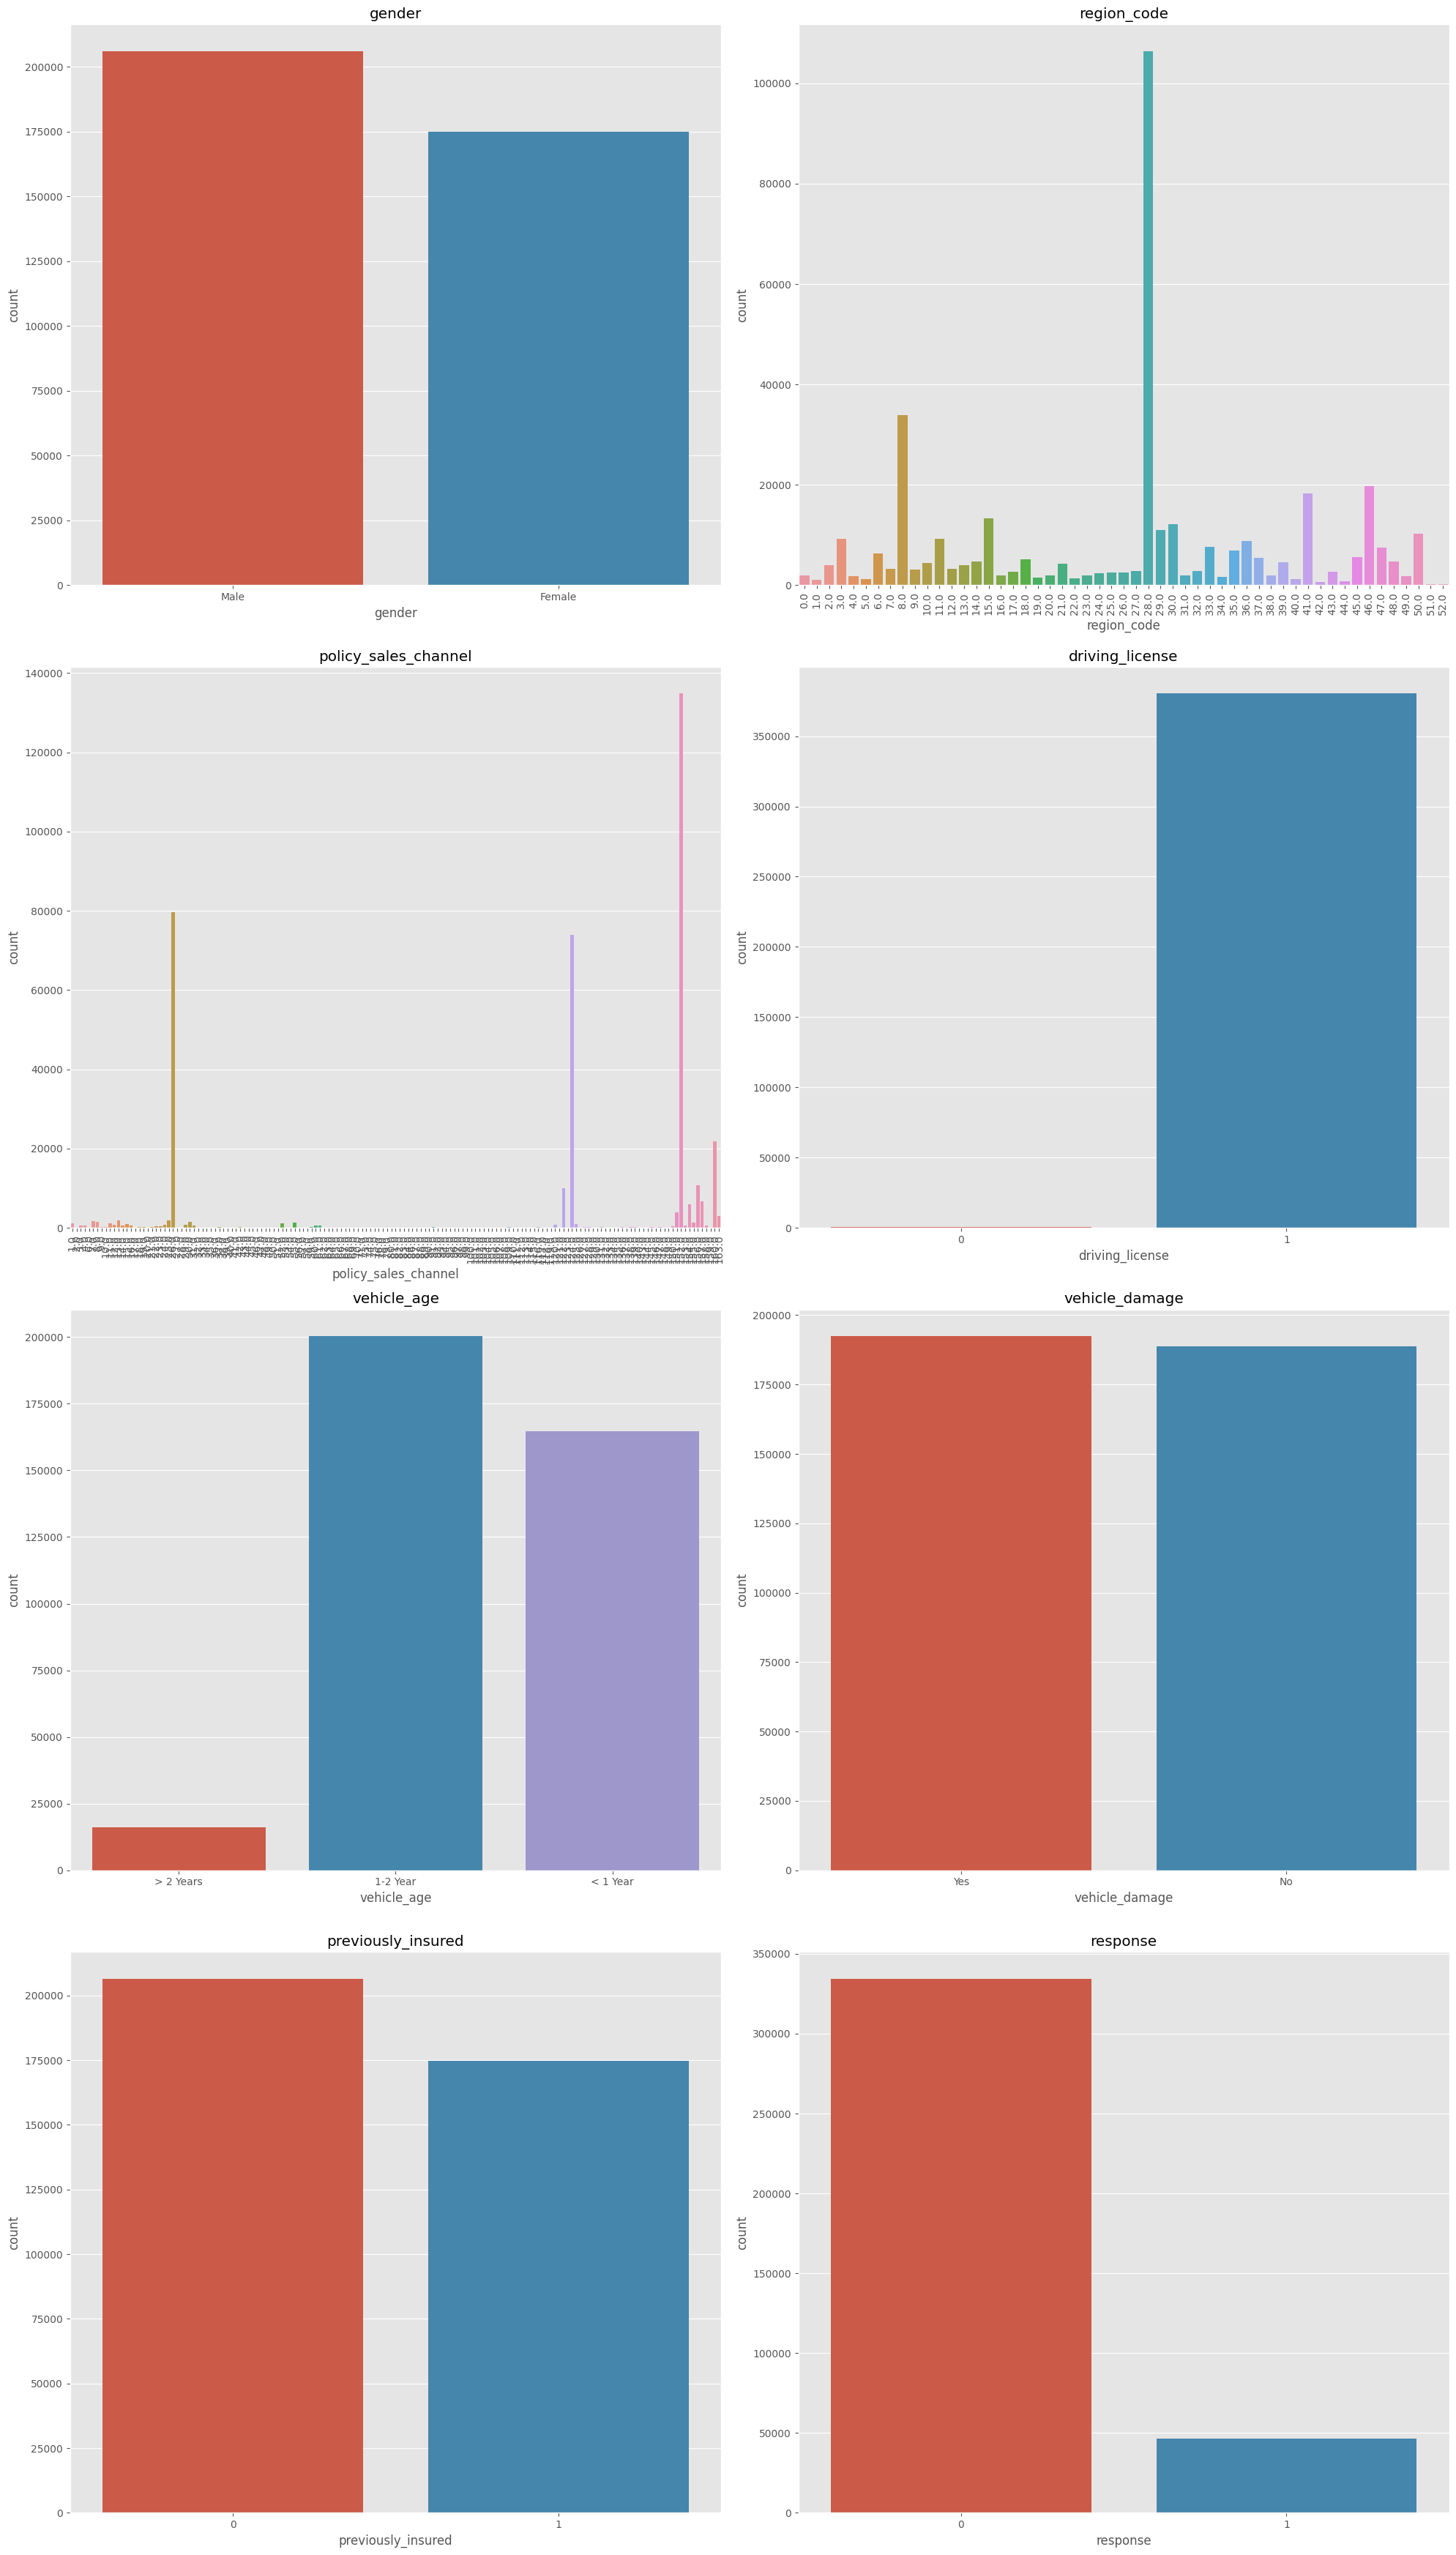

In [31]:
#quanto tem de cada categoria
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 35))

# Loop através das colunas do dataframe e plotagem dos gráficos
for i, column in enumerate(cat_attributes.columns):
    row = i // 2
    col = i % 2
    plot = sns.countplot(data=df1, x=column, ax=axes[row, col])
    axes[row, col].set_title(column)
    
    num_categories = len(df1[column].unique())
    if num_categories > 50:
        # Rotaciona as labels em 90 graus
        plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
        
# Exibição dos gráficos
plt.tight_layout()
plt.show()

## 3.6 Handling outliers

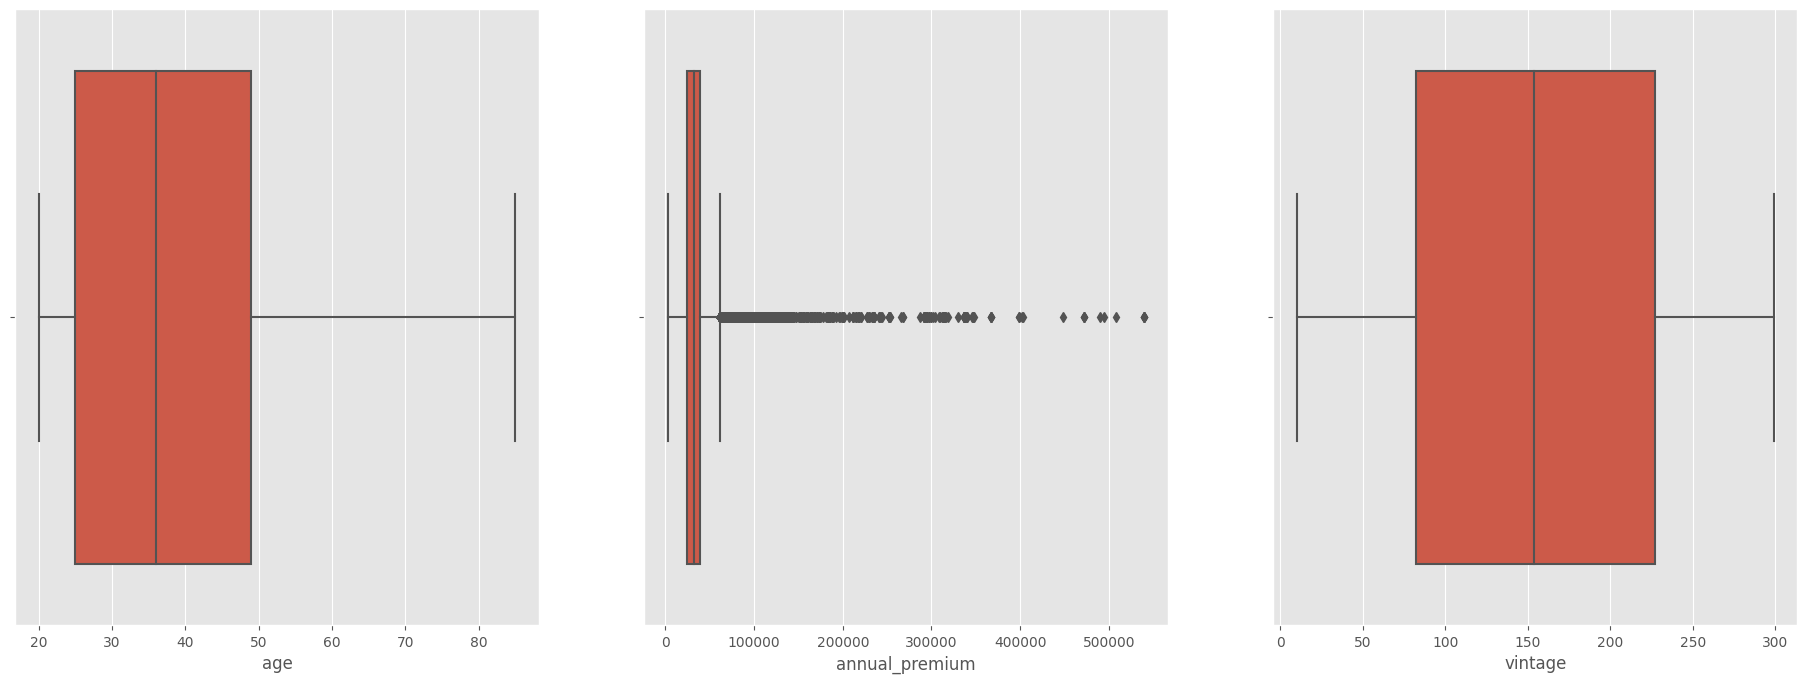

In [32]:
plt.figure(figsize=(23, 8))

plt.subplot(1, 3, 1)
sns.boxplot(data=df1, x='age')

plt.subplot(1, 3, 2)
sns.boxplot(data=df1, x='annual_premium')

plt.subplot(1, 3, 3)
sns.boxplot(data=df1, x='vintage')

plt.show()

Visually, we can see that we have outliers in 'annual_premium'. First, let's understand what this column exactly means.

* 'annual_premium': the amount customer needs to pay as premium in the year. A premium is a sum of money that the customer needs to pay regularly, in this case annualy, to an insurance company for this guarantee. 

Making some research, i checked that it is possible for a health insurer to have customers who pay different premium amounts, and the difference can be significant. This is because premiums are calculated based on a variety of factors, such as age, health history, type of plan purchased, geographic region, and more.

For example, a younger and healthier customer who purchases a basic plan may pay a much lower premium than an older and less healthy customer who purchases a more comprehensive plan. In addition, some companies may offer corporate health plans to their employees, which may have lower premiums than individual plans, or may be these records refers to someone contracting health insurance plans for all family members.

Therefore, it is normal for there to be a wide variation in premium values among the customers of a health insurer.

I will keep these outliers, but to make a better EDA, I'll create a 'annual_premium_transformed' column, in which i'll apply logarithmich transformation on 'annual_premium'.

In [33]:
df1['annual_premium_transformed'] = np.log(df1['annual_premium'])

# 4.0 Feature Engineering

## 4.1 Hypothesis mindmap

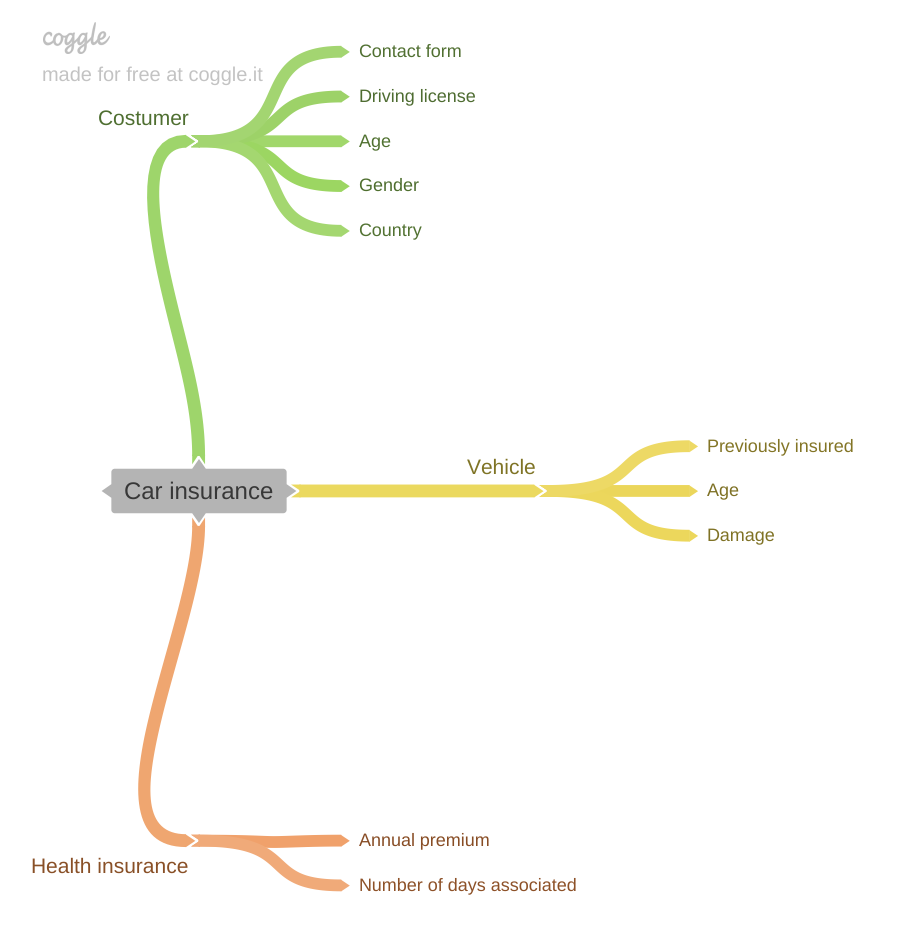

In [34]:
Image('../imgs/hypothesis_mindmap.png')

## 4.2 Hypothesis formulation

### Hypothesis relating predictor variables to response variable

<b> 1.</b> O meio de contato com o cliente influencia em sua resposta. <br>
<b> 2.</b> Mais homens respondem que tem interesse do que mulheres. <br>
<b> 3.</b> A região não influencia na resposta. <br>
<b> 4.</b> Mais de 90% dos clientes que dizem ter interesse no seguro já possuem carteira de motorista. <br>
<b> 5.</b> O público entre 20 e 30 anos demonstra mais interesse do que as outras idades. <br>
<b> 6.</b> Os clientes que não possuem seguro de carro demonstraram mais interesse do que os que já possuem. <br>
<b> 7.</b> Clientes com carro mais antigo demonstram menos interesse do que os que possuem carro mais novo. <br>
<b> 8.</b> Clientes que já possuíram o carro prejudicado no passado possuem mais interesse. <br>
<b> 9.</b> Clientes que pagam um prêmio anual maior demonstram menos interesse no seguro de carros pois provavelmente já possuem um seguro. <br>
<b> 10.</b> Clientes que estão associados a mais tempo com a empresa demonstram mais interesse, pois confiam mais. <br>

### Hypothesis relating predictor variables

<b> 1.</b> Carros mais antigos sofreram mais danos do que carros mais novos. <br>
<b> 2.</b> Clientes que pagam um prêmio anual maior possuem mais seguro do que os que pagam prêmios menores. <br>
<b> 3.</b> Clientes mais velhos pagam um prêmio anual maior.  <br>
<b> 4.</b> Clientes mais velhos estão associados a mais tempo com o seguro (já não querem tanta instabilidade) </b>

### Final list of hypothesis

<b> 1.</b> O meio de contato com o cliente influencia em sua resposta. <br>
<b> 2.</b> Mais homens respondem que tem interesse do que mulheres. <br>
<b> 3.</b> A região não influencia na resposta. <br>
<b> 4.</b> Mais de 90% dos clientes que dizem ter interesse no seguro já possuem carteira de motorista. <br>
<b> 5.</b> O público entre 20 e 30 anos demonstra mais interesse do que as outras idades. <br>
<b> 6.</b> Os clientes que não possuem seguro de carro demonstraram mais interesse do que os que já possuem. <br>
<b> 7.</b> Clientes com carro mais antigo demonstram menos interesse do que os que possuem carro mais novo. <br>
<b> 8.</b> Clientes que já possuíram o carro prejudicado no passado possuem mais interesse. <br>
<b> 9.</b> Clientes que pagam um prêmio anual maior demonstram menos interesse no seguro de carros pois provavelmente já possuem um seguro. <br>
<b> 10.</b> Clientes que estão associados a mais tempo com a empresa demonstram mais interesse, pois confiam mais. <br>
<b> 11.</b> Carros mais antigos sofreram mais danos do que carros mais novos. <br>
<b> 12.</b> Clientes que pagam um prêmio anual maior possuem mais seguro do que os que pagam prêmios menores. <br>
<b> 13.</b> Clientes mais velhos pagam um prêmio anual maior.  <br>
<b> 14.</b> Clientes mais velhos estão associados a mais tempo com o seguro (já não querem tanta instabilidade) </b>

## 4.3 Creating new features

In [35]:
df2 = df1.copy()
df2.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response,annual_premium_transformed
0,1,Male,44,28.0,26.0,1,> 2 Years,Yes,0,40454.0,217,1,10.607921
1,2,Male,76,3.0,26.0,1,1-2 Year,No,0,33536.0,183,0,10.420375
2,3,Male,47,28.0,26.0,1,> 2 Years,Yes,0,38294.0,27,1,10.553049
3,4,Male,21,11.0,152.0,1,< 1 Year,No,1,28619.0,203,0,10.261826
4,5,Female,29,41.0,152.0,1,< 1 Year,No,1,27496.0,39,0,10.221796


##### months_associated

In [36]:
df2['months_associated'] = df2.vintage.apply(lambda x: x//30)

How many months the client is associated with the health insurance service.

##### monthly_premium

In [37]:
df2['monthly_premium'] = df2.annual_premium.apply(lambda x: x//12)

How much the client pay per month to the health insurance company.

##### age_bins

In [38]:
bins = [19, 29, 39, 49, 59, 69, 79, 89]
df2['age_bins'] = pd.cut(df2['age'], bins=bins, 
                         labels=['20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89'])

Dividing age in categories.

# 5.0 EDA

In [39]:
df3 = df2.copy()

## 5.1 Univariate Analysis

### 5.1.1 Response variable

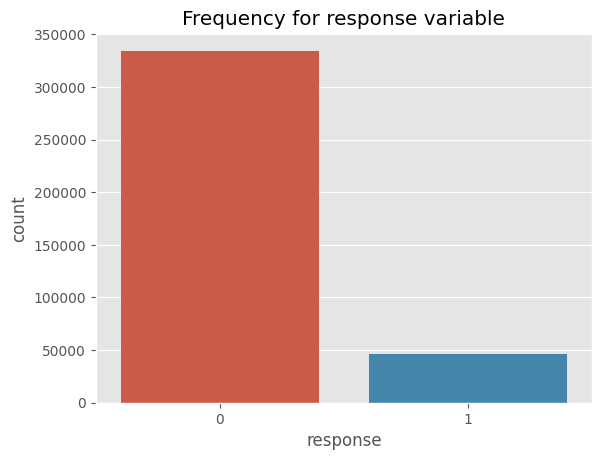

In [40]:
sns.countplot(data=df3, x='response')
plt.title("Frequency for response variable")
plt.show()

In [41]:
df3.response.value_counts(normalize=True)

0    0.877437
1    0.122563
Name: response, dtype: float64

Looking this we can see that the response variable is unbalanced. Maybe we'll have to addres it later. Furthermore, we check that most of people that answered the survey doesn't have interest on having an car insurance plan. Let's investigate why later.

### 5.1.2 Numerical variables

In [42]:
num_attributes = df3[['age', 'annual_premium', 'vintage']]

#### Histograms

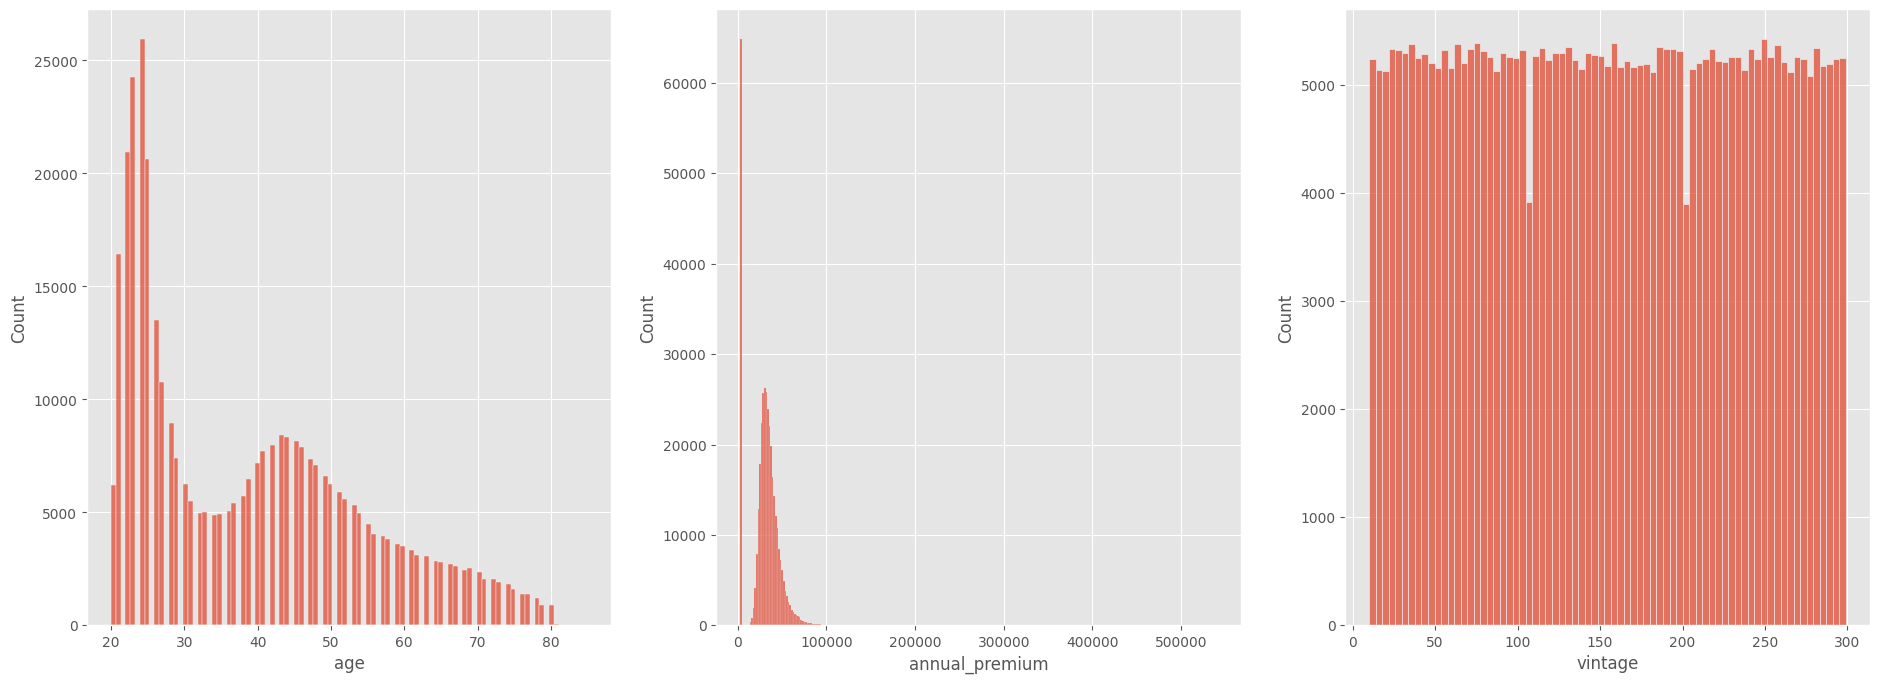

In [43]:
plt.figure(figsize=(23, 8))

plt.subplot(1, 3, 1)
sns.histplot(data=df1, x='age')

plt.subplot(1, 3, 2)
sns.histplot(data=df1, x='annual_premium', bins=300)

plt.subplot(1, 3, 3)
sns.histplot(data=df1, x='vintage')

plt.show()

###### Kdeplot

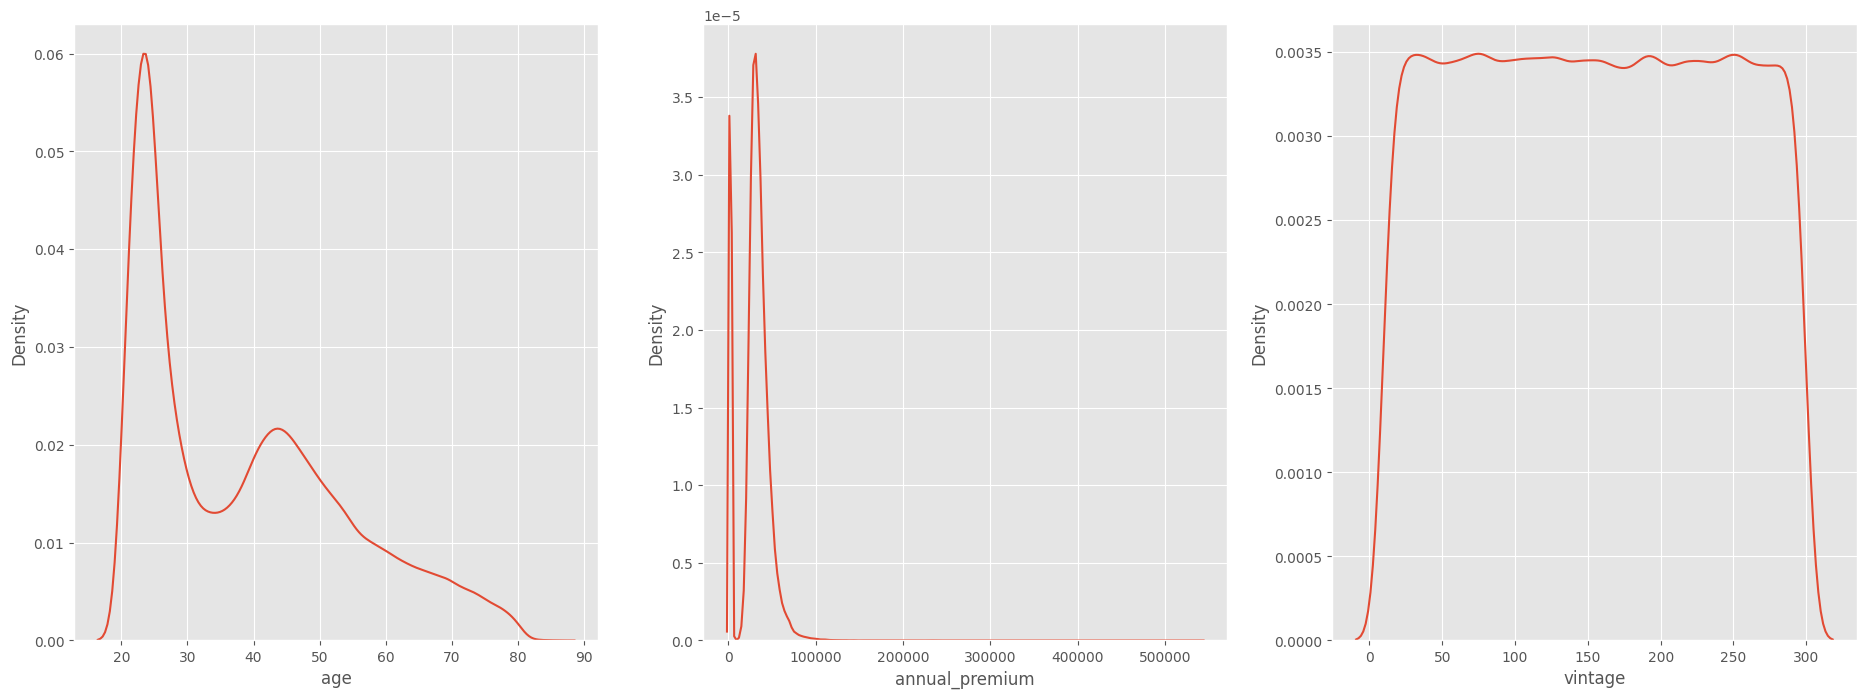

In [44]:
plt.figure(figsize=(23, 8))

plt.subplot(1, 3, 1)
sns.kdeplot(data=df1, x='age')

plt.subplot(1, 3, 2)
sns.kdeplot(data=df1, x='annual_premium')

plt.subplot(1, 3, 3)
sns.kdeplot(data=df1, x='vintage')

plt.show()

##### Boxplots

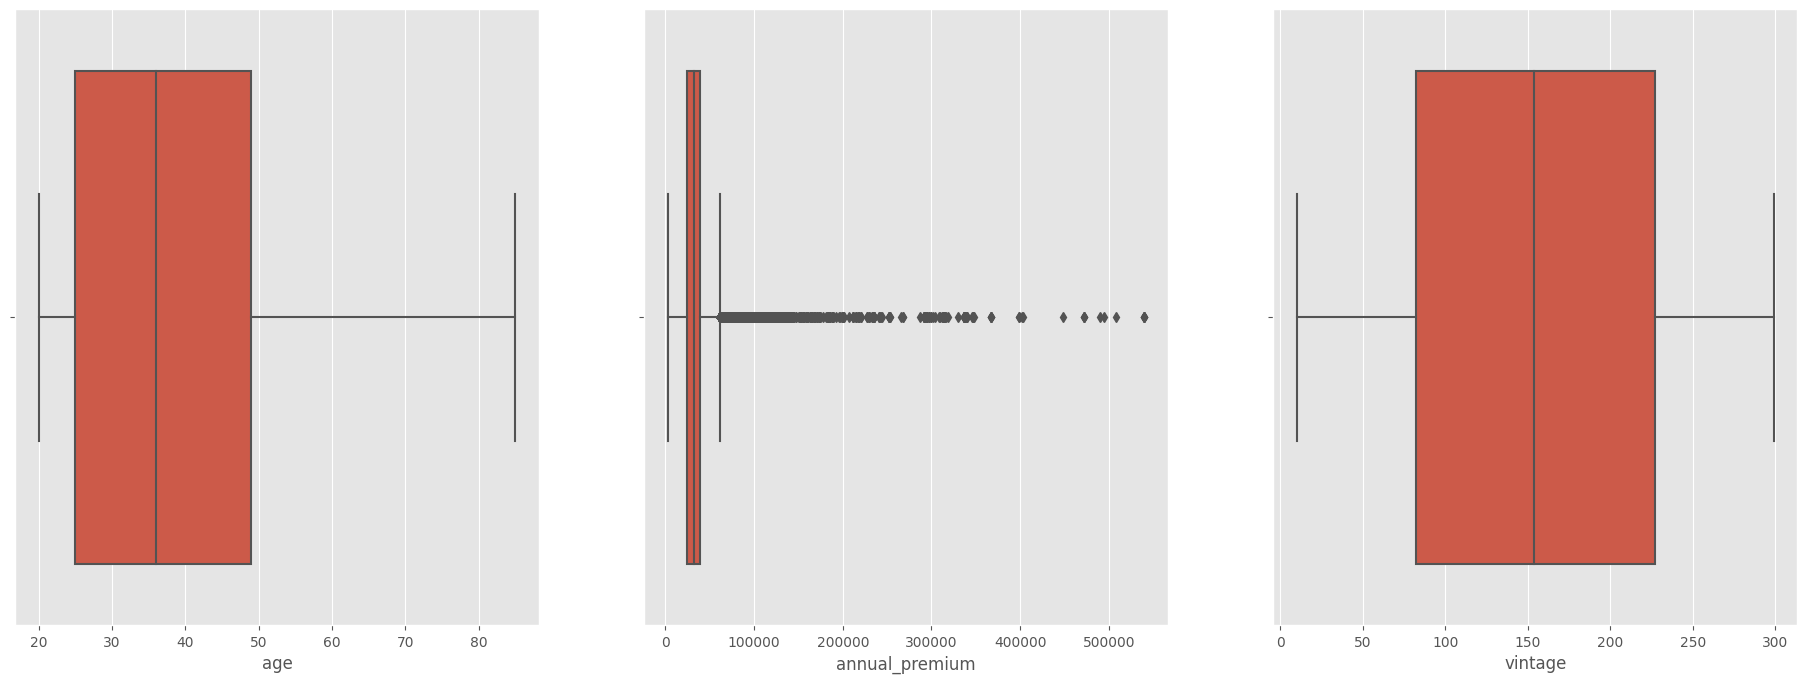

In [45]:
plt.figure(figsize=(23, 8))

plt.subplot(1, 3, 1)
sns.boxplot(data=df1, x='age')

plt.subplot(1, 3, 2)
sns.boxplot(data=df1, x='annual_premium')

plt.subplot(1, 3, 3)
sns.boxplot(data=df1, x='vintage')

plt.show()

### 5.1.3 Categorical variables

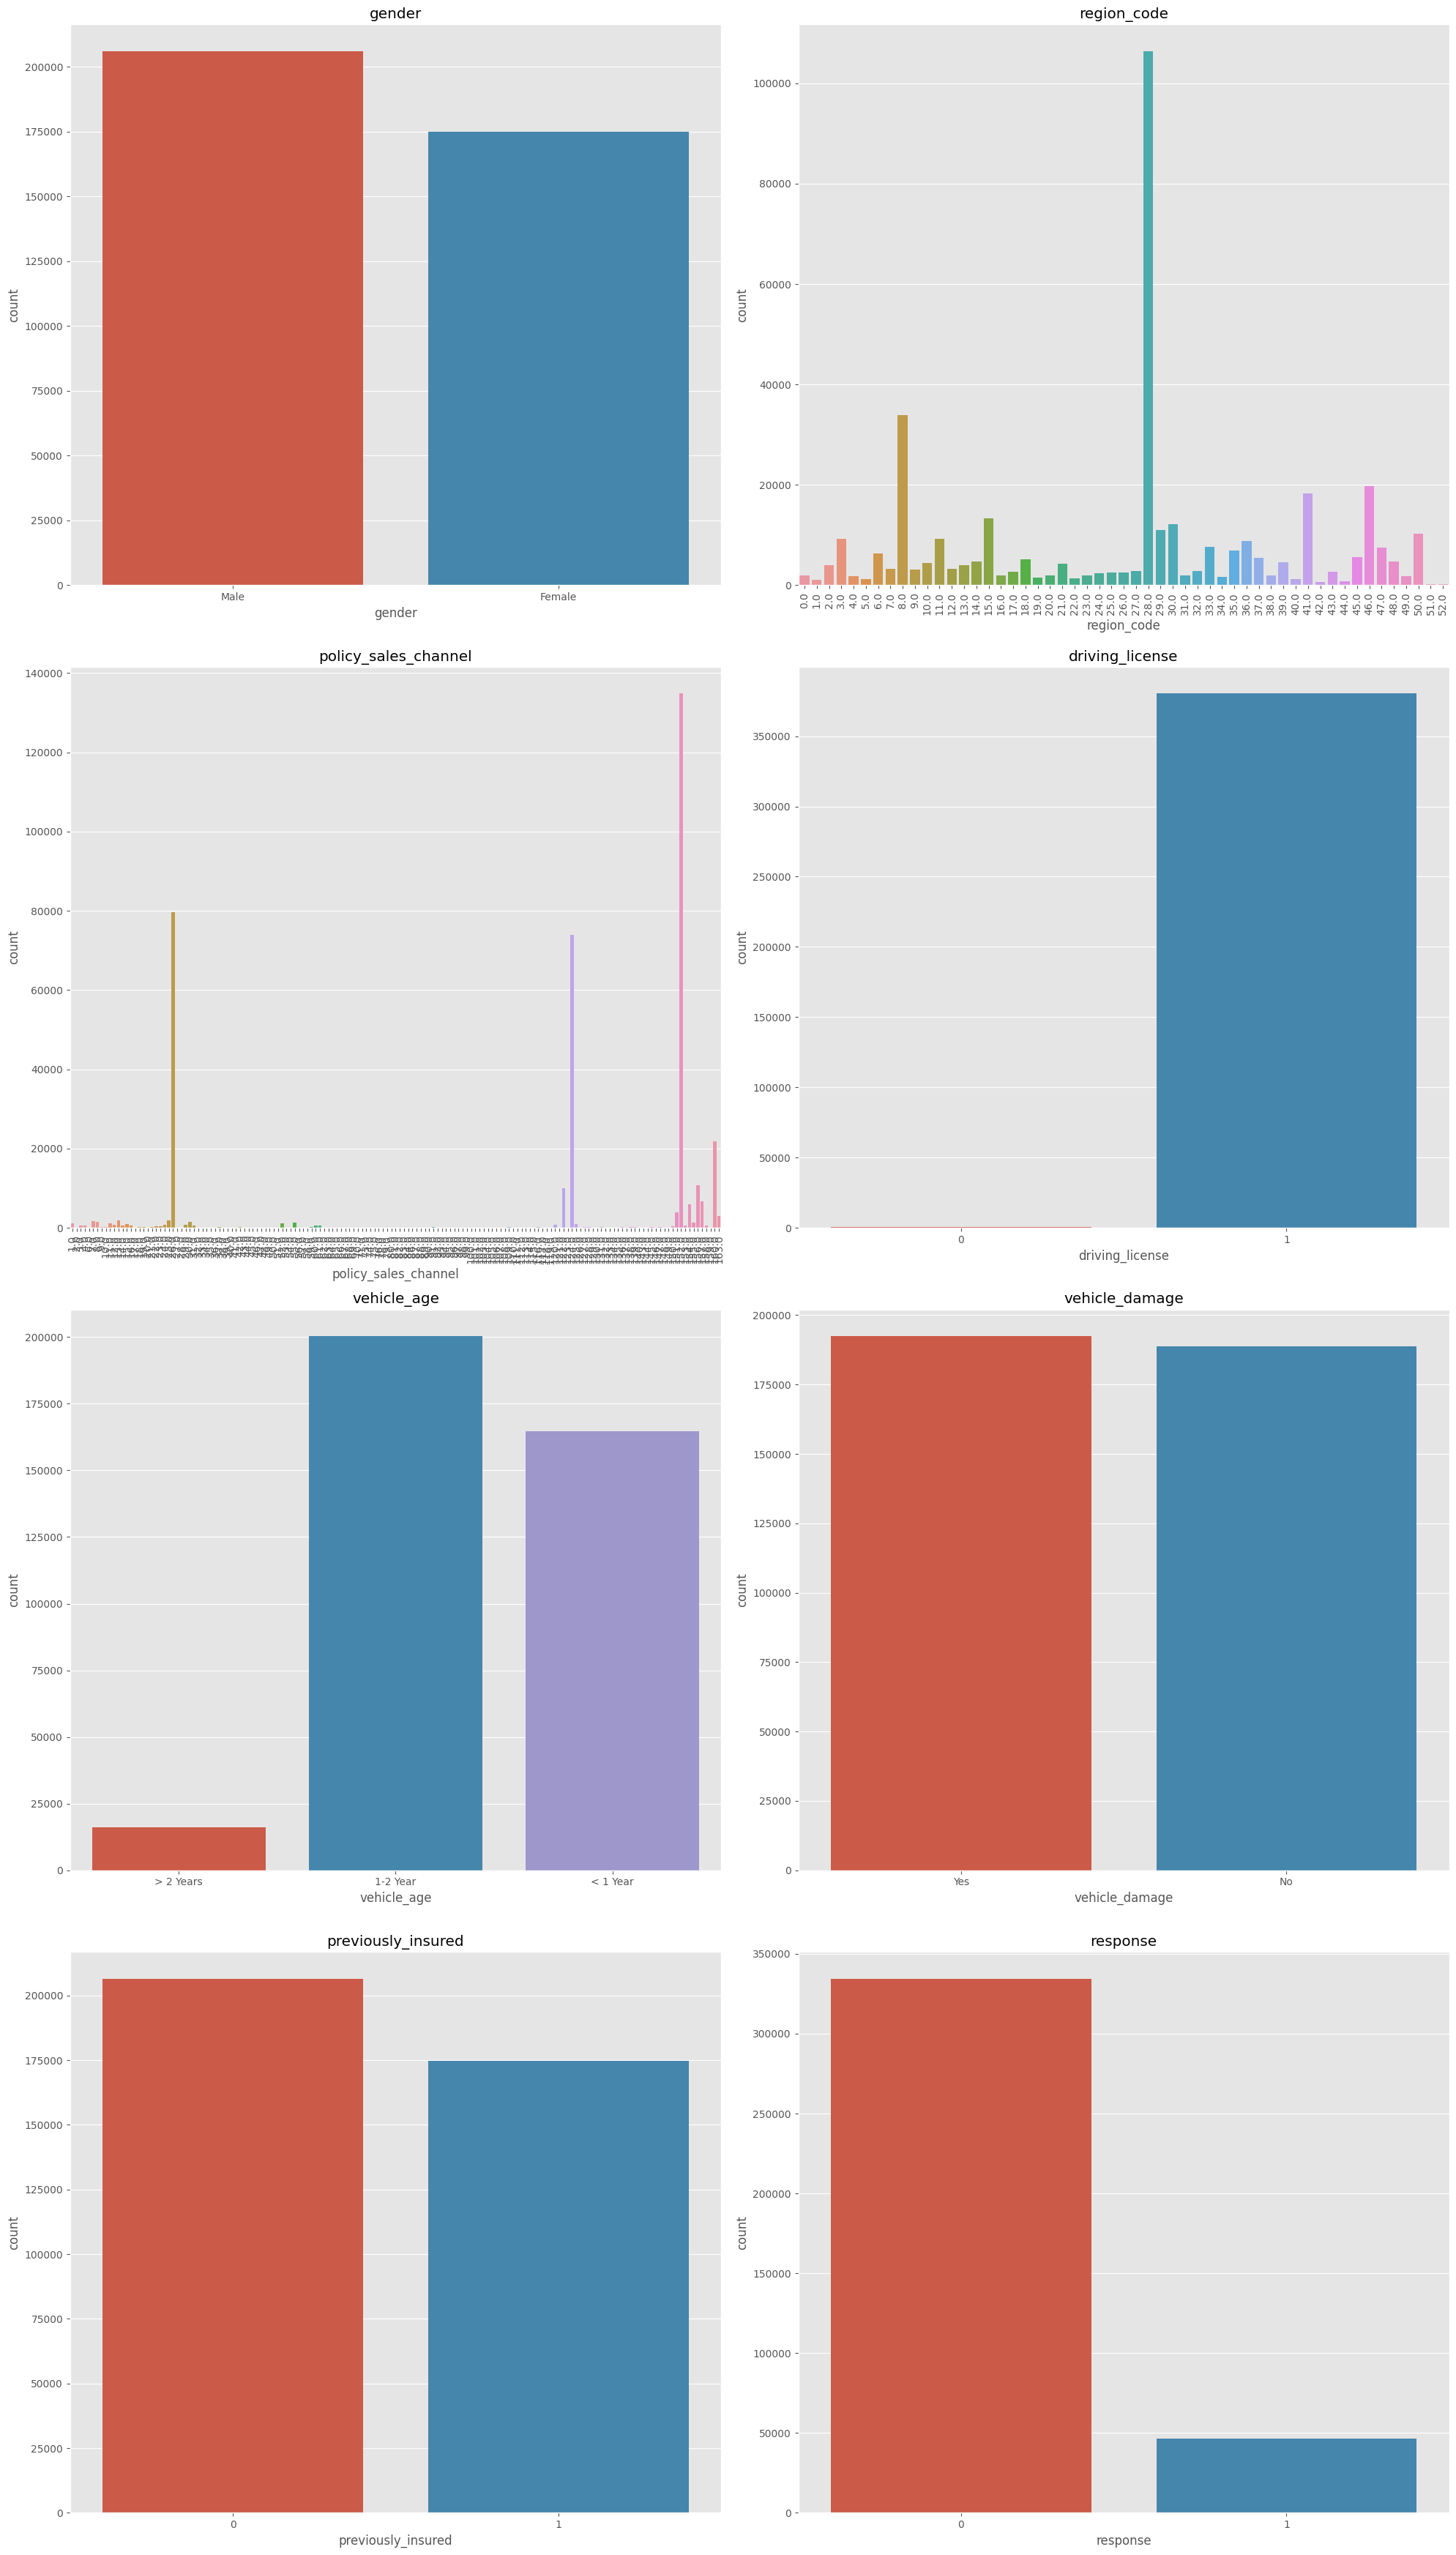

In [46]:
#quanto tem de cada categoria de acordo com a variável resposta
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 35))

# Loop através das colunas do dataframe e plotagem dos gráficos
for i, column in enumerate(cat_attributes.columns):
    row = i // 2
    col = i % 2
    plot = sns.countplot(data=df1, x=column, ax=axes[row, col])
    axes[row, col].set_title(column)
    
    num_categories = len(df1[column].unique())
    if num_categories > 50:
        # Rotaciona as labels em 90 graus
        plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
        
# Exibição dos gráficos
plt.tight_layout()
plt.show()

## 5.2 Bivariate Analysis

<b> 1.</b> O meio de contato com o cliente influencia em sua resposta. <br>
<b> 2.</b> Mais homens respondem que tem interesse do que mulheres. <br>
<b> 3.</b> A região não influencia na resposta. <br>
<b> 4.</b> Clientes mais velhos pagam um prêmio anual maior.<br>
<b> 5.</b> O público entre 20 e 30 anos demonstra mais interesse do que as outras idades. <br>
<b> 6.</b> Os clientes que não possuem seguro de carro demonstraram mais interesse do que os que já possuem. <br>
<b> 7.</b> Clientes com carro mais antigo demonstram menos interesse do que os que possuem carro mais novo. <br>
<b> 8.</b> Clientes que já possuíram o carro prejudicado no passado possuem mais interesse. <br>
<b> 9.</b> Clientes que pagam um prêmio anual maior demonstram menos interesse no seguro de carros pois provavelmente já possuem um seguro. <br>
<b> 10.</b> Clientes que estão associados a mais tempo com a empresa demonstram mais interesse, pois confiam mais. <br>
<b> 11.</b> Carros mais antigos sofreram mais danos do que carros mais novos. <br>
<b> 12.</b> Clientes que pagam um prêmio anual maior possuem mais seguro do que os que pagam prêmios menores. <br>
<b> 13.</b> Mais de 90% dos clientes que dizem ter interesse no seguro já possuem carteira de motorista.  <br>
<b> 14.</b> Clientes mais velhos estão associados a mais tempo com o seguro (já não querem tanta instabilidade) </b>

### H1. O meio de contato com o cliente influencia em sua resposta.
**VERDADEIRA** Existe uma relação estatisticamente significativa entre o meio de contato e a resposta do cliente.

In [47]:
contingency_table = pd.crosstab(df3['policy_sales_channel'], df3['response'])

In [48]:
#getting only rows that has at least five observations in each cell
index = set()

for i in range(contingency_table.shape[0]):
    values = contingency_table.iloc[i].values
    if values[0] >= 5 and values[1] >= 5:
        index.add(i)
        
index = list(index)

contingency_table = contingency_table.iloc[index]

In [49]:
stat, p, dof, expected = chi2_contingency(contingency_table)

print(f'P-value: {p:.3f}')

if p < 0.05:
    print('There is a significant association between contact method and response.')
else:
    print('There is no significant association between contact method and response.')

P-value: 0.000
There is a significant association between contact method and response.


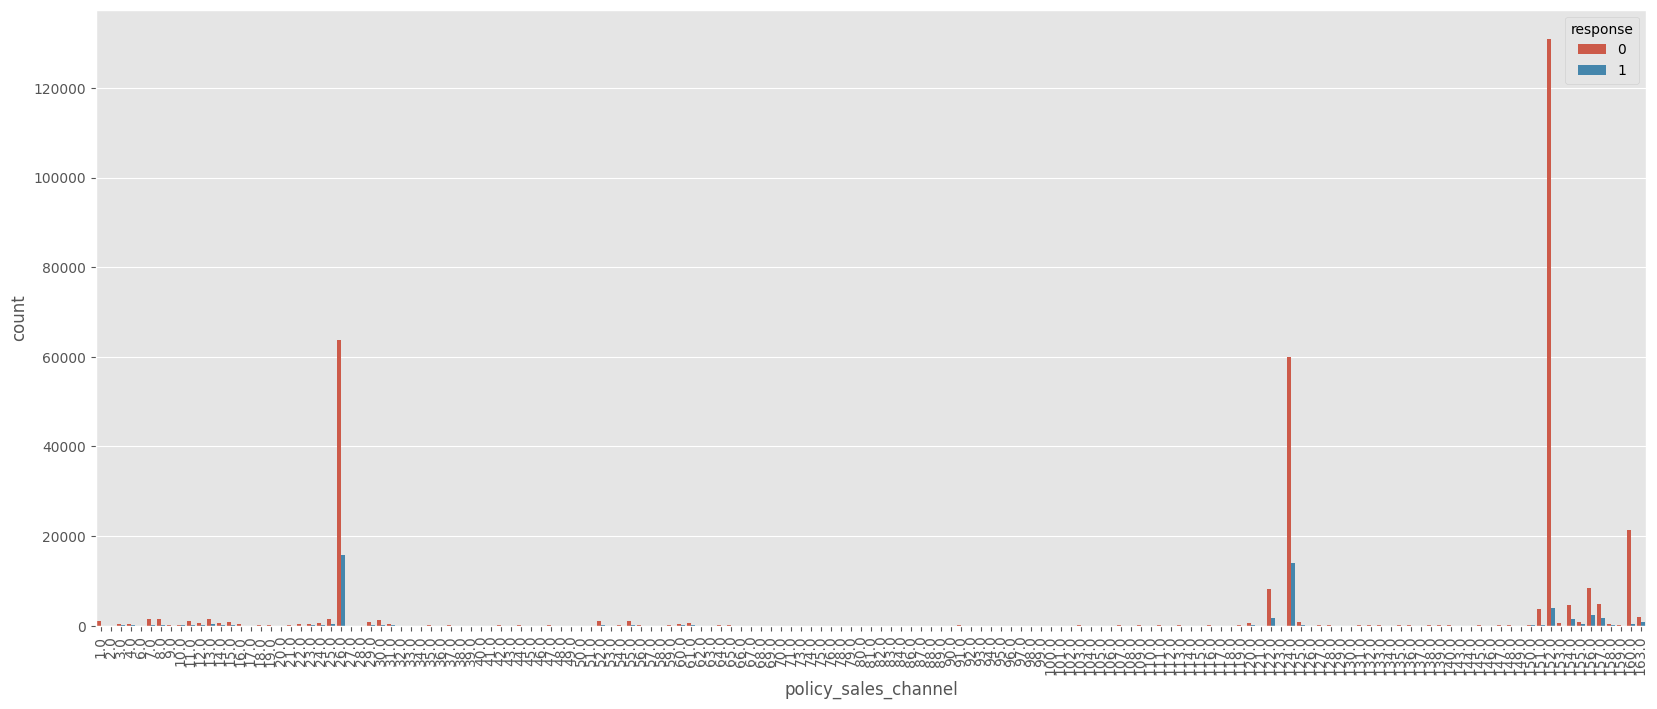

In [50]:
plt.figure(figsize=(20, 8))
sns.countplot(df3, x='policy_sales_channel', hue='response')
plt.xticks(rotation=90)
plt.show()

### H2. Mais homens respondem que tem interesse do que mulheres.
**VERDADEIRA** Proporcionalmente, homens respondem mais 'sim' do que mulheres, apesar dessa diferença ser pequena. 

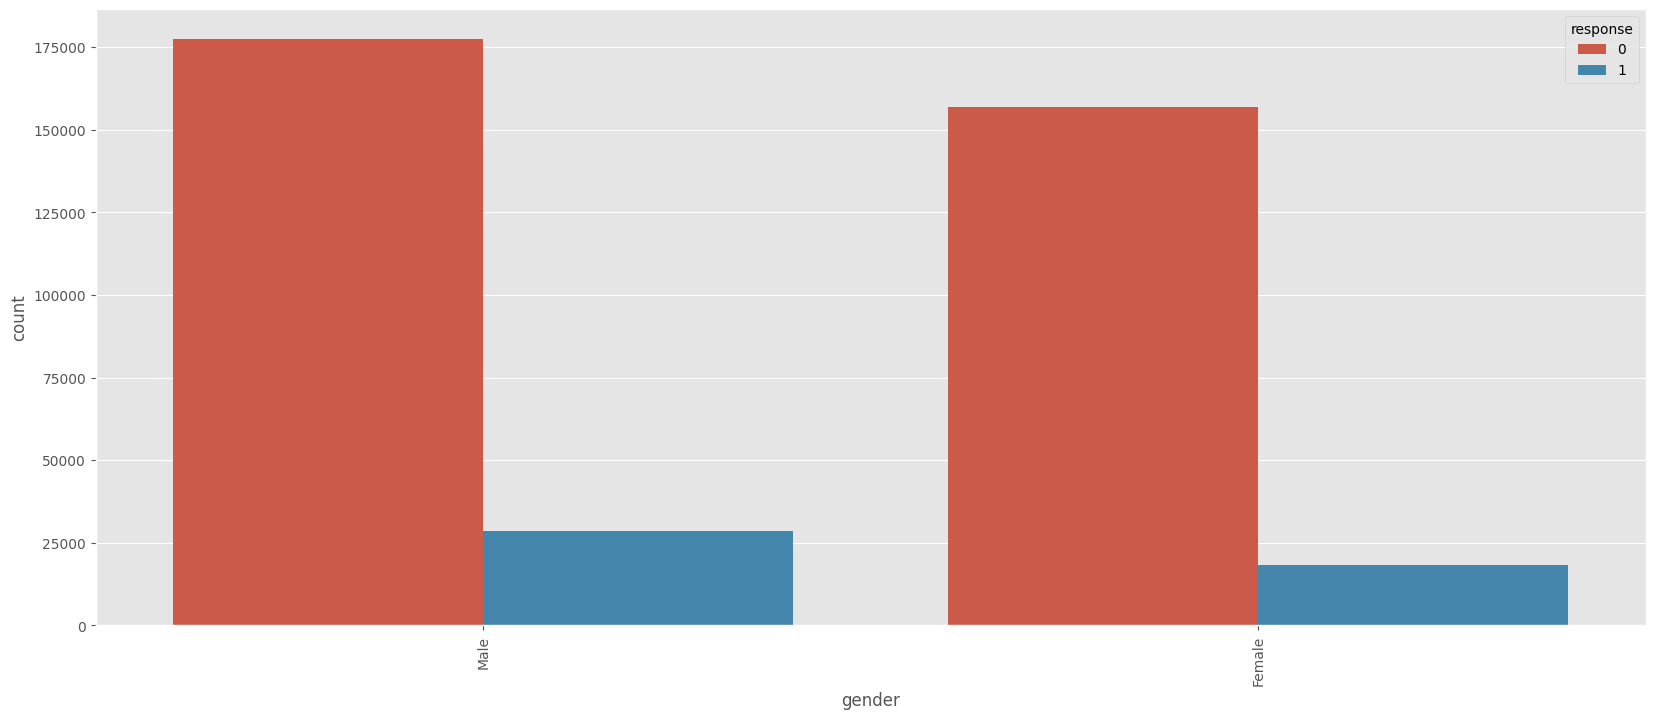

In [51]:
countplot(df3, 'gender', 'response')

Apearently, doesn't have any relationship between gender and the interest in car insurance services.

Let's check the proportion of '1' responses for each gender.

In [52]:
gender_response = pd.DataFrame()
gender_response['male'] = df3[df3['gender'] == 'Male'].response.value_counts(normalize=True)
gender_response['female'] = df3[df3['gender'] == 'Female'].response.value_counts(normalize=True)

gender_response

,male,female
0,0.861589,0.896098
1,0.138411,0.103902


We see that, proportionally, mens answers more '1' than woman. But, the difference between these proportions is very small, so, despite that there are a relation between gender and response, it's very weak.

Let's make some hypothesis test to validate our thoughts.

In [53]:
stat, p, dof, expected = chi2(df3, 'gender', 'response')

print(f'P-value: {p}')
if p < 0.05:
    print('There is a statistically significant relation between gender and response.')
else:
    print('There is no statistically significant relation between gender and response.')

print("Cramer'v: ", cramer_v(df3, 'gender', 'response'))

P-value: 7.665800628415621e-230
There is a statistically significant relation between gender and response.
Cramer'v:  0.05243195443576884


Beside the fact that we have and relation between gender and response, this association is very weak and doesn't matter that much.

### H3. A região não influencia na resposta. 
**FALSA** A região influencia na resposta de interesse em seguro de veículos.

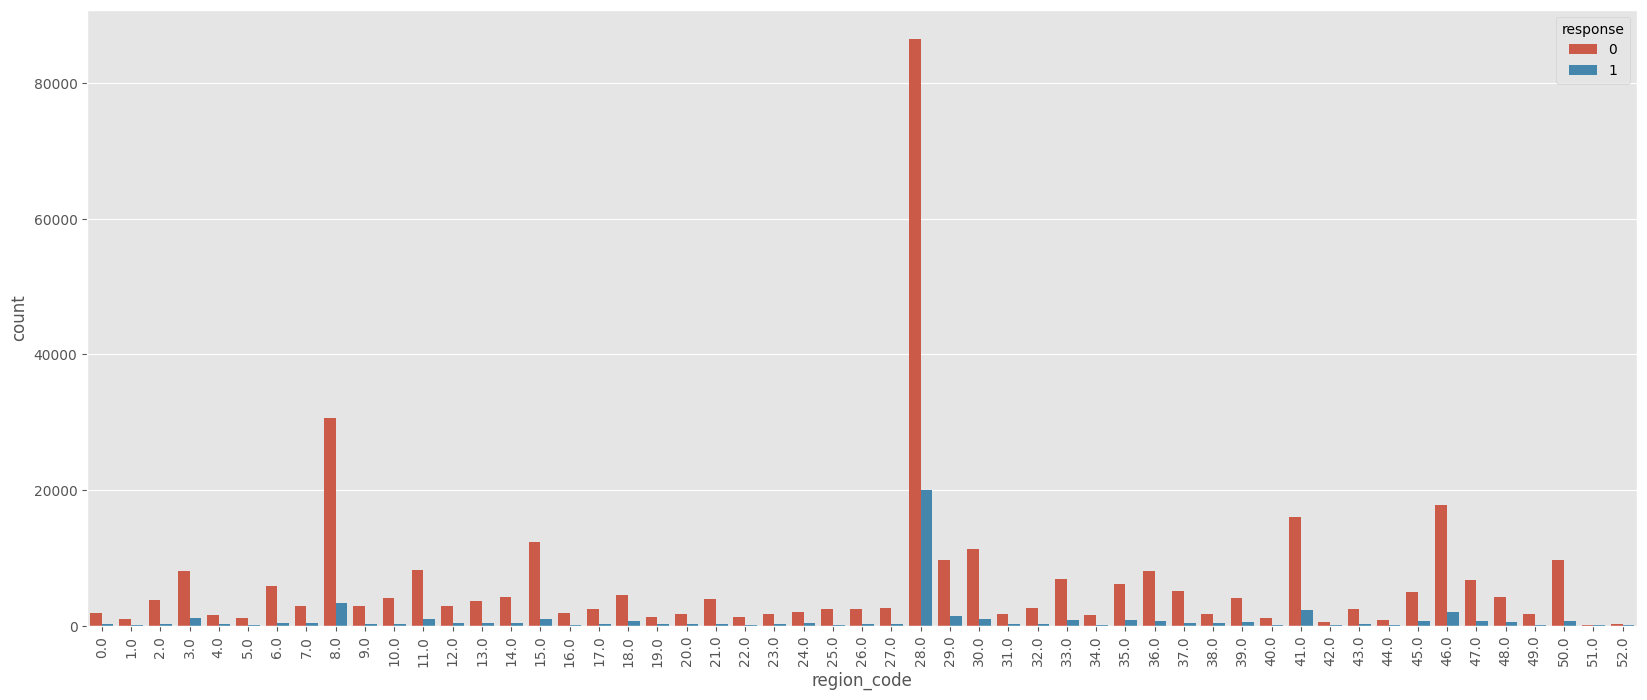

In [54]:
countplot(df3, 'region_code', 'response')

Visually we can't conclude so much. Let's see the proportion of answers for each region_code.

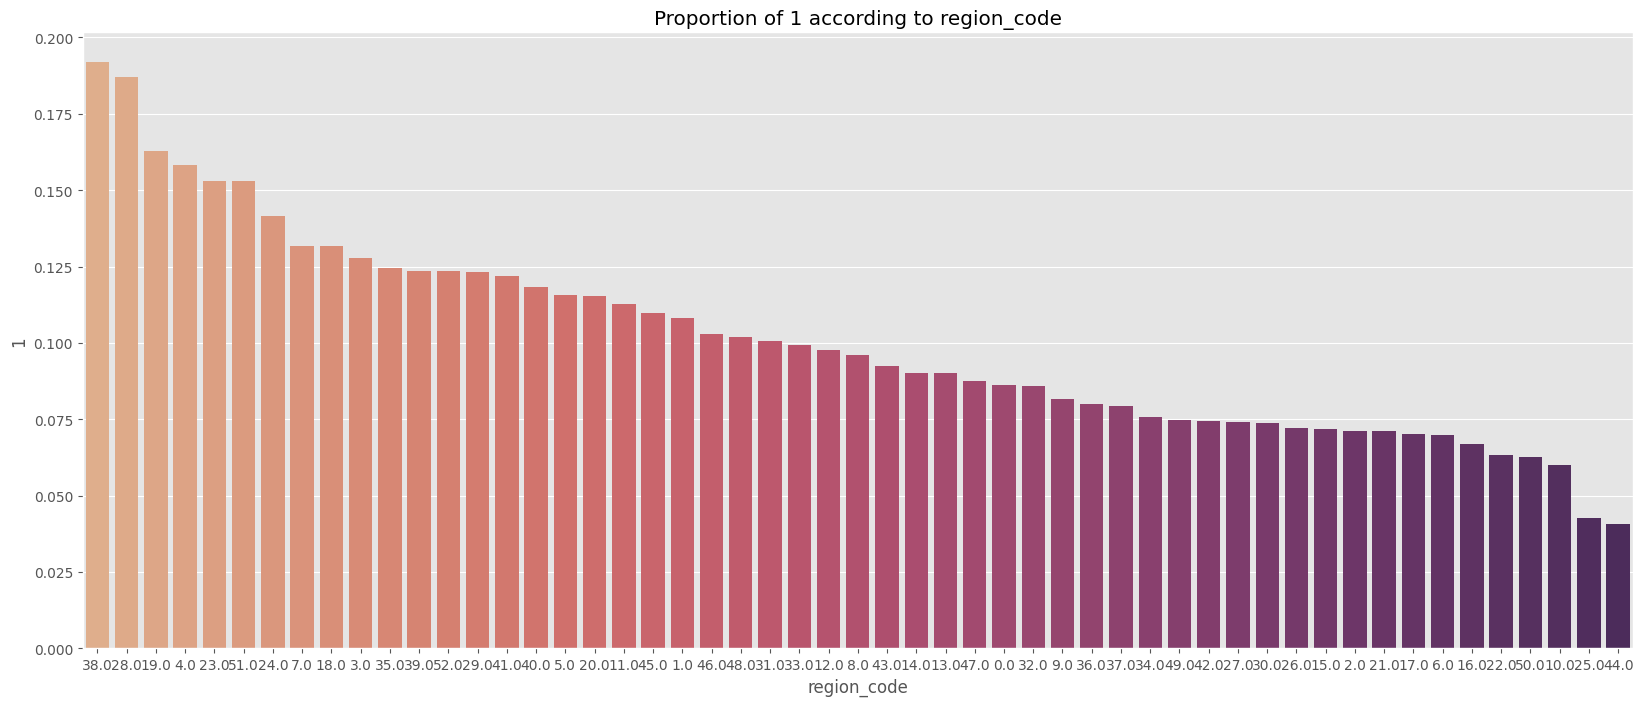

In [55]:
grouped_region_code = get_proportion_by_category('region_code')

plot_proportion_by_category(grouped_region_code, 'region_code')

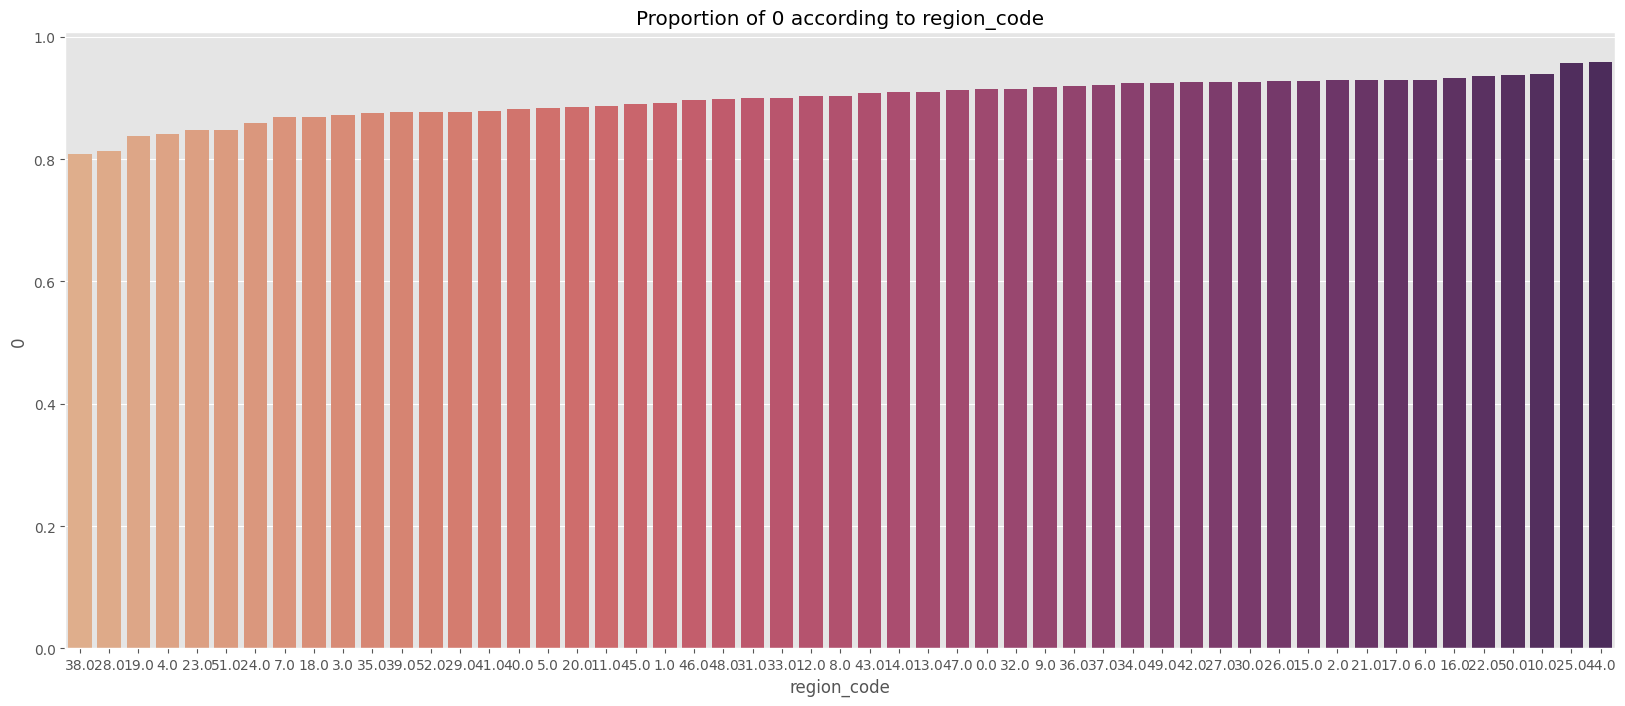

In [56]:
plot_proportion_by_category(grouped_region_code, 'region_code', 0)

With this graph, that shows proportion of 1 for each region code we can see that this proportion differs from one region code to another. In some cases, the proportion in X is the double, or even the triple, than in Y. So, seems that the region code and the response are related to.

To check that, let's make an hypothesis test.

In [57]:
stat, p, dof, expected = chi2(df3, 'region_code', 'response')

print(f'P-value: {p}')
if p < 0.05:
    print('There is a statistically significant relation between region code and response.')
else:
    print('There is no statistically significant relation between region code and response.')

print("Cramer'v: ", cramer_v(df3, 'region_code', 'response'))

P-value: 0.0
There is a statistically significant relation between region code and response.
Cramer'v:  0.13809524215806745


### H4. Clientes mais velhos pagam um prêmio anual maior. 
**VERDADEIRA** Clientes mais velhos pagam um prêmio anual maior.

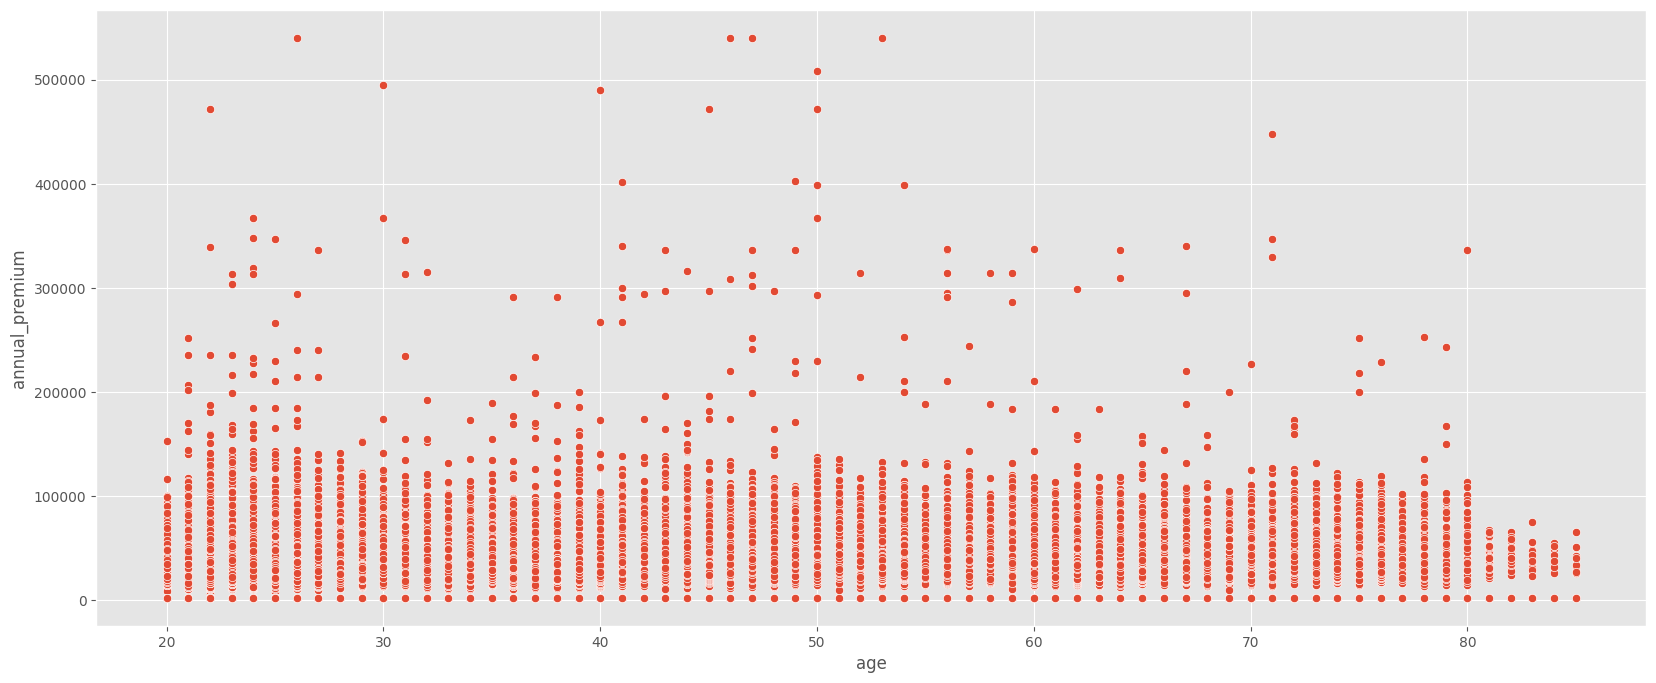

In [58]:
scatterplot(df3, 'age', 'annual_premium')

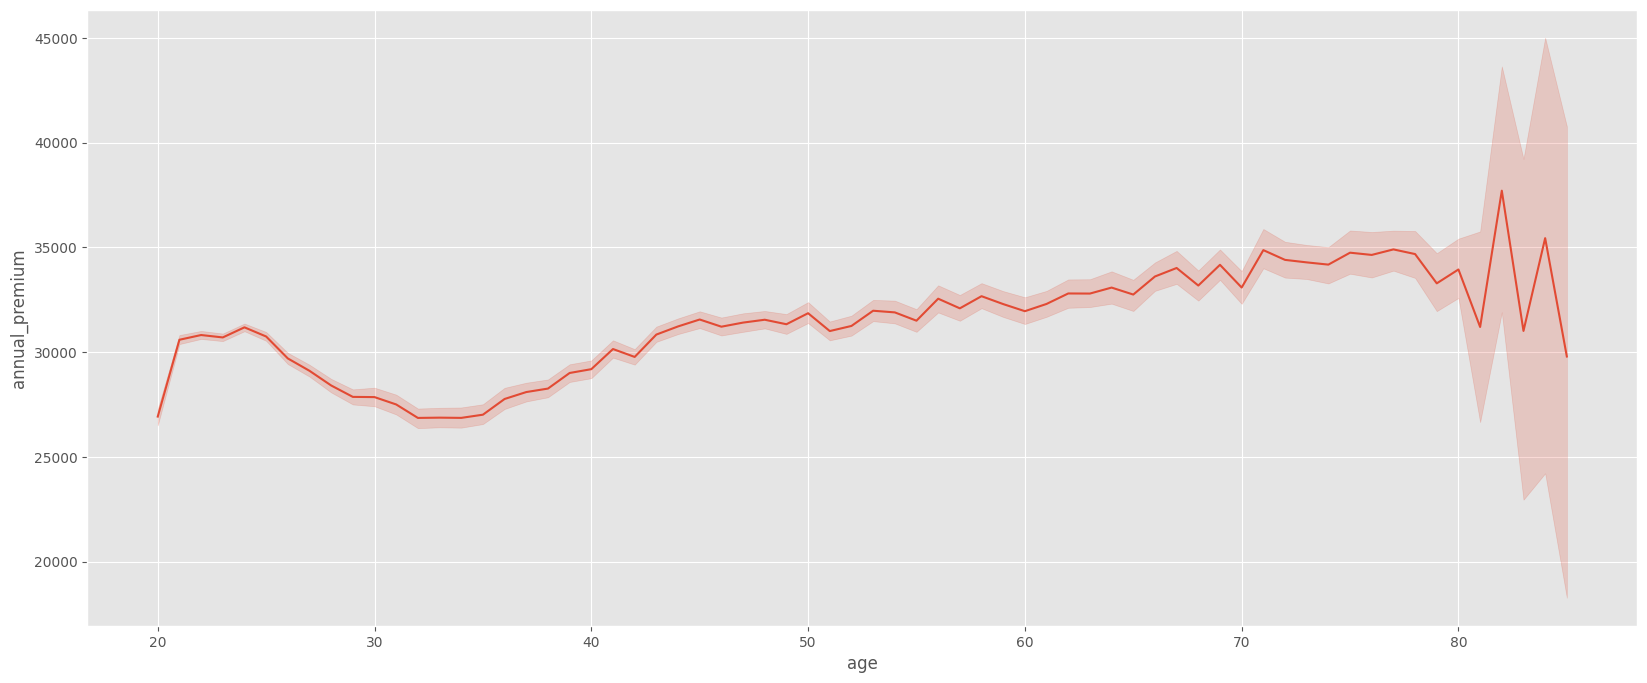

In [59]:
plt.figure(figsize=(20,8))
sns.lineplot(df3, x='age', y='annual_premium')
plt.show()

In [60]:
grouped = df3.groupby('age_bins')['annual_premium']
grouped.describe()

,count,mean,std,min,25%,50%,75%,max
age_bins,,,,,,,,
20-29,155203.0,30174.882876,14939.172358,2630.0,24728.0,30565.0,37188.00,540165.0
30-39,54253.0,27666.887490,17481.946706,2630.0,20100.0,29946.0,37362.00,495106.0
40-49,76846.0,30824.520522,18107.832257,2630.0,24689.0,32741.0,40600.75,540165.0
50-59,48034.0,31841.764604,19296.148975,2630.0,24833.0,33843.0,42409.00,540165.0
60-69,29023.0,32999.416497,19200.952536,2630.0,25501.0,34669.0,44044.50,340439.0
70-79,16712.0,34289.866443,19710.550726,2630.0,26486.5,35218.5,44925.25,448156.0
80-89,1038.0,33812.347784,20831.356984,2630.0,26327.5,33814.0,44696.25,336395.0


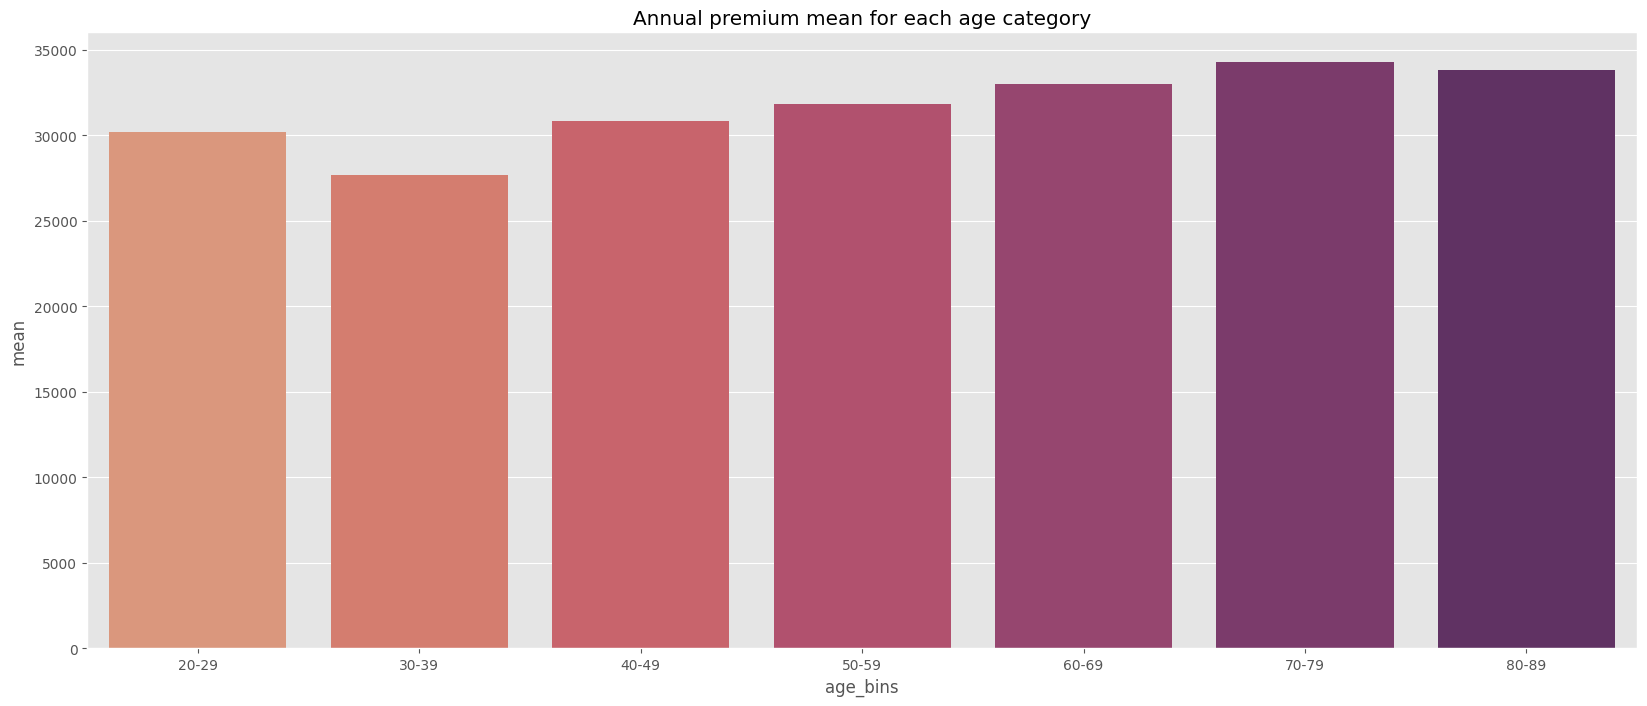

In [61]:
age_bins_means = grouped.describe().reset_index()[['age_bins', 'mean']]

plt.figure(figsize=(20, 8))
sns.barplot(age_bins_means, x='age_bins', y='mean', palette='flare')
plt.title('Annual premium mean for each age category')
plt.show()

Analysing the means for each age category, we have a slighly increase in annual_premium for older groups. But it isn't a clear relation, because we also see that for people between 20-29 years the mean is almost the same for people between 40-49.

In [62]:
# Perform the ANOVA test
result = f_oneway(df3[df3['age_bins'] == '20-29']['annual_premium'],
                  df3[df3['age_bins'] == '30-39']['annual_premium'],
                  df3[df3['age_bins'] == '40-49']['annual_premium'],
                  df3[df3['age_bins'] == '50-59']['annual_premium'],
                  df3[df3['age_bins'] == '60-69']['annual_premium'],
                  df3[df3['age_bins'] == '70-79']['annual_premium'],
                  df3[df3['age_bins'] == '80-89']['annual_premium'])

# Print the result of the test
stats, p = result

print(p)
if p < 0.05:
    print('There is a statistically significant difference between the means of the different age groups.')
else:
    print('There is no statistically significant difference between the means of the different age groups.')

0.0
There is a statistically significant difference between the means of the different age groups.


The ANOVA test only tells us whether there is a statistically significant difference in mean annual premiums between at least two age categories, but it does not tell us which specific age categories have higher means.

But, looking at the histogram comparing the means, we can conclude that higher ages pay higher premiums.

#### future

To determine which specific age categories have higher means, you can perform post-hoc tests. Post-hoc tests allow you to compare the means of all possible pairs of age categories and determine which pairs are significantly different from each other.

In [63]:
model = ols('annual_premium ~ C(age_bins)', data=df3).fit()

# Perform Tukey's HSD test
tukey = sm.stats.multicomp.pairwise_tukeyhsd(endog=df3['annual_premium'], groups=df3['age_bins'], alpha=0.05)

# Print the results of the test
print(tukey.summary())

    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
group1 group2  meandiff  p-adj    lower      upper    reject
------------------------------------------------------------
 20-29  30-39 -2507.9954    0.0 -2760.0153 -2255.9755   True
 20-29  40-49   649.6376    0.0   426.7533    872.522   True
 20-29  50-59  1666.8817    0.0  1403.0498  1930.7137   True
 20-29  60-69  2824.5336    0.0  2501.3833   3147.684   True
 20-29  70-79  4114.9836    0.0  3703.6037  4526.3634   True
 20-29  80-89  3637.4649    0.0  2063.8474  5211.0824   True
 30-39  40-49   3157.633    0.0  2874.2802  3440.9859   True
 30-39  50-59  4174.8771    0.0  3858.3038  4491.4505   True
 30-39  60-69   5332.529    0.0  4965.0544  5700.0036   True
 30-39  70-79   6622.979    0.0  6175.9389   7070.019   True
 30-39  80-89  6145.4603    0.0  4562.1462  7728.7743   True
 40-49  50-59  1017.2441    0.0   723.3358  1311.1524   True
 40-49  60-69   2174.896    0.0  1826.7567  2523.0353   True
 40-49  70-79  3465.3459

### H5. O público entre 20 e 30 anos demonstra mais interesse do que as outras idades.
**FALSA** O público entre 20 e 30 anos é o que demonstra menos interesse. O grupo entre 40 e 49 é o mais interessado.

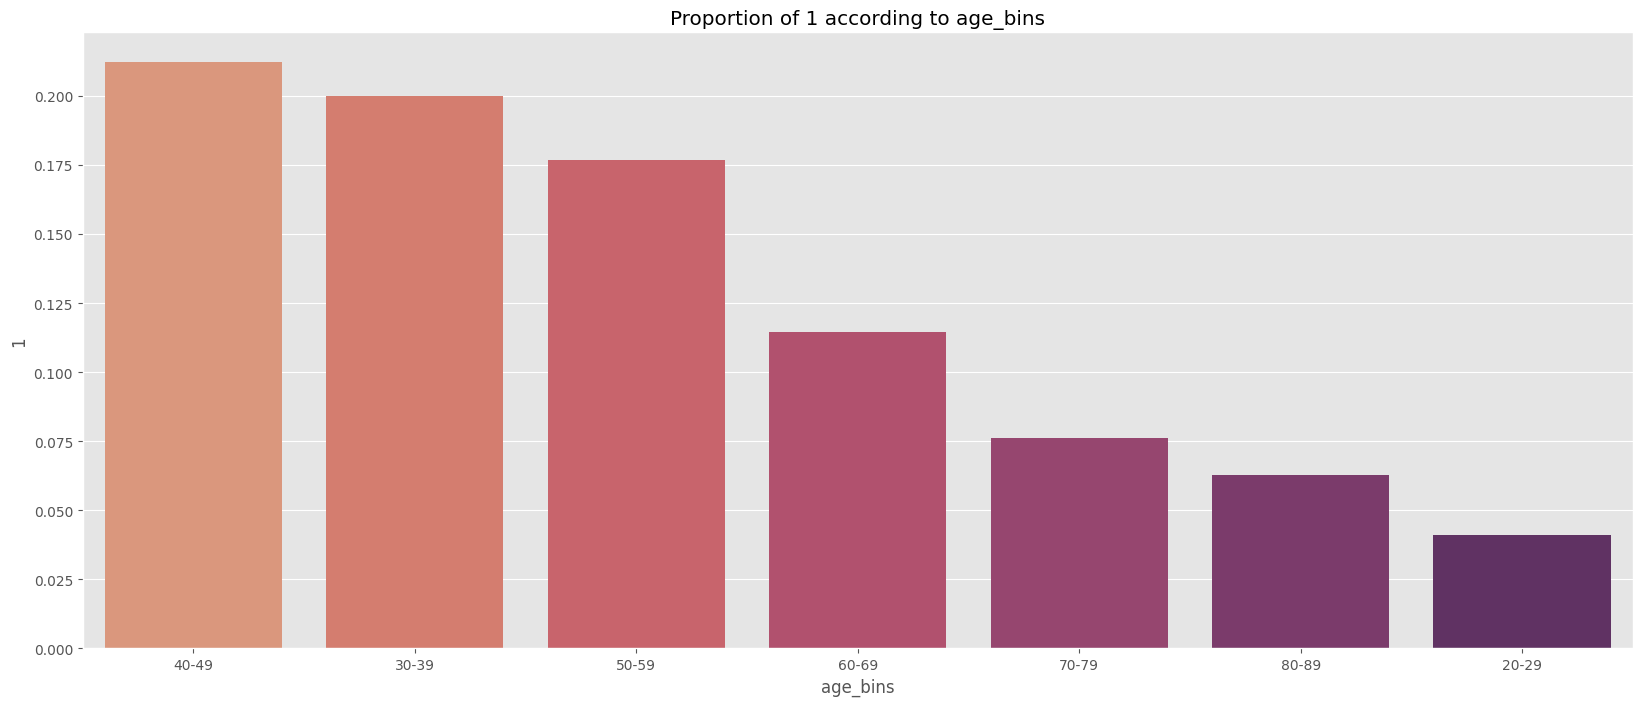

In [64]:
grouped_age_bins = get_proportion_by_category('age_bins')
plot_proportion_by_category(grouped_age_bins, 'age_bins')

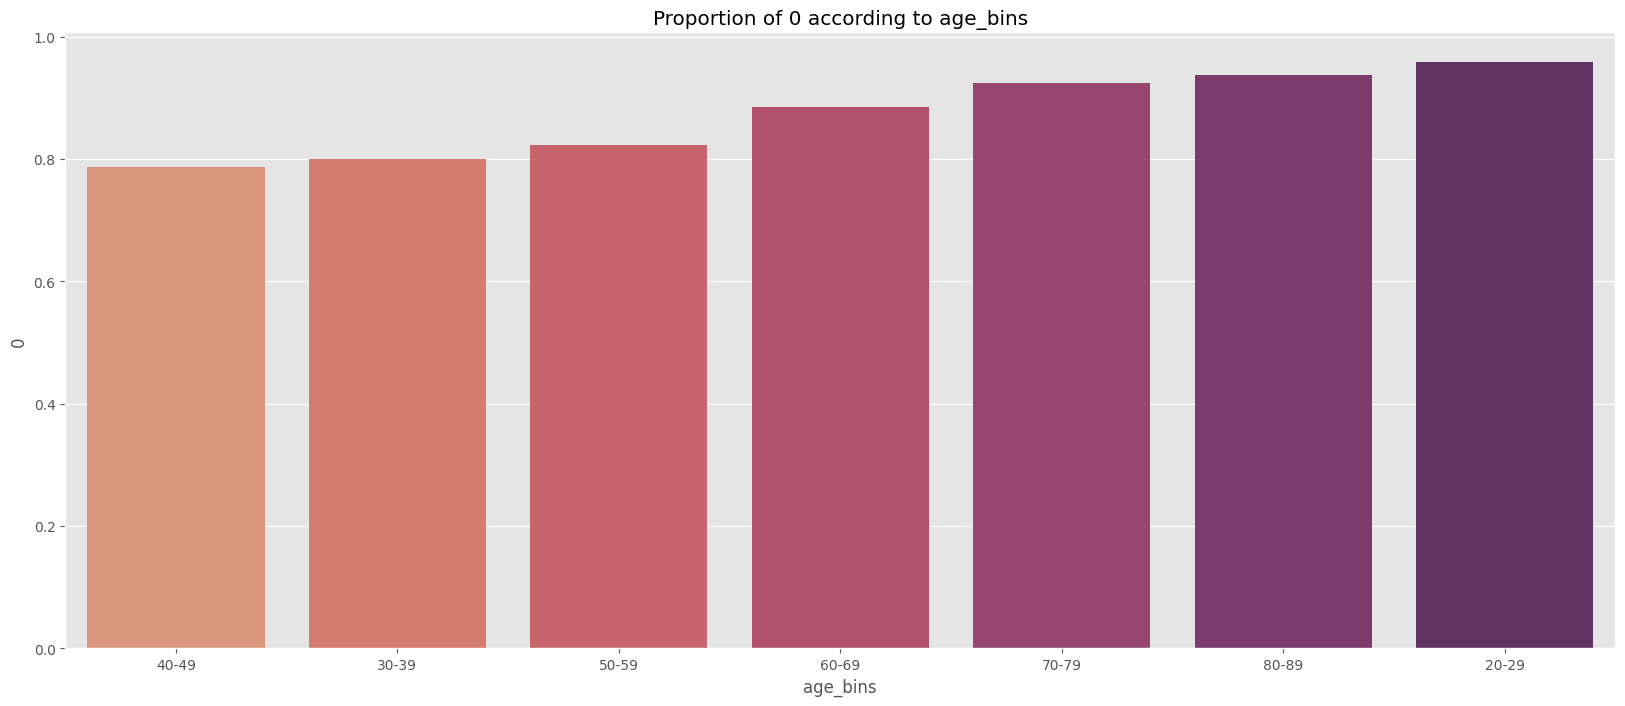

In [65]:
plot_proportion_by_category(grouped_age_bins, 'age_bins', 0)

In [66]:
stat, p, dof, expected = chi2(df3, 'age_bins', 'response')

print(f'P-value: {p}')
if p < 0.05:
    print('There is a statistically significant relation between age category and response.')
else:
    print('There is no statistically significant relation between age category and response.')

print("Cramer'v: ", cramer_v(df3, 'age_bins', 'response'))

P-value: 0.0
There is a statistically significant relation between age category and response.
Cramer'v:  0.22955996250581917


With the graph and the hypothesis test, we can conclude the groups that manifested more interest are 40-49, 30-39 and 50-59. Actually, 20-29 group is the least interested in vehicle insurance car.

### H6. Os clientes que não possuem seguro de carro demonstraram mais interesse do que os que já possuem.
**VERDADEIRA** Os clientes que não possuem seguro de carro demonstraram mais interesse do que os que já possuem.

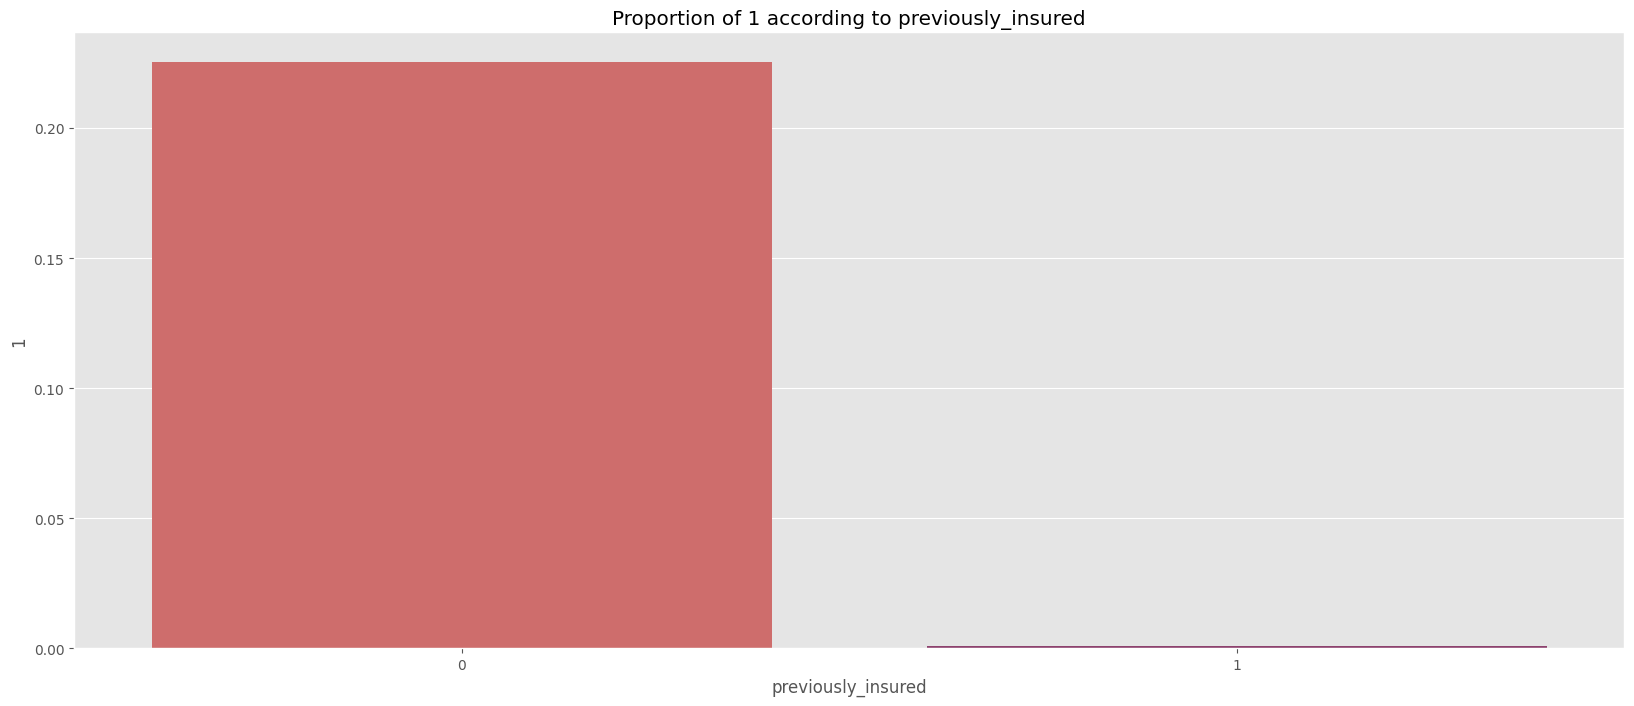

In [67]:
grouped_previously_insured = get_proportion_by_category('previously_insured')
plot_proportion_by_category(grouped_previously_insured, 'previously_insured')

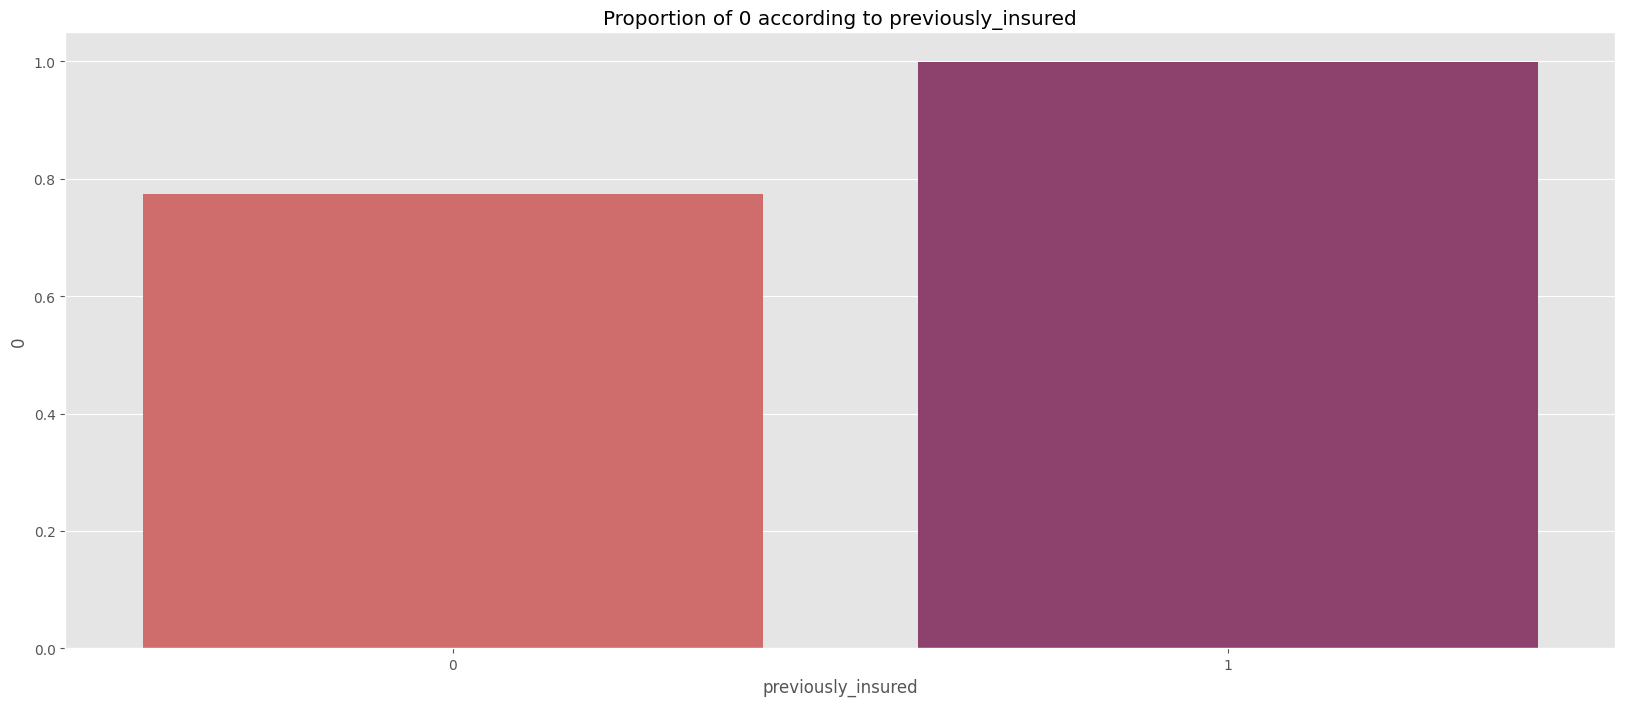

In [68]:
plot_proportion_by_category(grouped_previously_insured, 'previously_insured', 0)

In [69]:
stat, p, dof, expected = chi2(df3, 'previously_insured', 'response')

print(f'P-value: {p}')
if p < 0.05:
    print('There is a statistically significant relation between previously_insured and response.')
else:
    print('There is no statistically significant relation between previously_insured and response.')

print("Cramer'v: ", cramer_v(df3, 'previously_insured', 'response'))

P-value: 0.0
There is a statistically significant relation between previously_insured and response.
Cramer'v:  0.34116288076556345


### H7. Clientes com carro mais antigo demonstram menos interesse do que os que possuem carro mais novo.
**FALSA** Clientes com carro mais antigo demonstram MAIS interesse do que os que possuem carro mais novo.

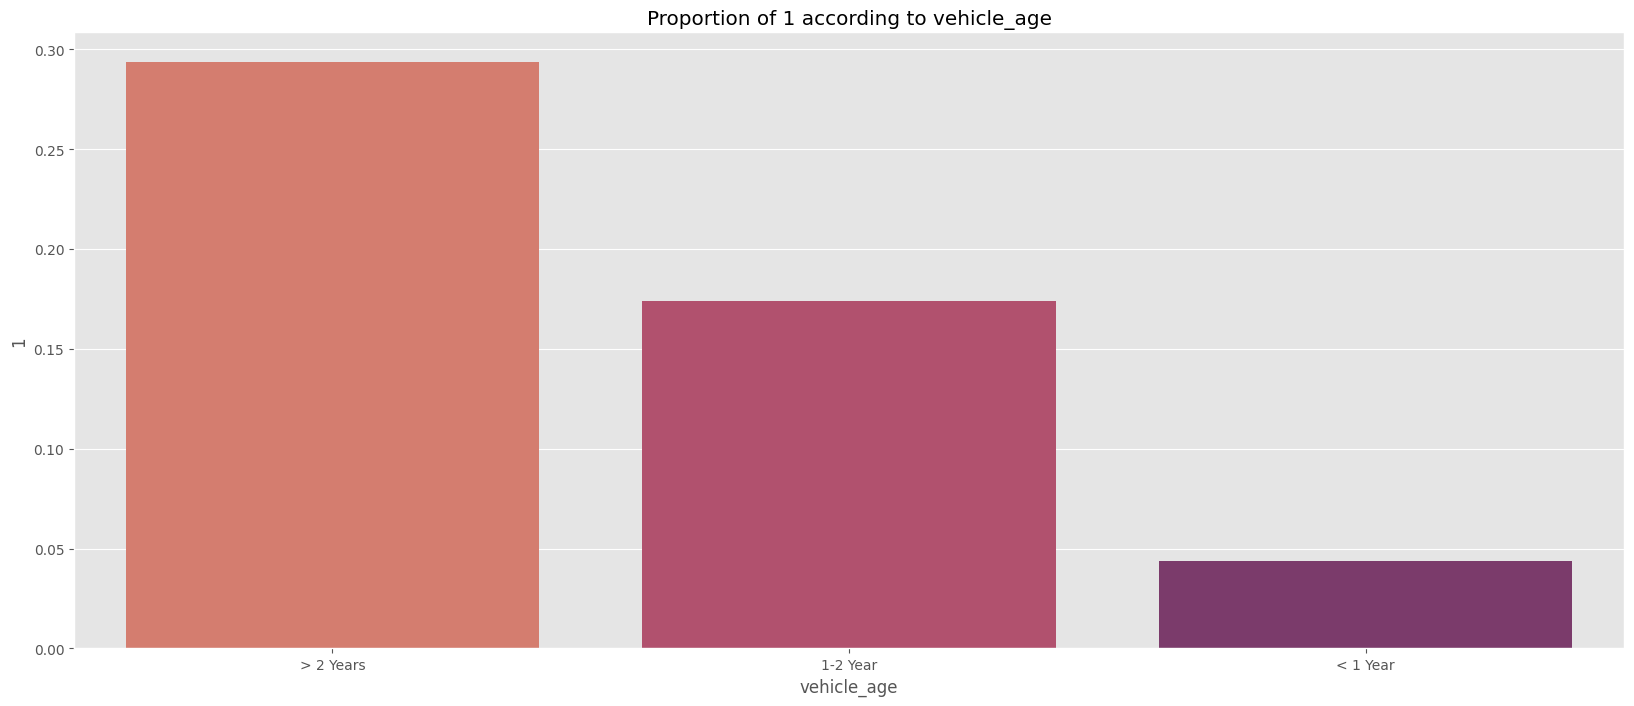

In [70]:
grouped_vehicle_age = get_proportion_by_category('vehicle_age')
plot_proportion_by_category(grouped_vehicle_age, 'vehicle_age')

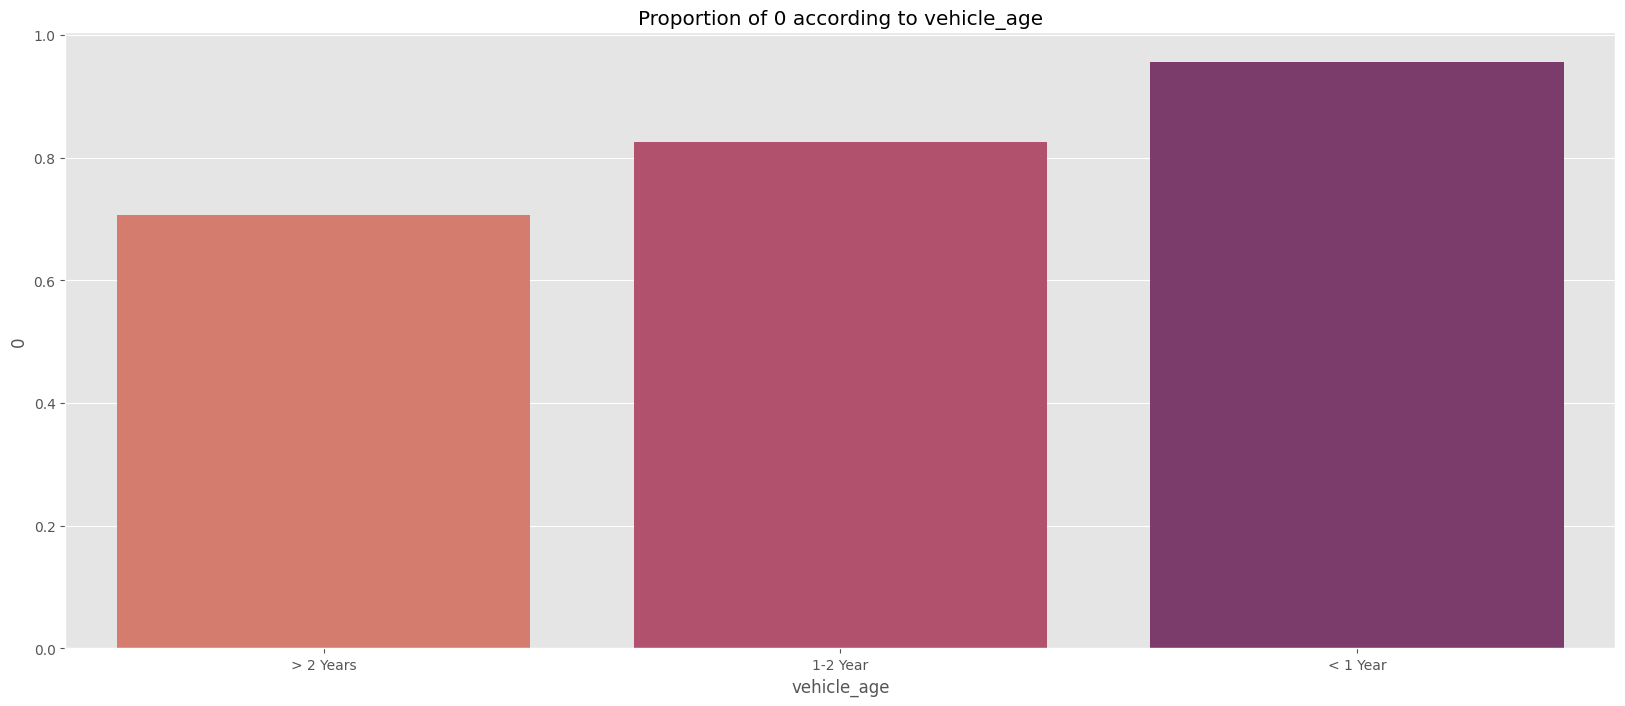

In [71]:
plot_proportion_by_category(grouped_vehicle_age, 'vehicle_age', 0)

In [72]:
stat, p, dof, expected = chi2(df3, 'vehicle_age', 'response')

print(f'P-value: {p}')
if p < 0.05:
    print('There is a statistically significant relation between vehicle_age and response.')
else:
    print('There is no statistically significant relation between vehicle_age and response.')

print("Cramer'v: ", cramer_v(df3, 'vehicle_age', 'response'))

P-value: 0.0
There is a statistically significant relation between vehicle_age and response.
Cramer'v:  0.22193713044970043


### H8. Clientes que já possuíram o carro prejudicado no passado possuem mais interesse.
**VERDADEIRA** Clientes que já possuíram o carro prejudicado no passado possuem mais interesse.

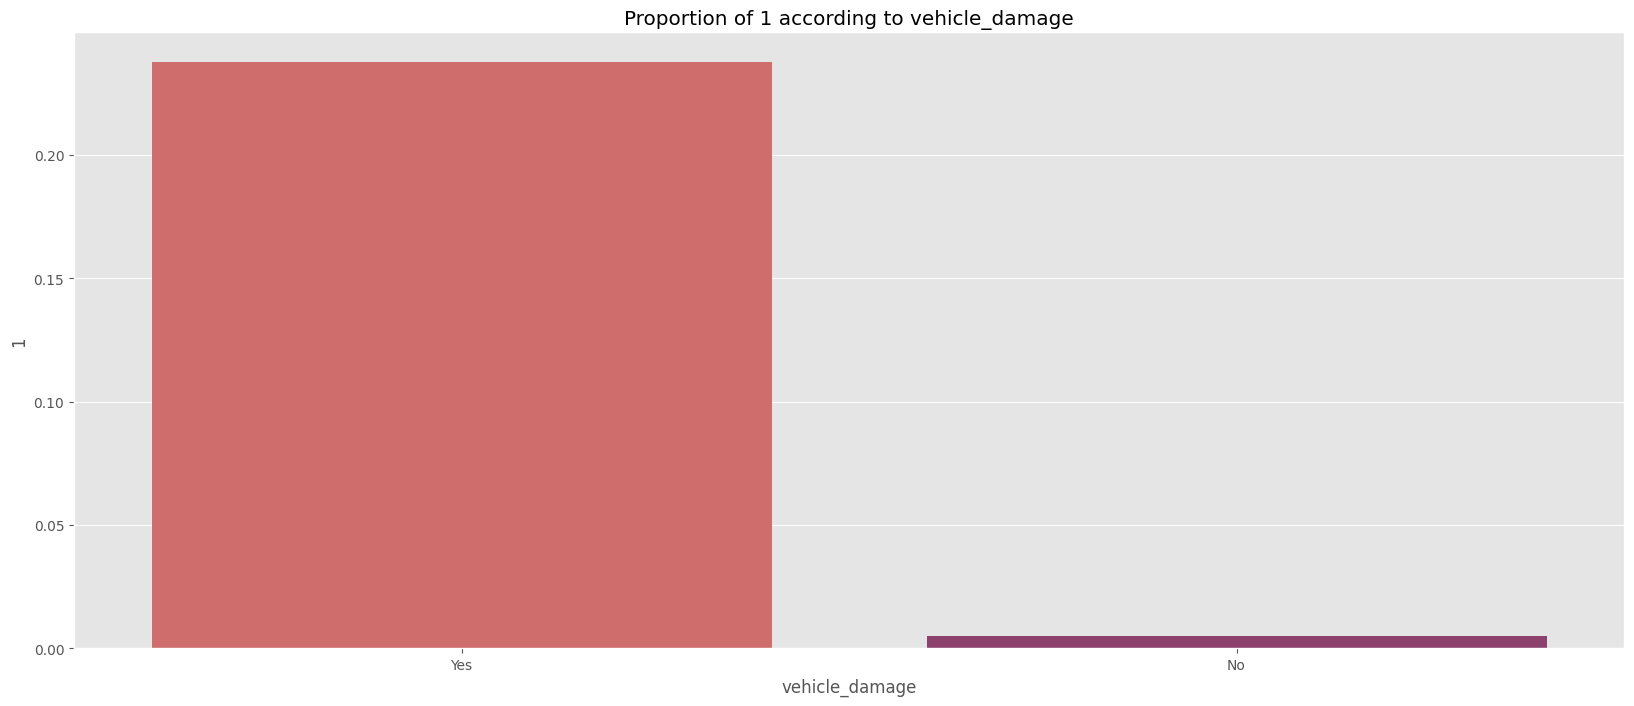

In [73]:
grouped_vehicle_damaged = get_proportion_by_category('vehicle_damage')
plot_proportion_by_category(grouped_vehicle_damaged, 'vehicle_damage')

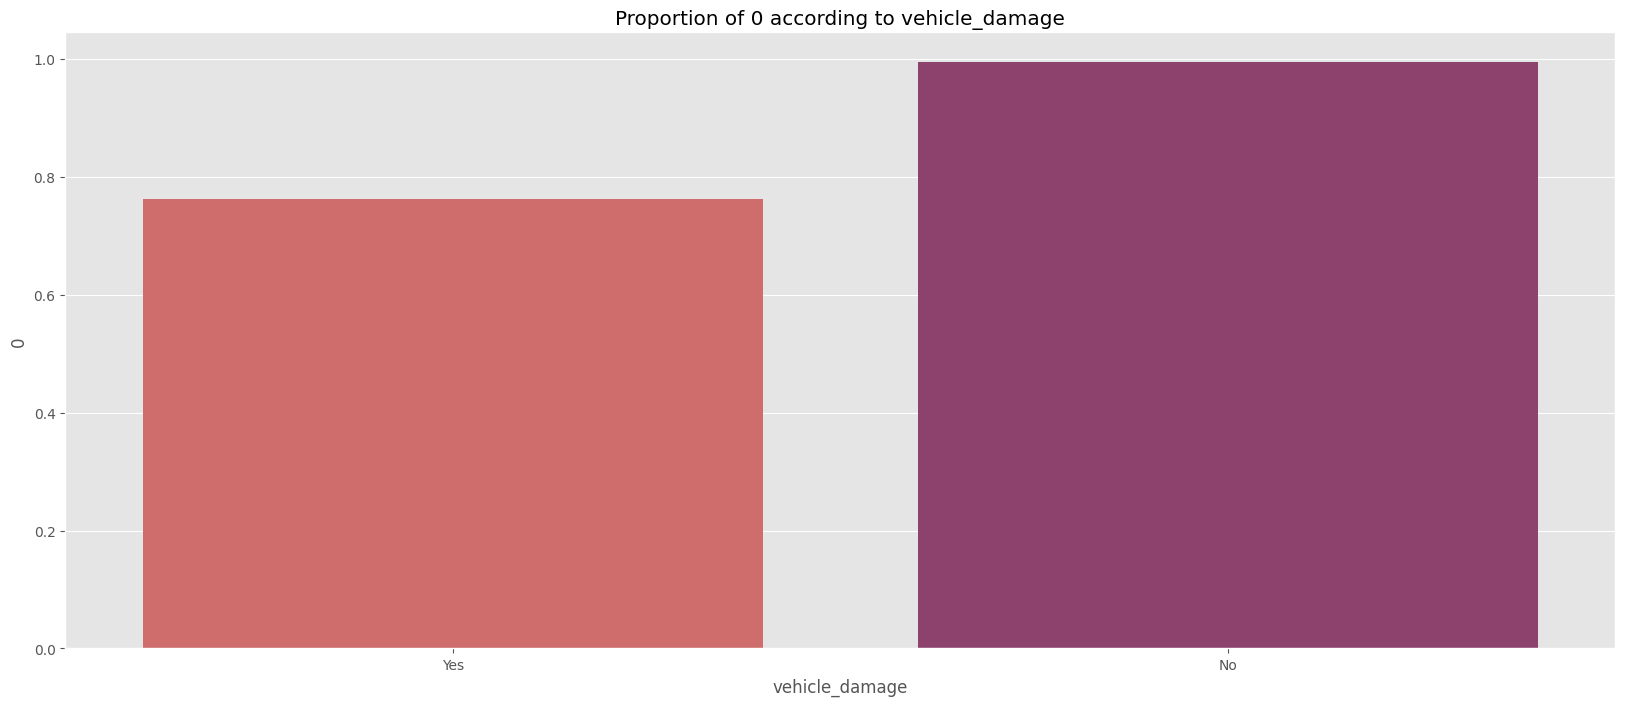

In [74]:
plot_proportion_by_category(grouped_vehicle_damaged, 'vehicle_damage', 0)

We see a difference of 24% on the proportion of interest for who got the car damaged in the past and who not. With that we can conclude that there is a relation between those varibles. To confirm our hypothesis, let's make an hypothesis test.

In [75]:
stat, p, dof, expected = chi2(df3, 'vehicle_damage', 'response')

print(f'P-value: {p}')
if p < 0.05:
    print('There is a statistically significant relation between vehicle_damage and response.')
else:
    print('There is no statistically significant relation between vehicle_damage and response.')

print("Cramer'v: ", cramer_v(df3, 'vehicle_damage', 'response'))

P-value: 0.0
There is a statistically significant relation between vehicle_damage and response.
Cramer'v:  0.35439200710199065


### <i>H9. Clientes que pagam um prêmio anual maior demonstram menos interesse no seguro de carros.
**FALSA** Não há relação entre interesse por seguro de carro e a quantidade paga de prêmio por ano.</i>

Analyse our hypothesis is the same as "client's who said that doesn't have interest pay more annual premium amounts."

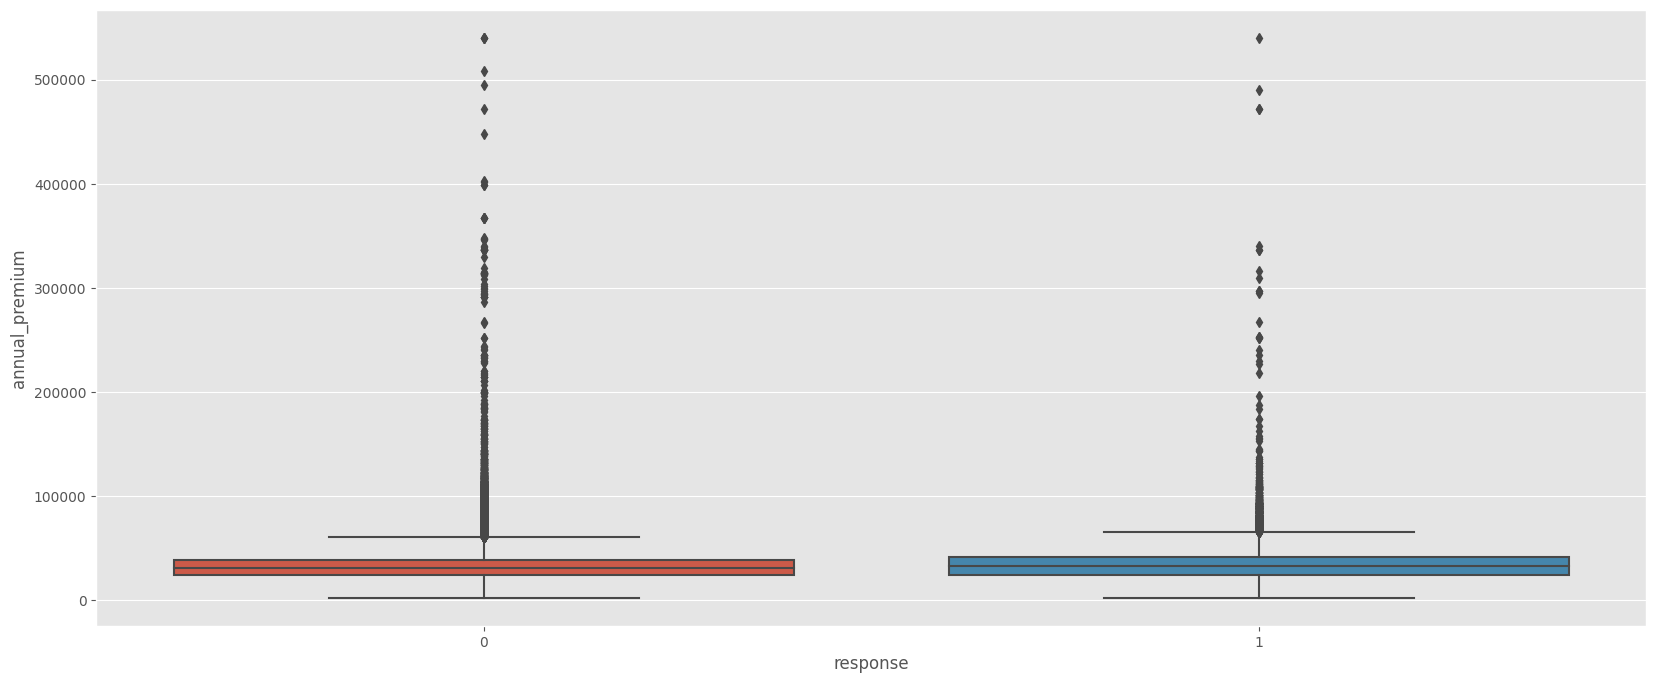

In [76]:
plt.figure(figsize=(20, 8))
sns.boxplot(df3, x='response', y='annual_premium')
plt.show()

In [77]:
df3.groupby("response")["annual_premium"].describe().T

response,0,1
count,334399.000000,46710.000000
mean,30419.160276,31604.092742
std,16998.293197,18646.508040
min,2630.000000,2630.000000
25%,24351.000000,24868.000000
50%,31504.000000,33002.000000
75%,39120.000000,41297.000000
max,540165.000000,540165.000000


Looking to the boxplot and to this table, we can't see significant differences between the answers according to how much the client pay of annual premium. To confirm that hypothesis, we can make an T-Test hypothesis test.

In [78]:
# Perform the Ttest test
result = ttest_ind(df3[df3['response'] == 0]['annual_premium'],
                  df3[df3['response'] == 1]['annual_premium'])

# Print the result of the test
stats, p = result

print(f'P-value: {p}')
if p < 0.05:
    print('There is a statistically significant difference between the annual premium means of the different response groups')
else:
    print("There isn't statistically significant difference between the annual premium means of the different response groups")

P-value: 3.7223151414267487e-44
There is a statistically significant difference between the annual premium means of the different response groups


It confirmed what I expected. We can't conclude that there is a statistically significant difference between the annual premium amount for people who manifested interest and people who don't.

### H10. Clientes que estão associados a mais tempo com a empresa demonstram mais interesse, pois confiam mais.
**FALSA** O tempo que o cliente está associado com a empresa não influencia no interesse por seguro de carro.

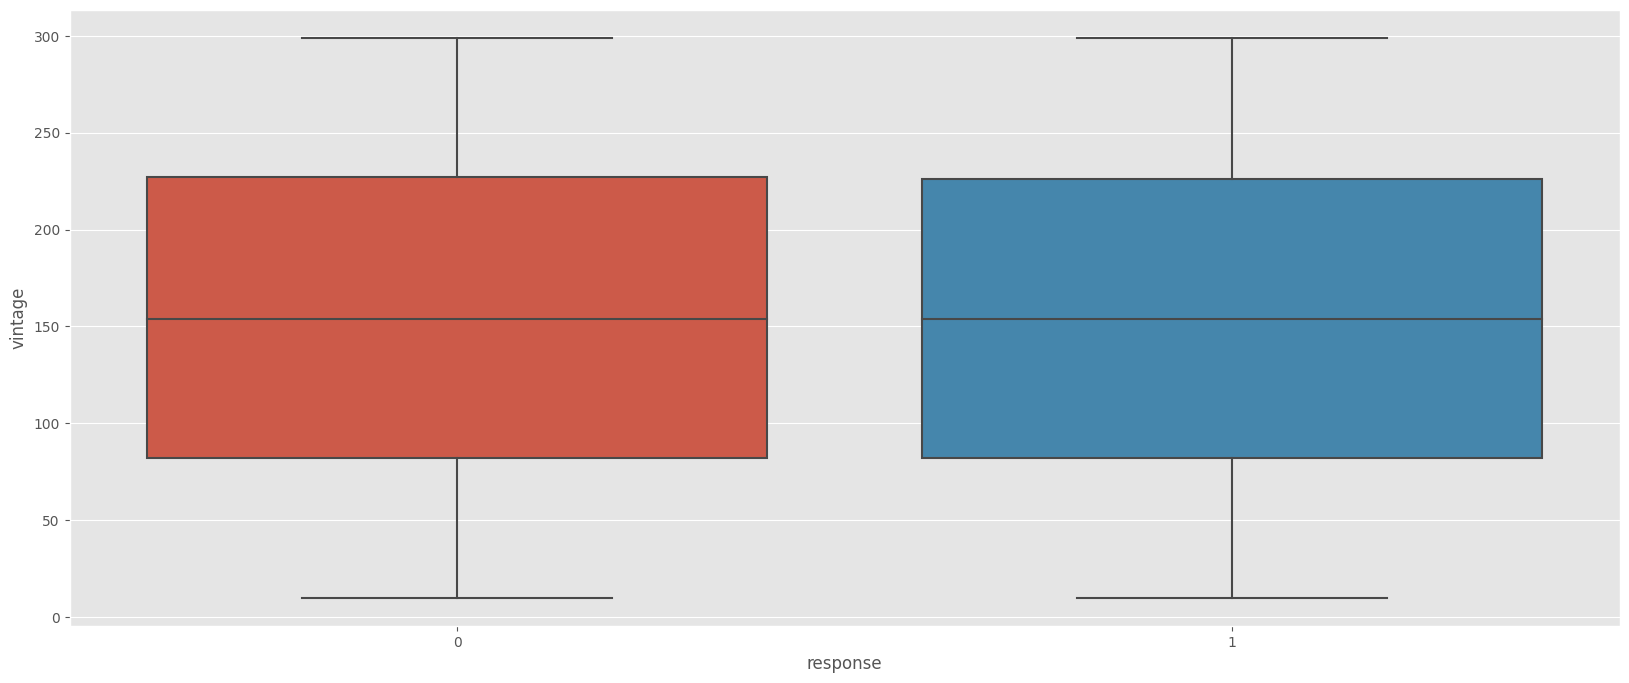

In [79]:
plt.figure(figsize=(20, 8))
sns.boxplot(df3, x='response', y='vintage')
plt.show()

In [80]:
df3.groupby("response")["vintage"].describe().T

response,0,1
count,334399.000000,46710.000000
mean,154.380243,154.112246
std,83.661975,83.738574
min,10.000000,10.000000
25%,82.000000,82.000000
50%,154.000000,154.000000
75%,227.000000,226.000000
max,299.000000,299.000000


In [81]:
# Perform the T test
result = ttest_ind(df3[df3['response'] == 0]['vintage'],
                   df3[df3['response'] == 1]['vintage'])

stats, p = result

print(f'P-value: {p}')
if p < 0.05:
    print('There is a statistically significant difference between the vintage means of the different response groups')
else:
    print("There isn't statistically significant difference between the vintage means of the different response groups")

P-value: 0.5167036521412091
There isn't statistically significant difference between the vintage means of the different response groups


### H11. Carros mais antigos sofreram mais danos do que carros mais novos.
**VEDADEIRA** Proporcionalmente, carros mais antigos sofreram mais danos do que carros mais novos.

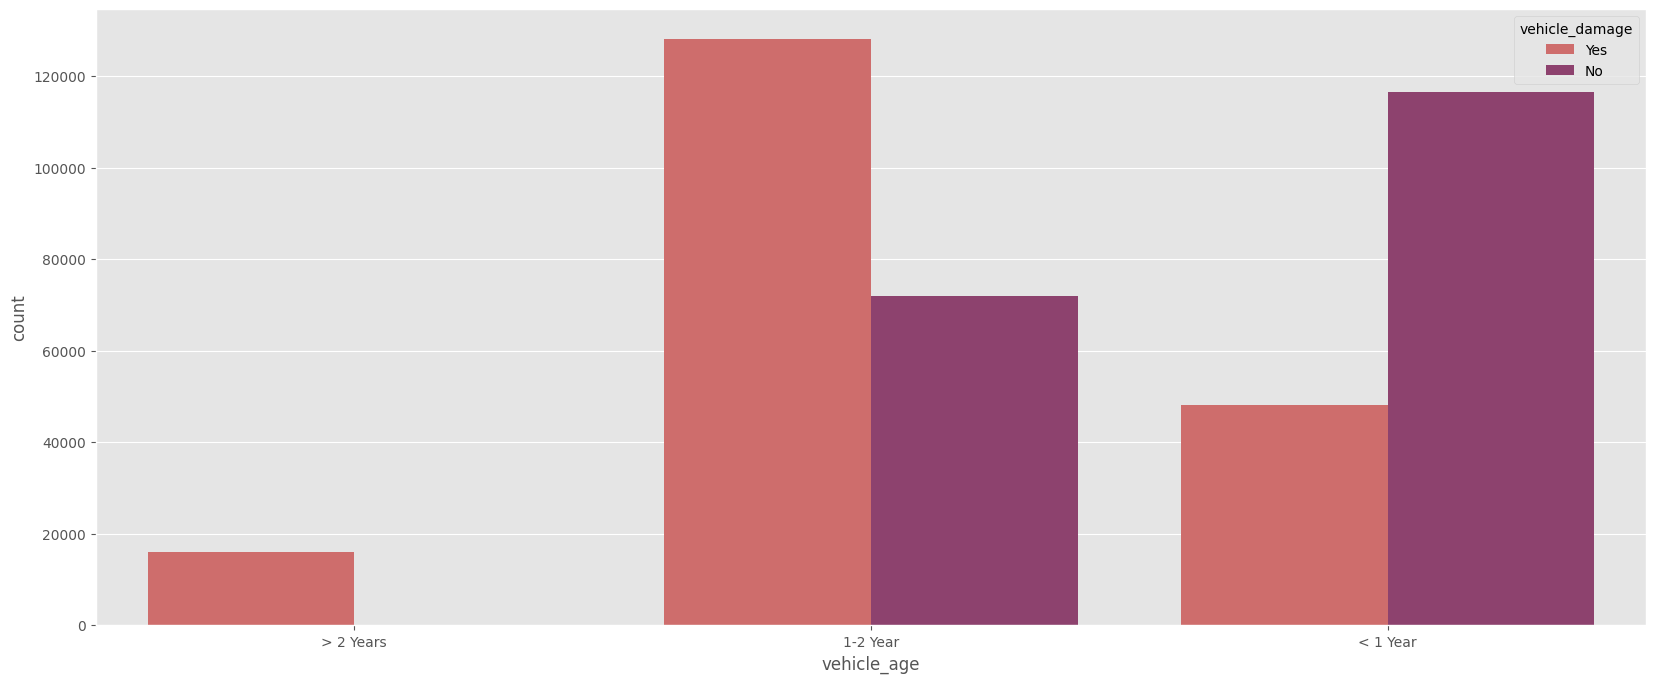

In [82]:
plt.figure(figsize=(20, 8))
sns.countplot(df3, x='vehicle_age', hue='vehicle_damage', palette="flare")
plt.show()

Looking at absolute values doesn't tell so much for us. We should look at this proportionally.

In [83]:
grouped_vehicle_age_damage = pd.DataFrame(df3.groupby("vehicle_age")["vehicle_damage"].value_counts(normalize=True)).rename(columns={'vehicle_damage':'proportion'})
grouped_vehicle_age_damage = grouped_vehicle_age_damage.reset_index()
grouped_vehicle_age_damage = grouped_vehicle_age_damage.pivot(index="vehicle_age", columns="vehicle_damage", values="proportion")
grouped_vehicle_age_damage.reset_index(inplace=True)

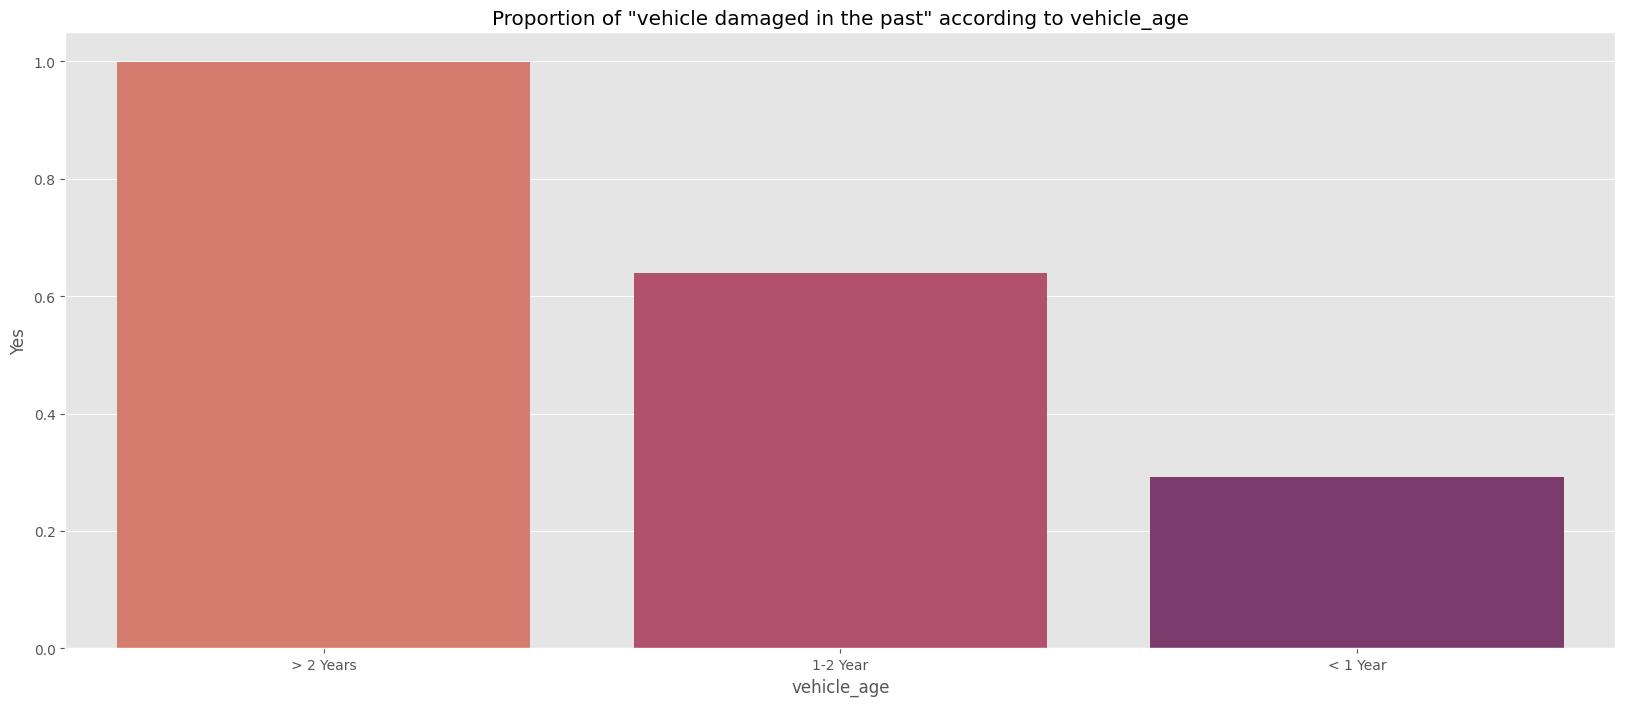

In [84]:
plt.figure(figsize=(20, 8))
ax = sns.barplot(grouped_vehicle_age_damage, x='vehicle_age', y='Yes', 
                order=grouped_vehicle_age_damage.sort_values(by=['Yes'], ascending=False)['vehicle_age'],
                palette='flare')
string = f'Proportion of "vehicle damaged in the past" according to vehicle_age'
plt.title(string)
plt.show()

In [85]:
stat, p, dof, expected = chi2(df3, 'vehicle_age', 'vehicle_damage')

print(f'P-value: {p}')
if p < 0.05:
    print('There is a statistically significant relation between vehicle_age and vehicle_damage.')
else:
    print('There is no statistically significant relation between vehicle_age and vehicle_damage.')

print("Cramer'v: ", cramer_v(df3, 'vehicle_age', 'vehicle_damage'))

P-value: 0.0
There is a statistically significant relation between vehicle_age and vehicle_damage.
Cramer'v:  0.39689255367798537


### H12. Clientes que pagam um prêmio anual maior possuem mais tempo de seguro do que os que pagam prêmios menores.
**FALSA** O valor do prêmio anual pago não influencia no tempo que o cliente está associado com a empresa.

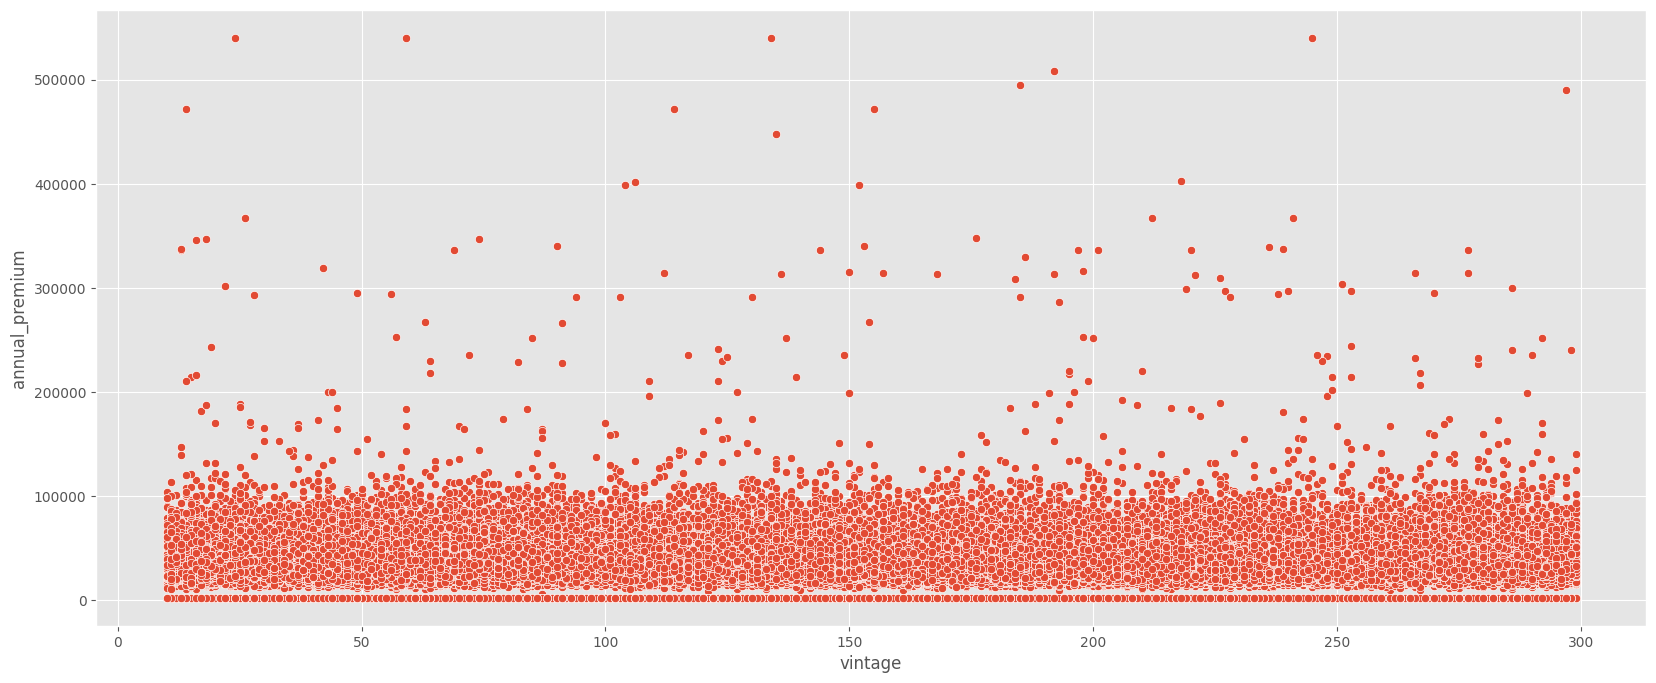

In [86]:
plt.figure(figsize=(20, 8))
sns.scatterplot(data=df3, x='vintage', y='annual_premium')
plt.show()

In [87]:
# Calculate Pearson's correlation coefficient and p-value
corr, p = pearsonr(df3['annual_premium'], df3['vintage'])

# Print results
print("P-value:", p)
print("Pearson's correlation coefficient:", corr)

if p < 0.05:
    print("The correlation between annual premium and vintage is statistically significant.")
else:
    print("There is no statistically significant correlation between annual premium and vintage.")

P-value: 0.7072148806427127
Pearson's correlation coefficient: -0.0006084171513097904
There is no statistically significant correlation between annual premium and vintage.


### H13. Mais de 90% dos clientes que dizem ter interesse no seguro já possuem carteira de motorista.
**VERDADEIRA** 99,9% dos clientes que dizem ter interesse no seguro já possuem carteira de motorista.

In [88]:
df3[df3['response'] == 1].driving_license.value_counts(normalize=True)

1    0.999122
0    0.000878
Name: driving_license, dtype: float64

In [89]:
df3[df3['response'] == 0].driving_license.value_counts(normalize=True)

1    0.997694
0    0.002306
Name: driving_license, dtype: float64

In [90]:
df3.driving_license.value_counts(normalize=True)

1    0.997869
0    0.002131
Name: driving_license, dtype: float64

We see that for all data we have an proportion of 99,78% that have driving license and 0,22% that doesn't. For the ones who has interest we see that 99,9% have driving license. This variable isn't so relevante for us because we see that almost everyone already has a driving license and it doesn't influences so much on the response.

### H14. Clientes mais velhos estão associados a mais tempo com o seguro (já não querem tanta instabilidade)
**FALSA** O tempo que o cliente está associado com a empresa não é influenciado pela idade.

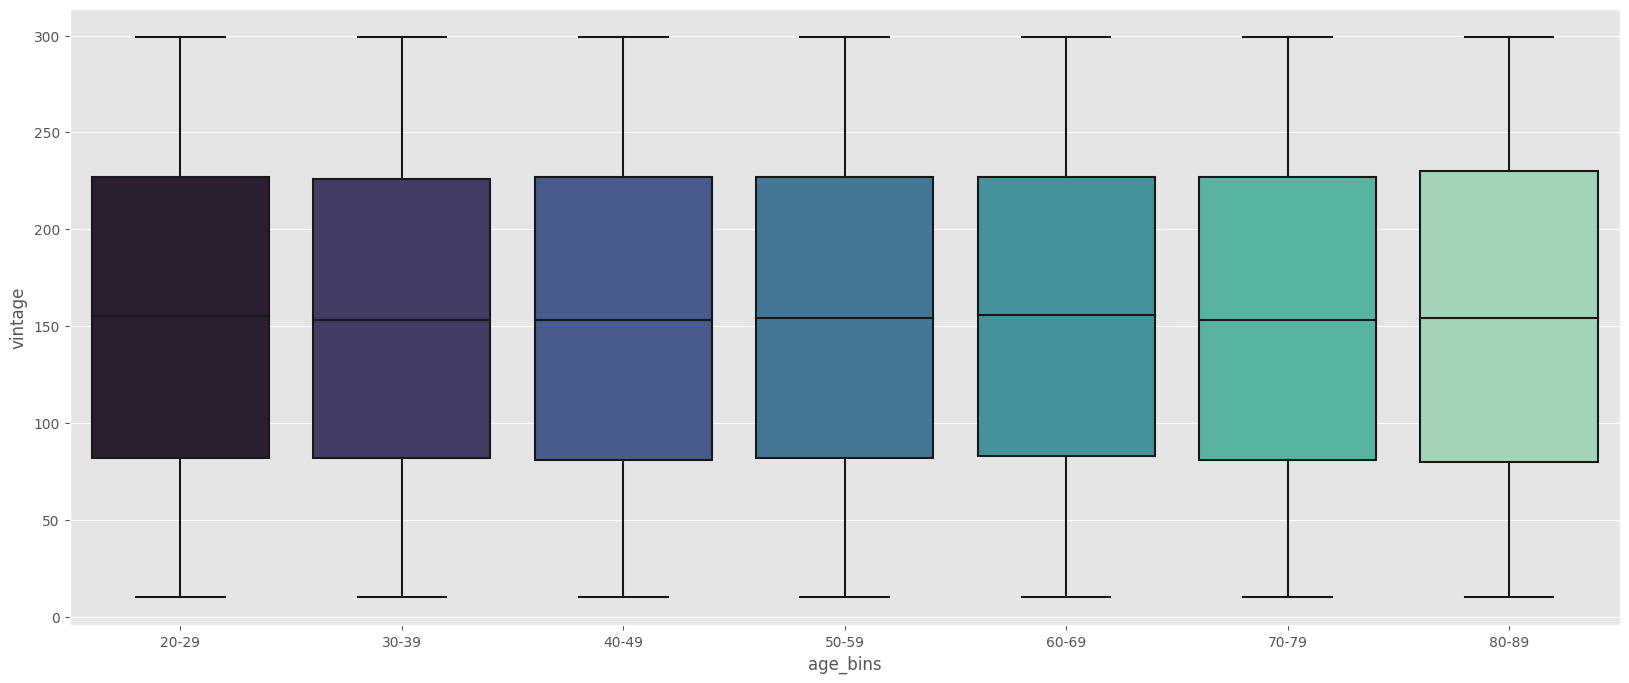

In [91]:
plt.figure(figsize=(20,8))
sns.boxplot(df3, x='age_bins', y='vintage', palette='mako')
plt.show()

In [92]:
df3.groupby("age_bins").vintage.describe().T

age_bins,20-29,30-39,40-49,50-59,60-69,70-79,80-89
count,155203.000000,54253.000000,76846.000000,48034.000000,29023.000000,16712.000000,1038.000000
mean,154.570781,154.155973,153.924277,154.297643,155.021879,153.837362,153.931599
std,83.637971,83.560152,83.922497,83.506016,83.501668,83.898613,84.550420
min,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
25%,82.000000,82.000000,81.000000,82.000000,83.000000,81.000000,80.000000
50%,155.000000,153.000000,153.000000,154.000000,156.000000,153.000000,154.000000
75%,227.000000,226.000000,227.000000,227.000000,227.000000,227.000000,230.000000
max,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000


## 5.3 Multivariate Analysis

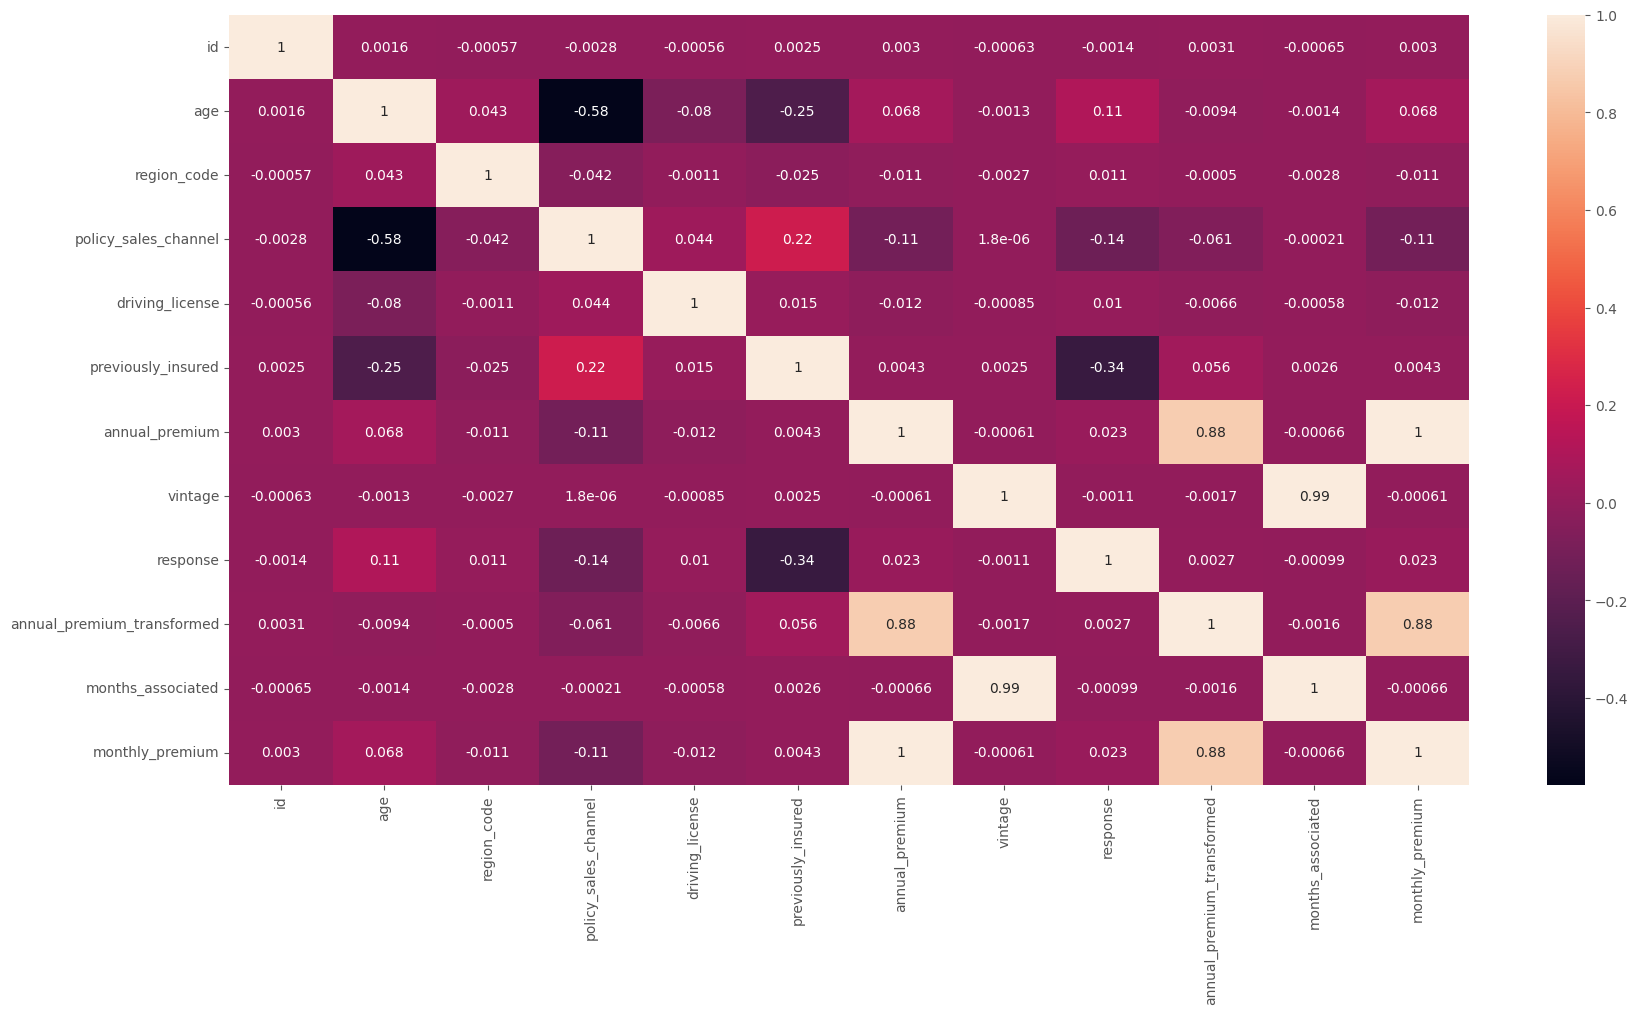

In [93]:
plt.figure(figsize=(20,10))
sns.heatmap(df3.corr(), annot=True)
plt.show()

# 6.0 Data Preparation

In [215]:
df4 = df3.copy()
cols_to_drop = ['annual_premium_transformed', 'months_associated', 'monthly_premium', 'age_bins']
df4 = df4.drop(cols_to_drop, axis=1)

## 6.1 Data splitting

In [216]:
X = df4.drop("response", axis=1)
y = df4['response']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## 6.2 Data standardization

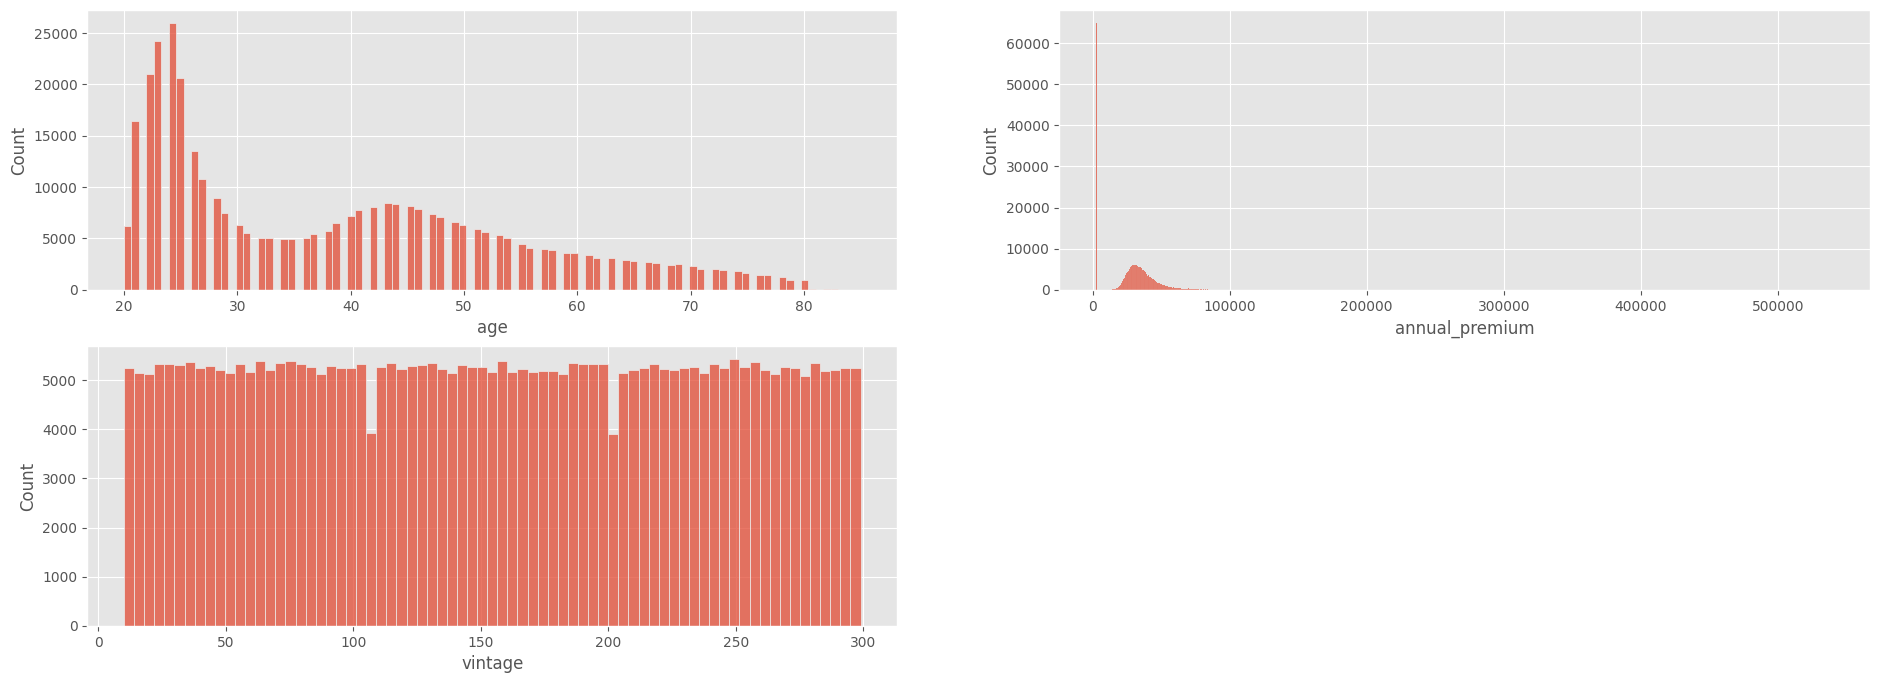

In [217]:
plt.figure(figsize=(23, 8))

plt.subplot(2, 2, 1)
sns.histplot(data=df4, x='age')

plt.subplot(2, 2, 2)
sns.histplot(data=df4, x='annual_premium')

plt.subplot(2, 2, 3)
sns.histplot(data=df4, x='vintage')

plt.show()

Visually, seems that any of our numeric variables follows an normal distribution. To guarantee that, let's make some normality tests.

The normality test is a statistical technique used to check whether a sample of data follows a normal distribution (also known as a Gaussian distribution). Two of the most common techniques for performing this test are the Shapiro-Wilk test and the Kolmogorov-Smirnov test.

In [218]:
# for column in ['vintage', 'age', 'annual_premium']:
#     shapiro(df4, column)
#     print(" ")

In [219]:
# for column in ['vintage', 'age', 'annual_premium']:
#     kstest(df4, column)
#     print(" ")

Then, we'll make data normalization, because data standardization assumes that our data follows an normal distribution.

## 6.3 Data normalization

### 6.3.1 Robust Scaler

In Python, the Robust Scaler is a method of scaling numeric features in a machine learning dataset. It works by scaling the data based on the median and interquartile range (IQR) instead of the mean and standard deviation used in Standard Scaler.

The Robust Scaler is useful when you have data with outliers or extreme values that can skew the mean and standard deviation. By using the median and IQR instead, the Robust Scaler is more resistant to outliers and can produce more robust feature scaling.

In [220]:
robust_scaler(X_train, X_test, 'annual_premium')

### 6.3.2 MinMax Scaler

In [221]:
for col in ['age', 'vintage']:
    min_max_scaler(X_train, X_test, col)

I applied robust scaler to annual_premium because it has outliers, and this scaler handle better these cases. 

## 6.4 Encoding

### 6.4.1 One Hot Encoding

In [222]:
#gender - One Hot Encoding
X_train, X_test = one_hot_encoding(X_train, X_test, 'gender')

#vechicle_age - One Hot Encoding
X_train, X_test = one_hot_encoding(X_train, X_test, 'vehicle_age')

#vehicle_damage - One Hot Encoding
X_train, X_test = one_hot_encoding(X_train, X_test, 'vehicle_damage')

### 6.4.2 Target Encoding

In [223]:
#region_code - Target Encoding
aux = pd.merge(X_train, df4[['id', 'response']], how='inner', on="id")
target_encode_region_code = dict(aux.groupby("region_code")['response'].sum() / aux.groupby("region_code")['response'].count())
X_train["region_code"] = X_train["region_code"].map(target_encode_region_code)
X_test["region_code"] = X_test["region_code"].map(target_encode_region_code)

with open("../artifacts/target_encode_region_code.json", "w") as outfile:
    json.dump(target_encode_region_code, outfile)

### 6.4.3 Frequency Encoding

In [224]:
#policy_sales_channel - Frequency Encoding
frequency_encode_policy_sales_channel = dict(X_train.groupby("policy_sales_channel").size() / len(X_train))
X_train["policy_sales_channel"] = X_train["policy_sales_channel"].map(frequency_encode_policy_sales_channel)
X_test["policy_sales_channel"] = X_test["policy_sales_channel"].map(frequency_encode_policy_sales_channel)

with open("../artifacts/frequency_encode_policy_sales_channel.json", "w") as outfile:
    json.dump(frequency_encode_policy_sales_channel, outfile)

## 6.5 Final data

In [225]:
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()
X_train = X_train.drop("id", axis=1)
X_test = X_test.drop("id", axis=1)

In [226]:
X_test.fillna(0, inplace=True)

In [227]:
X_train.head()

,age,region_code,policy_sales_channel,driving_license,previously_insured,annual_premium,vintage,gender_Female,gender_Male,vehicle_age_1-2 Year,vehicle_age_< 1 Year,vehicle_age_> 2 Years,vehicle_damage_No,vehicle_damage_Yes
0,0.046154,0.095821,0.353846,1,1,0.361031,0.716263,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.461538,0.186377,0.208648,1,0,1.493651,0.259516,0.0,1.0,1.0,0.0,0.0,0.0,1.0
2,0.061538,0.064683,0.015809,1,1,0.039463,0.235294,0.0,1.0,1.0,0.0,0.0,1.0,0.0
3,0.353846,0.093059,0.194088,1,1,-0.106723,0.121107,1.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.046154,0.129728,0.057251,1,1,-1.935006,0.242215,1.0,0.0,0.0,1.0,0.0,1.0,0.0


In [228]:
X_test.head()

,age,region_code,policy_sales_channel,driving_license,previously_insured,annual_premium,vintage,gender_Female,gender_Male,vehicle_age_1-2 Year,vehicle_age_< 1 Year,vehicle_age_> 2 Years,vehicle_damage_No,vehicle_damage_Yes
0,0.061538,0.093059,0.353846,1,1,-0.961770,0.664360,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,0.276923,0.127067,0.194088,1,0,-1.935006,0.276817,0.0,1.0,1.0,0.0,0.0,0.0,1.0
2,0.076923,0.095821,0.353846,1,1,0.708196,0.515571,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.507692,0.186377,0.194088,1,1,0.628337,0.058824,0.0,1.0,1.0,0.0,0.0,0.0,1.0
4,0.446154,0.103714,0.003247,1,0,0.033263,0.394464,1.0,0.0,1.0,0.0,0.0,0.0,1.0


In [229]:
y_train.head()

168635    0
104515    0
228292    0
252492    0
134559    0
Name: response, dtype: int64

In [230]:
y_test.head()

234642    0
275476    0
141597    0
334738    0
316974    0
Name: response, dtype: int64

In [231]:
# X_train.to_csv('../data/processed/X_train_processed.csv')
# X_test.to_csv('../data/processed/X_test_processed.csv')
# y_train.to_csv('../data/processed/y_train_processed.csv')
# y_test.to_csv('../data/processed/y_test_processed.csv')

# 7.0 Feature Selection

In [232]:
X_train_fs = X_train.copy()
y_train_fs = y_train.copy()

## 7.1 SelectKBest

In [233]:
# selector = SelectKBest(f_regression, k=7)
# selector.fit(X_train_fs, y_train_fs)

# mask = selector.get_support()
# X_train_fs.columns[mask]

In [234]:
selected_cols_kbest = ['region_code', 'policy_sales_channel', 'previously_insured',
       'vehicle_age_1-2 Year', 'vehicle_age_< 1 Year', 'vehicle_damage_No',
       'vehicle_damage_Yes']

## 7.2 Feature Importance

In [235]:
# feature_importance(X_train_fs, y_train_fs, 7, True)

In [236]:
selected_cols_fi = ['vintage', 'annual_premium', 'age', 'region_code', 'policy_sales_channel', 
                    'vehicle_damage_Yes', 'vehicle_damage_No']

These are the columns i'll use to train the model.

## 7.3 Selected data

In [237]:
X_train = X_train[selected_cols_fi]
X_test = X_test[selected_cols_fi]

X_train.head()

,vintage,annual_premium,age,region_code,policy_sales_channel,vehicle_damage_Yes,vehicle_damage_No
0,0.716263,0.361031,0.046154,0.095821,0.353846,0.0,1.0
1,0.259516,1.493651,0.461538,0.186377,0.208648,1.0,0.0
2,0.235294,0.039463,0.061538,0.064683,0.015809,0.0,1.0
3,0.121107,-0.106723,0.353846,0.093059,0.194088,0.0,1.0
4,0.242215,-1.935006,0.046154,0.129728,0.057251,0.0,1.0


In [238]:
y_train.head()

168635    0
104515    0
228292    0
252492    0
134559    0
Name: response, dtype: int64

# 8.0 Modelling

## 8.1 Random Forest Classifier

In [239]:
rf = RandomForestClassifier(n_estimators=150,
                           n_jobs=-1)

rf.fit(X_train, y_train)

ypred_rf = rf.predict_proba(X_test)

In [240]:
metrics_rf = get_metrics_dataframe(X_test_copy, y_test, ypred_rf)

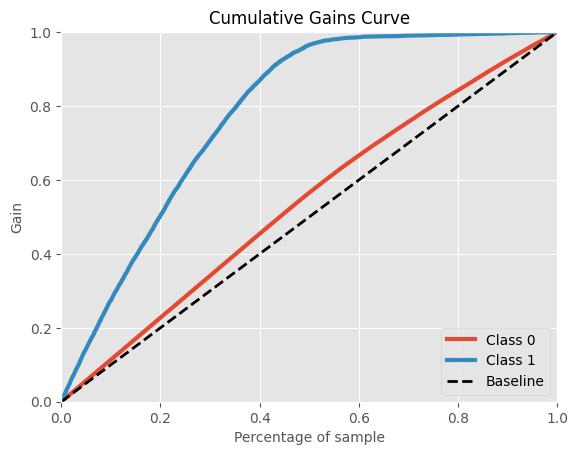

In [120]:
skplt.metrics.plot_cumulative_gain(y_test, ypred_rf)
plt.show()

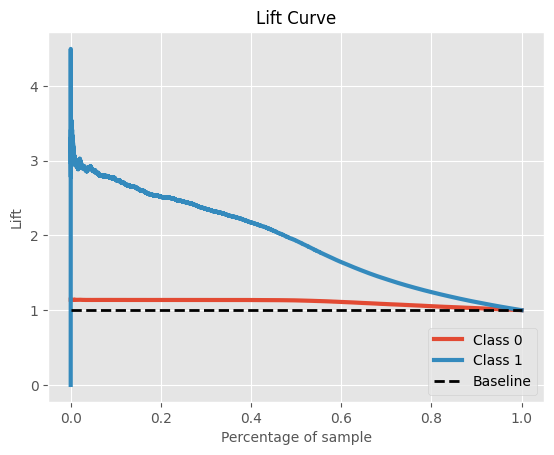

In [121]:
skplt.metrics.plot_lift_curve(y_test, ypred_rf)
plt.show()

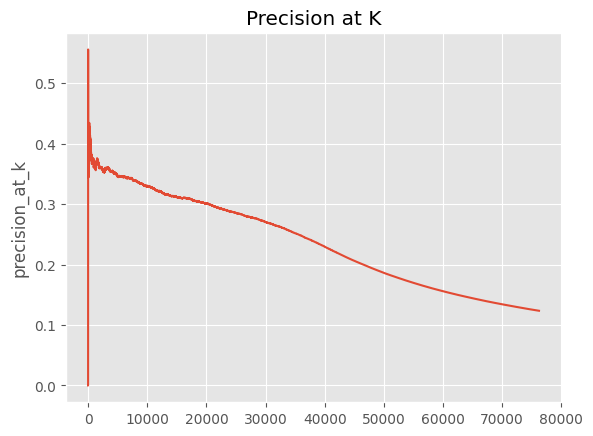

In [122]:
sns.lineplot(metrics_rf["precision_at_k"])
plt.title("Precision at K")
plt.show()

## 8.2 Balanced Random Forest Classifier

In [123]:
rf_balanced = RandomForestClassifier(n_estimators=150,
                           n_jobs=-1,
                           class_weight='balanced')

rf_balanced.fit(X_train, y_train)

ypred_rf_balanced = rf_balanced.predict_proba(X_test)

In [124]:
metrics_rf_balanced = get_metrics_dataframe(X_test_copy, y_test, ypred_rf_balanced)

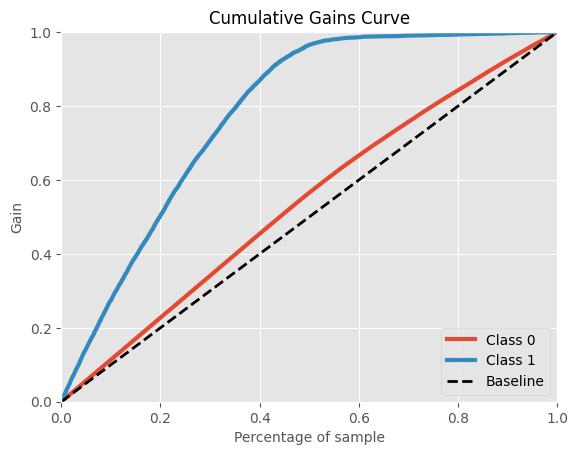

In [125]:
skplt.metrics.plot_cumulative_gain(y_test, ypred_rf)
plt.show()

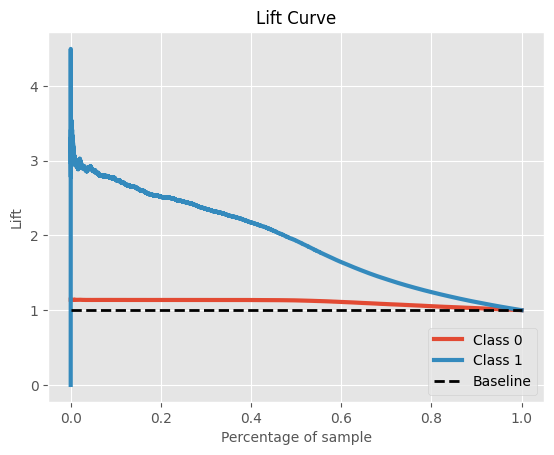

In [126]:
skplt.metrics.plot_lift_curve(y_test, ypred_rf)
plt.show()

## 8.3 Logistic Regression

In [127]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
ypred_lr = lr.predict_proba(X_test)

In [128]:
metrics_lr = get_metrics_dataframe(X_test_copy, y_test, ypred_lr)

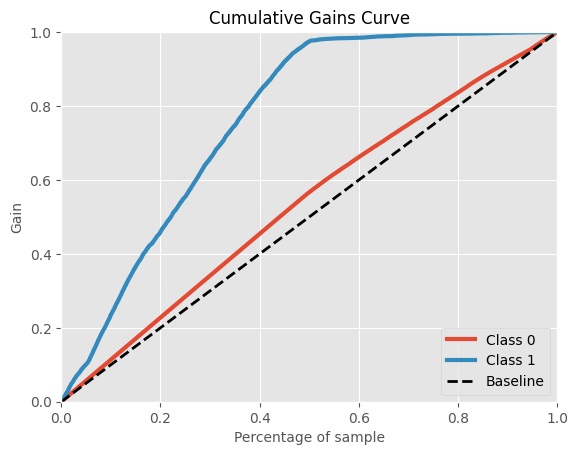

In [129]:
skplt.metrics.plot_cumulative_gain(y_test, ypred_lr)
plt.show()

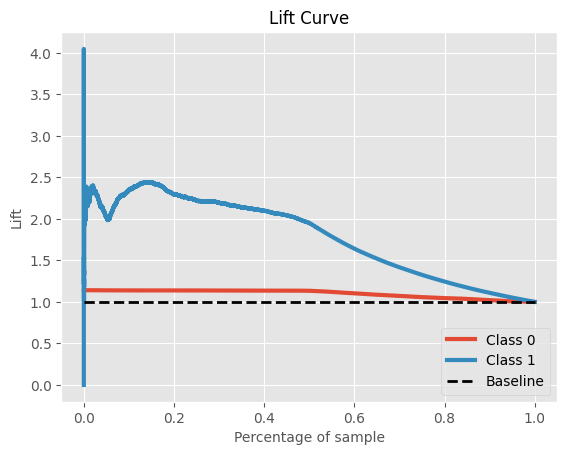

In [130]:
skplt.metrics.plot_lift_curve(y_test, ypred_lr)
plt.show()

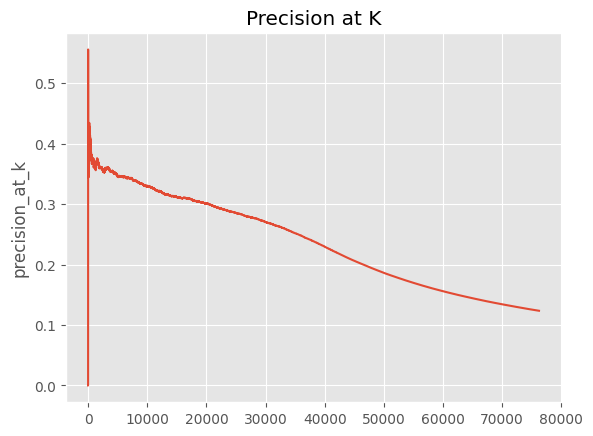

In [131]:
sns.lineplot(metrics_rf["precision_at_k"])
plt.title("Precision at K")
plt.show()

## 8.4 XGBoost

In [132]:
xgboost = xgb.XGBClassifier()      
xgboost.fit(X_train, y_train)
ypred_xgb = xgboost.predict_proba(X_test)

In [133]:
metrics_xgb = get_metrics_dataframe(X_test_copy, y_test, ypred_xgb)

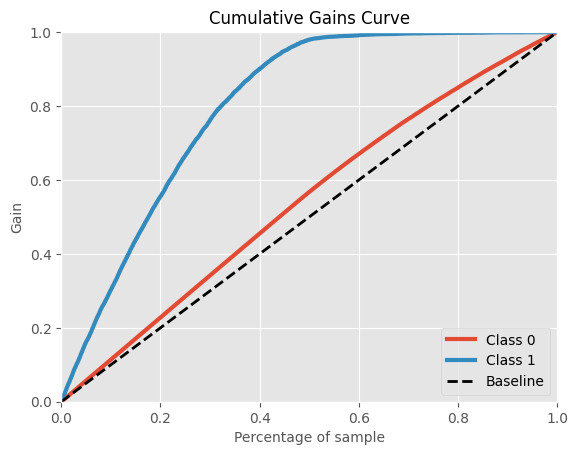

In [134]:
skplt.metrics.plot_cumulative_gain(y_test, ypred_xgb)
plt.show()

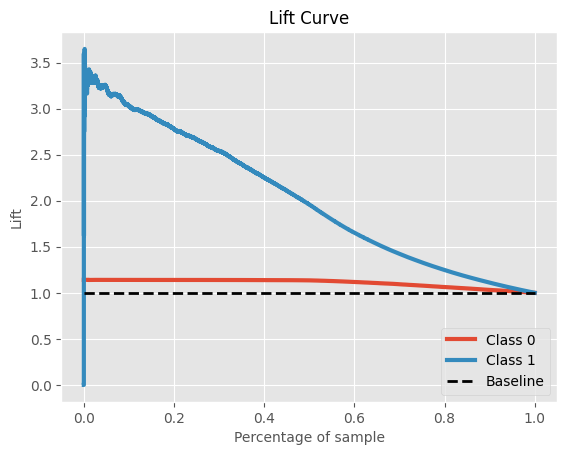

In [135]:
skplt.metrics.plot_lift_curve(y_test, ypred_xgb)
plt.show()

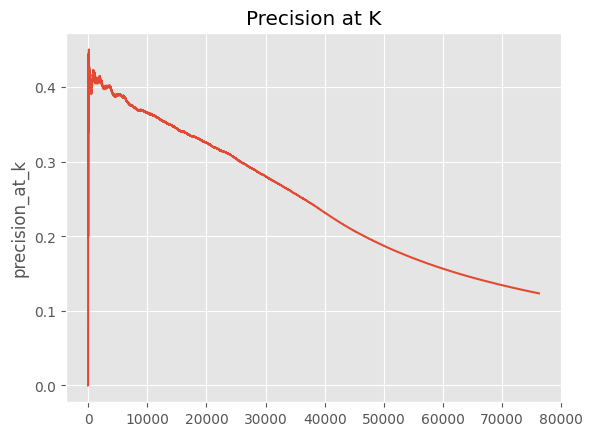

In [136]:
sns.lineplot(metrics_xgb["precision_at_k"])
plt.title("Precision at K")
plt.show()

## 8.5 Comparing models

In [321]:
X = pd.concat([X_train, X_test])
X.reset_index(drop=True, inplace=True)

y = pd.concat([y_train, y_test])
y.reset_index(drop=True, inplace=True)

In [331]:
# model_comparison = cross_validation(X, y, [xgboost, lr, rf])

In [332]:
model_comparison = pd.read_pickle('../imgs/first_model_comparison.pkl')
model_comparison

,model,precision@k mean,precision@k std,recall@k mean,recall@k std,auc mean,auc std
0,XGBClassifier,0.340,0.004,0.555,0.007,0.843,0.002
0,RandomForestClassifier,0.309,0.001,0.505,0.002,0.820,0.001
0,LogisticRegression,0.280,0.003,0.457,0.006,0.803,0.002


With that, we can see that XGBoost is the best model. It perfomed better in both precision@k and recall@k. So, this is the model we'll use to fine tune.

# 9.0 Hyperparameter Fine Tuning

In [140]:
# params = {
#     'n_estimators': [100, 200, 300, 400, 500],
#     'max_depth': [3, 4, 5, 6, 7, 8],
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'subsample': [0.6, 0.7, 0.8, 0.9, 1],
#     'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1],
#     'gamma': [0, 0.1, 0.2, 0.3, 0.4],
#     'min_child_weight': [1, 2, 3, 4, 5]
# }

In [141]:
# rs = RandomizedSearchCV(xgb.XGBoostClassifier(), 
#                         param_distributions=params, 
#                         n_iter=10, 
#                         cv=3, n_jobs=-1, 
#                         random_state=42).fit(X_train, y_train)

In [142]:
model = pickle.load(open('../artifacts/model.pkl', 'rb'))

In [143]:
model.best_params_

{'subsample': 0.6,
 'n_estimators': 400,
 'min_child_weight': 1,
 'max_depth': 5,
 'learning_rate': 0.01,
 'gamma': 0.2,
 'colsample_bytree': 0.6}

Now, we saved our tuned model in pickle file and loaded it into 'model'.

# 10.0 Final Metrics

## 10.1 Precision@K and Recall@K

In [326]:
# models = [model, xgboost, rf, lr]
# final_model_comparison = cross_validation(X, y, models)

Starting cross validation for model 1/4...
Finished.
Starting cross validation for model 2/4...
Finished.
Starting cross validation for model 3/4...
Finished.
Starting cross validation for model 4/4...
Finished.


In [334]:
final_model_comparison = pd.read_pickle('../imgs/final_model_comparison.pkl')
final_model_comparison

,model,precision@k mean,precision@k std,recall@k mean,recall@k std,auc mean,auc std
0,XGBClassifier,0.34,0.004,0.555,0.007,0.843,0.002
0,XGBClassifier,0.34,0.004,0.555,0.007,0.843,0.002
0,RandomForestClassifier,0.31,0.001,0.506,0.001,0.820,0.001
0,LogisticRegression,0.28,0.003,0.457,0.006,0.803,0.002


We didn't saw any difference between XGBoost and the one tuned. So, we'll get the tuned one as our final model.

## 10.2 Cumulative Gain Curve

In [144]:
ypred_final = model.predict_proba(X_test)
final_metrics = get_metrics_dataframe(X_test_copy, y_test, ypred_final)

In [148]:
results = pd.DataFrame()
results['response'] = y_test.copy()
results['propensity_score'] = ypred_final[:, 1]
results = results.sort_values("propensity_score", ascending=False)
results.reset_index(inplace=True)
results['ranking'] = results.index + 1
results['base_perc'] = results['ranking']/results.shape[0]
results['mean_model'] = results['base_perc']
results['cumulative_propensity_score'] = results['response'].cumsum() / results['response'].value_counts()[1]

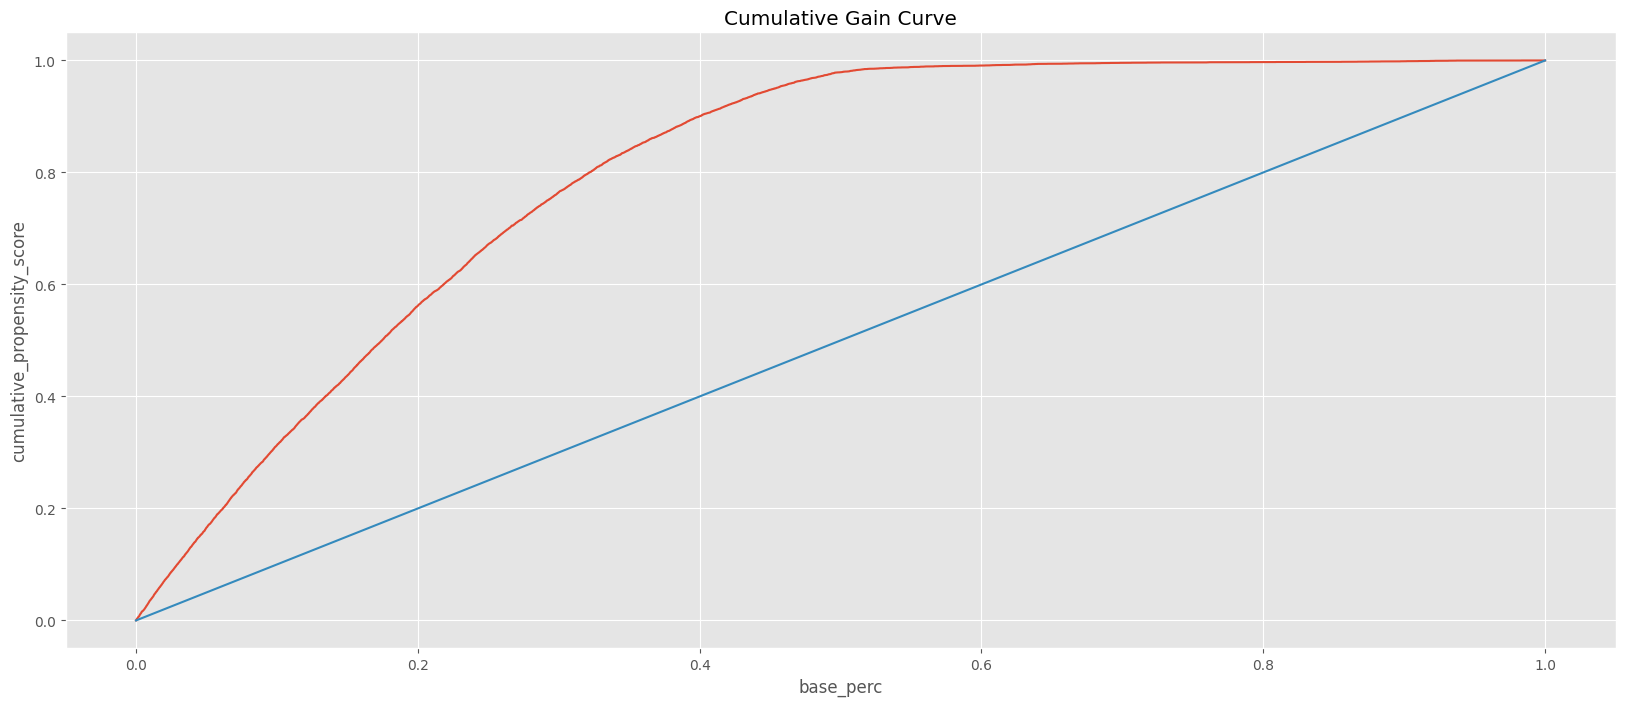

In [149]:
plt.figure(figsize=(20, 8))

sns.lineplot(x='base_perc', y='cumulative_propensity_score', data=results)
sns.lineplot(x='base_perc', y='base_perc', data=results)

plt.title("Cumulative Gain Curve")

plt.show()

## 10.3 Lift Curve

In [150]:
results['lift'] = results['cumulative_propensity_score'] / results['mean_model']

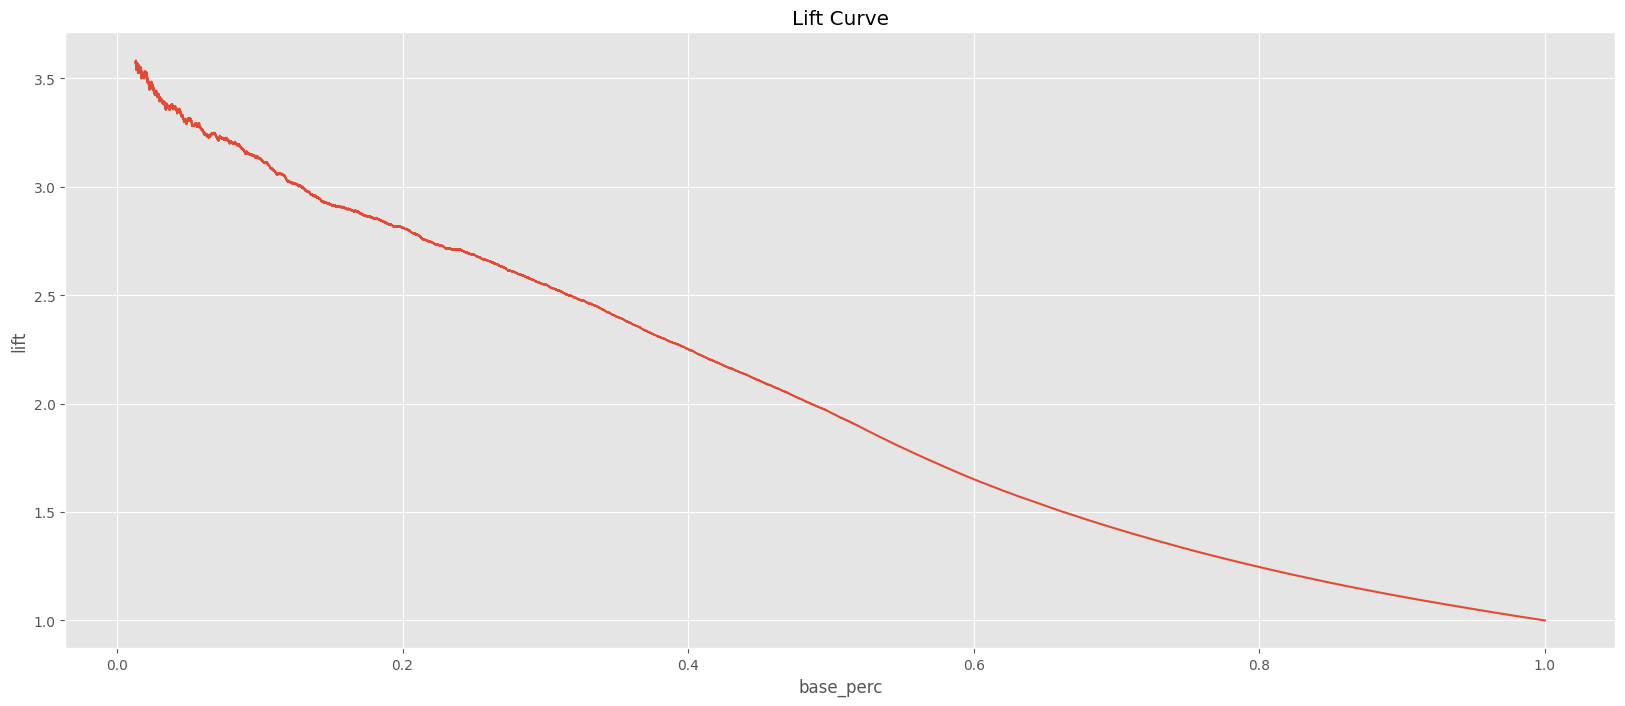

In [151]:
plt.figure(figsize=(20, 8))
sns.lineplot(x='base_perc', y='lift', data=results.iloc[1000:])
plt.title("Lift Curve")
plt.show()

# 11.0 Business Perfomance

These will be the answered questions: 
* Main Insights on the most relevant attributes of customers interested in purchasing auto insurance.
* What percentage of customers interested in purchasing auto insurance will the sales team be able to reach by making 20,000 calls? 
* And if the sales team's capacity increases to 40,000 calls, what percentage of customers interested in purchasing auto insurance will the sales team be able to contact?
* How many calls does the sales team need to make to contact 80% of customers interested in purchasing auto insurance.

### 11.1 Main insights on the most relevant attributes of customers interest in purchasing auto insurance.

* Clientes com carro mais antigo demonstram MAIS interesse do que os que possuem carro mais novo. (H7)
* O tempo que o cliente está associado com a empresa não influencia no interesse por seguro de carro. (H10)
* O público entre 20 e 30 anos é o que demonstra menos interesse. (H5)
* O grupo entre 40 e 49 anos é o mais interessado. (H5)
* Clientes que já possuíram o carro prejudicado no passado possuem mais interesse. (H8)

### 11.2 What percentage of customers interested in purchasing auto insurance will the sales team be able to reach by making 20.000 calls?

In [152]:
base_perc = 20000/results.shape[0]
reached_perc = reached_interested_customers(20000) 

print(f'If the sales team make 20.000 calls, they will reach {reached_perc:.2f}% of customers interested in purchasing vehicle insurance.')

If the sales team make 20.000 calls, they will reach 0.70% of customers interested in purchasing vehicle insurance.


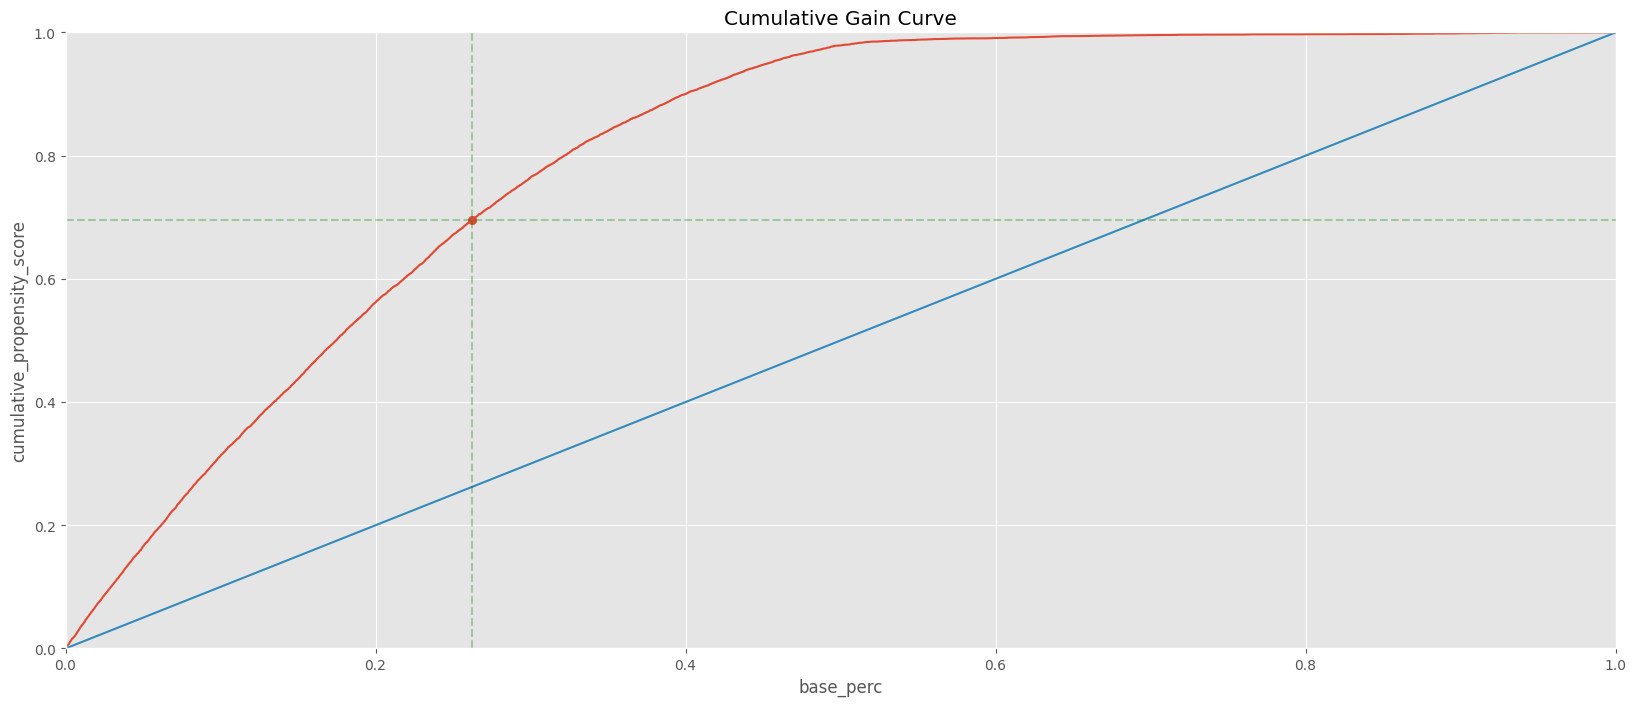

In [153]:
plt.figure(figsize=(20, 8))

sns.lineplot(x='base_perc', y='cumulative_propensity_score', data=results)
sns.lineplot(x='base_perc', y='base_perc', data=results)
plt.axvline(x=base_perc, color='g', ls='--', alpha=0.3)
plt.axhline(y=reached_perc, color='g', ls='--', alpha=0.3)

plt.scatter(base_perc, reached_perc)

plt.xlim(0, 1)
plt.ylim(0, 1)


plt.title("Cumulative Gain Curve")

plt.show()

In [154]:
lift = results[results['base_perc'] >= base_perc].iloc[0]['lift']
print(f'Calling 20.000 based on our model will be {lift:.2f}x better than using random choice.')

Calling 20.000 based on our model will be 2.65x better than using random choice.


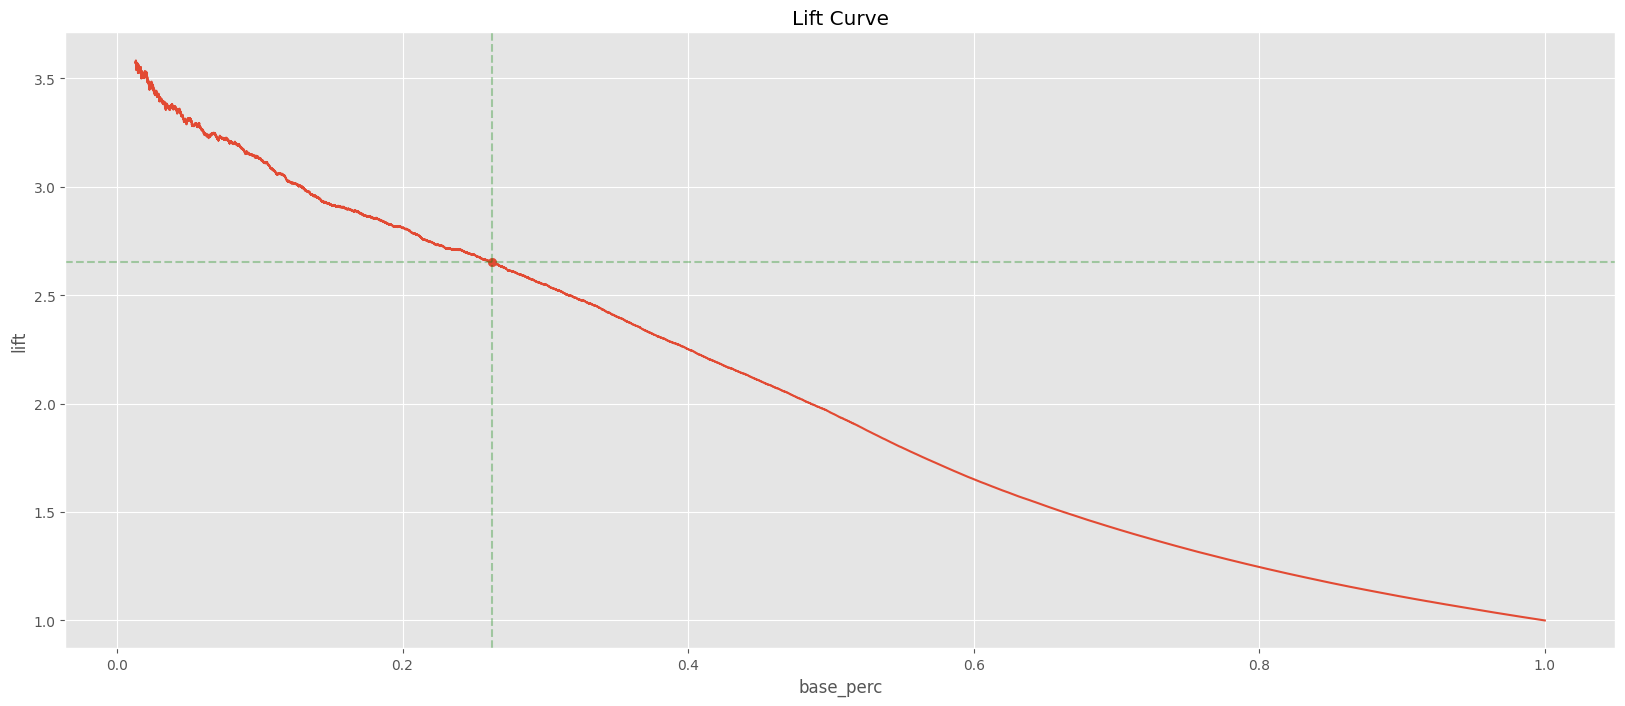

In [155]:
plt.figure(figsize=(20, 8))
sns.lineplot(x='base_perc', y='lift', data=results.iloc[1000:])
plt.axvline(x=base_perc, color='g', ls='--', alpha=0.3)
plt.axhline(y=results[results['base_perc'] >= base_perc].iloc[0]['lift'], color='g', ls='--', alpha=0.3)
plt.scatter(base_perc, results[results['base_perc'] >= base_perc].iloc[0]['lift'])
plt.title("Lift Curve")
plt.show()

### 11.3 If the sales team's capacity increases to 40.000 calls, what percentage of customers interested in purchasing auto insurance will the sales team be able to contact?

In [156]:
base_perc = 40000/results.shape[0]
reached_perc = reached_interested_customers(40000) 

print(f'If the sales team make 40.000 calls, they will reach {reached_perc:.2f}% of customers interested in purchasing vehicle insurance.')

If the sales team make 40.000 calls, they will reach 0.99% of customers interested in purchasing vehicle insurance.


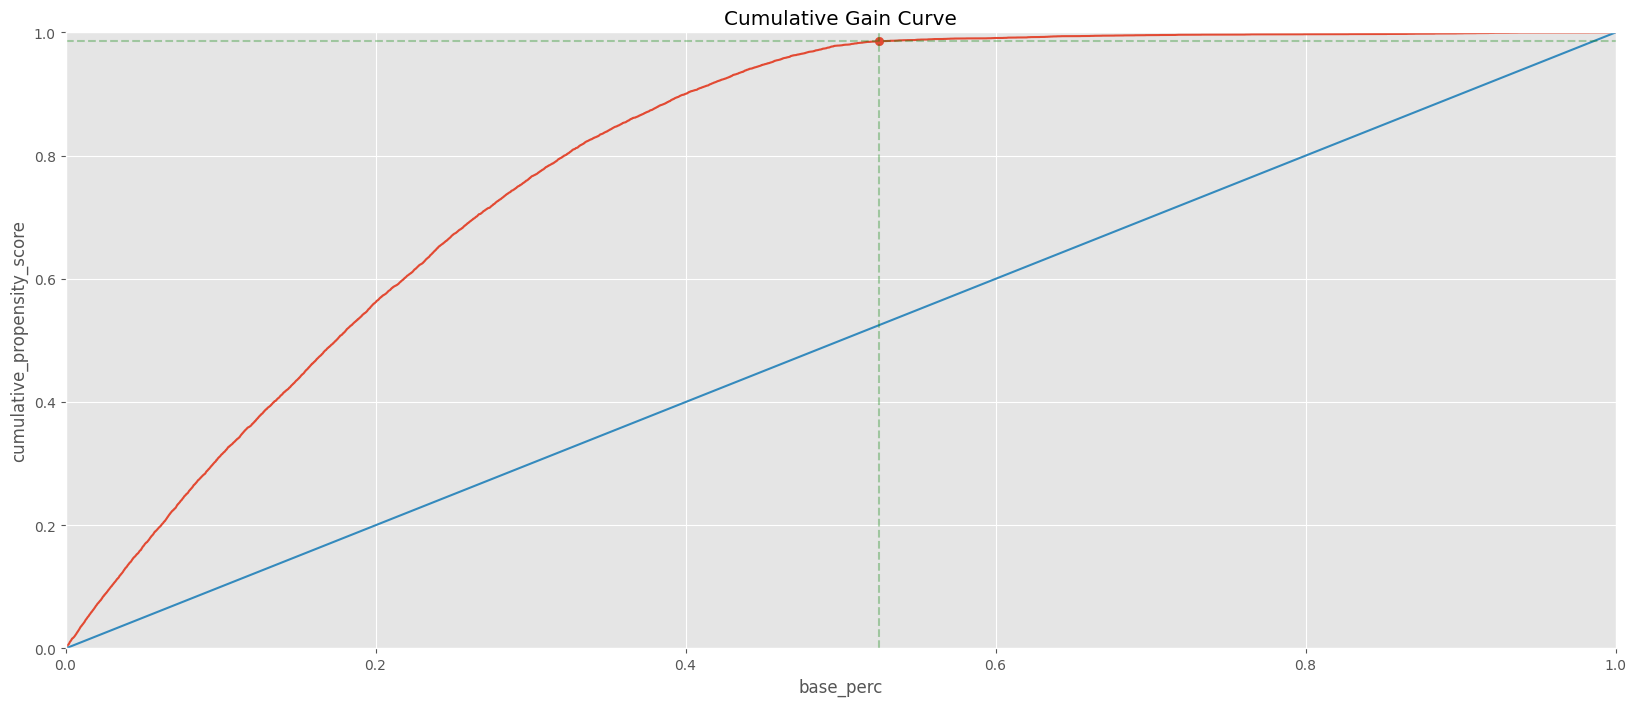

In [157]:
plt.figure(figsize=(20, 8))

sns.lineplot(x='base_perc', y='cumulative_propensity_score', data=results)
sns.lineplot(x='base_perc', y='base_perc', data=results)
plt.axvline(x=base_perc, color='g', ls='--', alpha=0.3)
plt.axhline(y=reached_perc, color='g', ls='--', alpha=0.3)

plt.scatter(base_perc, reached_perc)

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.title("Cumulative Gain Curve")

plt.show()

In [158]:
lift = results[results['base_perc'] >= base_perc].iloc[0]['lift']
print(f'Calling 40.000 based on our model will be {lift:.2f}x better than using random choice.')

Calling 40.000 based on our model will be 1.88x better than using random choice.


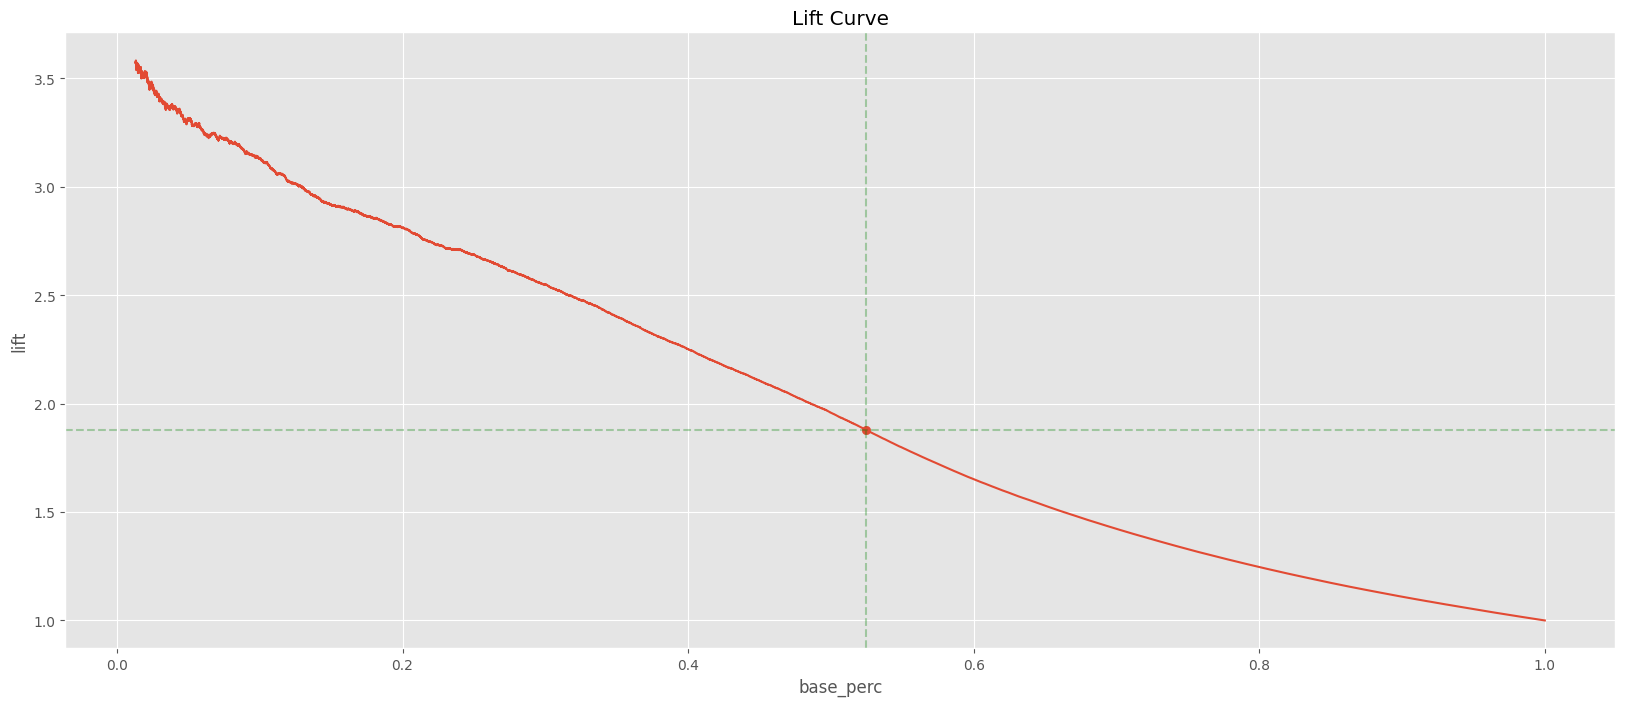

In [159]:
plt.figure(figsize=(20, 8))
sns.lineplot(x='base_perc', y='lift', data=results.iloc[1000:])
plt.axvline(x=base_perc, color='g', ls='--', alpha=0.3)
plt.axhline(y=results[results['base_perc'] >= base_perc].iloc[0]['lift'], color='g', ls='--', alpha=0.3)
plt.scatter(base_perc, results[results['base_perc'] >= base_perc].iloc[0]['lift'])
plt.title("Lift Curve")
plt.show()

### 11.4 How many calls does the sales team need to make to contact 80% of customers interested in purchasing auto insurance?

In [160]:
n_customers = results[results['cumulative_propensity_score'] >= 0.8].iloc[0]['base_perc']*results.shape[0]
print(f'To contact 80% of customers interested in purchasing vehicle insurance, the sales team need to make {int(n_customers)} calls.')

To contact 80% of customers interested in purchasing vehicle insurance, the sales team need to make 24518 calls.


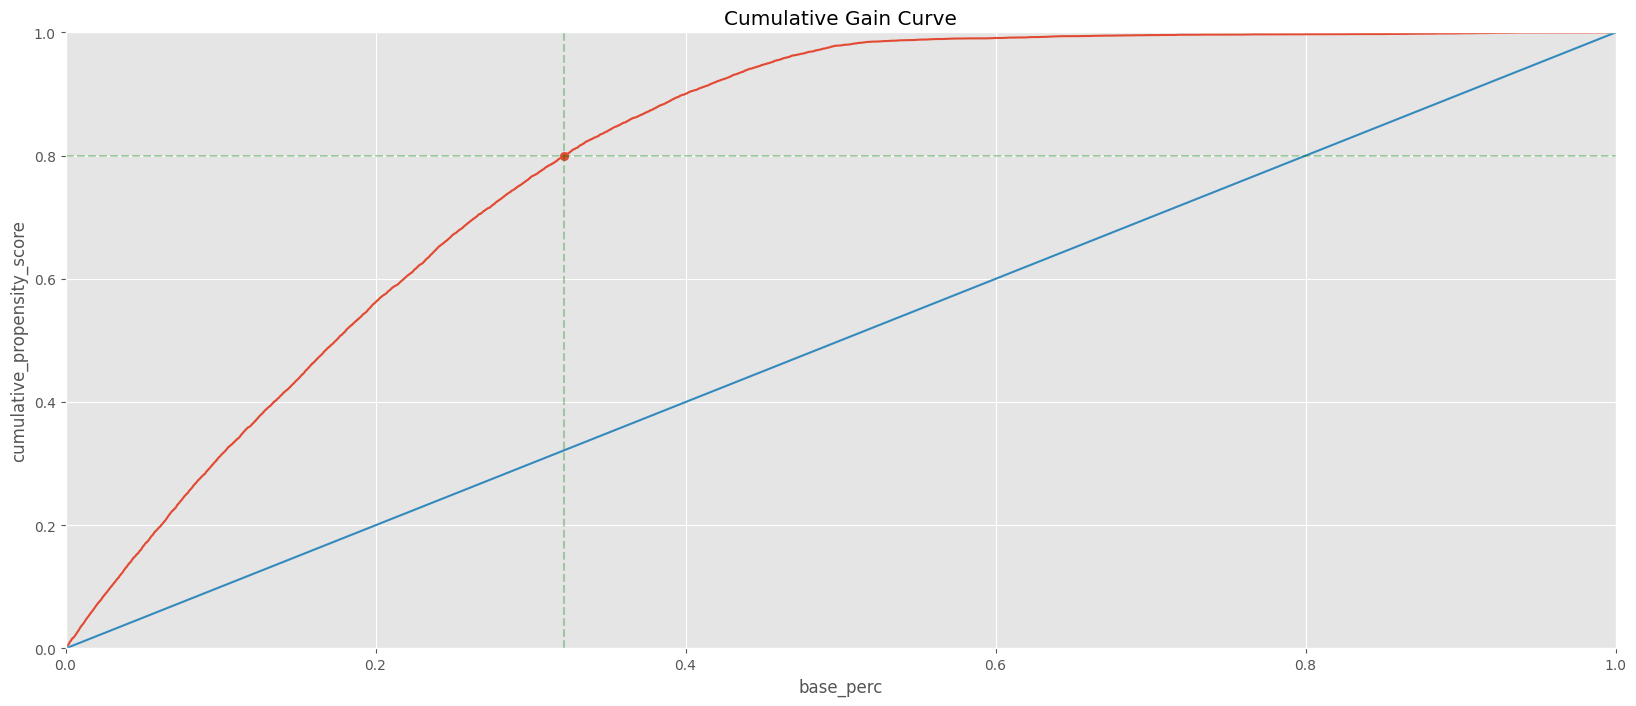

In [161]:
plt.figure(figsize=(20, 8))

sns.lineplot(x='base_perc', y='cumulative_propensity_score', data=results)
sns.lineplot(x='base_perc', y='base_perc', data=results)
plt.axvline(x=results[results['cumulative_propensity_score'] >= 0.8].iloc[0]['base_perc'], color='g', ls='--', alpha=0.3)
plt.axhline(y=0.8, color='g', ls='--', alpha=0.3)

plt.scatter(results[results['cumulative_propensity_score'] >= 0.8].iloc[0]['base_perc'], 0.8)

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.title("Cumulative Gain Curve")

plt.show()

In [162]:
lift = results[results['base_perc'] >= results[results['cumulative_propensity_score'] >= 0.8].iloc[0]['base_perc']].iloc[0]['lift']
print(f'Calling 24902 customers based on our model will be {lift:.2f}x better than using random choice.')

Calling 24902 based on our model will be 2.49x better than using random choice.


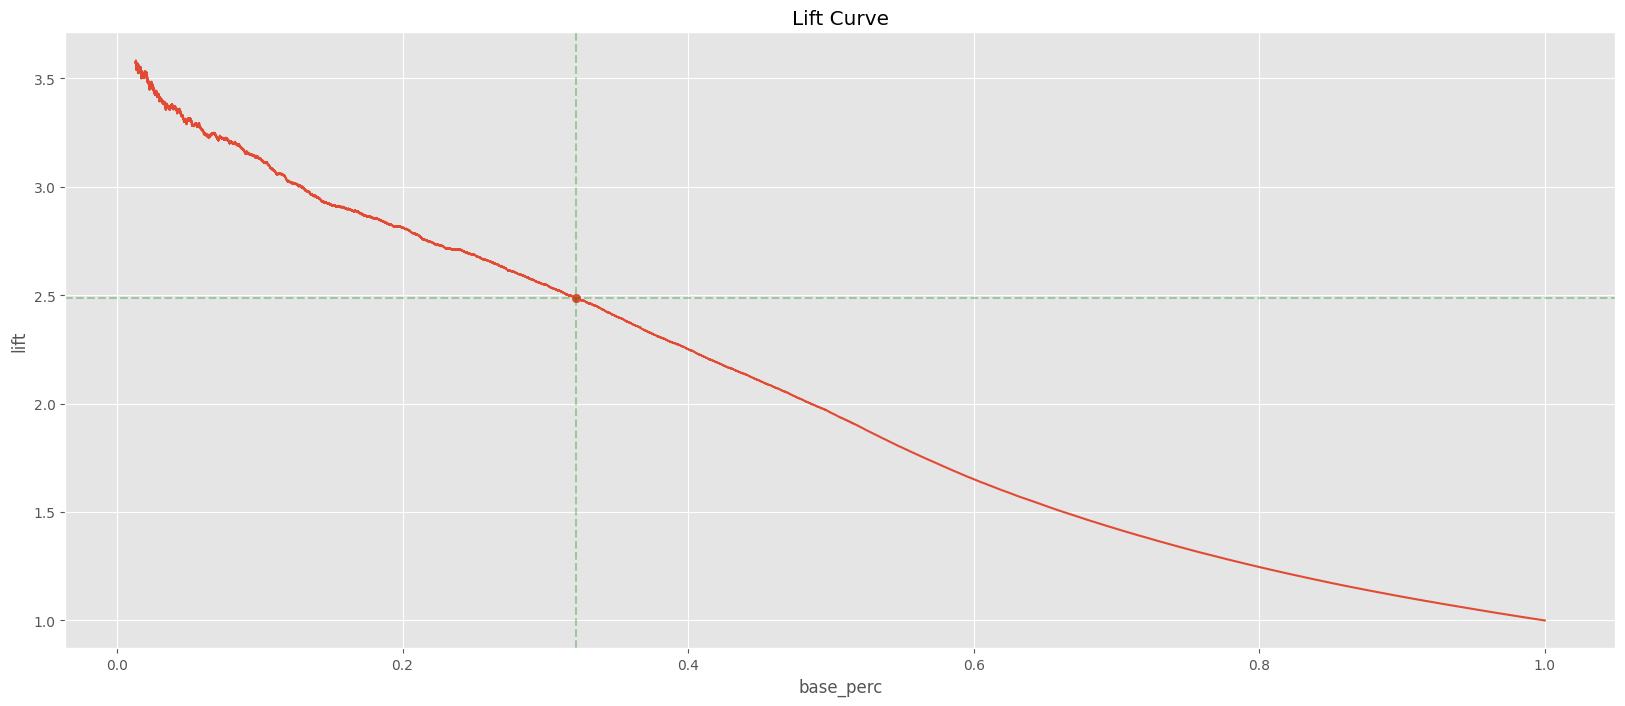

In [163]:
base_perc = results[results['cumulative_propensity_score'] >= 0.8].iloc[0]['base_perc']
plt.figure(figsize=(20, 8))
sns.lineplot(x='base_perc', y='lift', data=results.iloc[1000:])
plt.axvline(x=base_perc, color='g', ls='--', alpha=0.3)
plt.axhline(y=results[results['base_perc'] >= base_perc].iloc[0]['lift'], color='g', ls='--', alpha=0.3)
plt.scatter(base_perc, results[results['base_perc'] >= base_perc].iloc[0]['lift'])
plt.title("Lift Curve")
plt.show()